In [4]:
import logging
import time
from pprint import pprint
from typing import List

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import seaborn as sns
import torch
from IPython.display import HTML
from pyro.infer import SVI, Predictive, Trace_ELBO
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean

from collab2.foraging.fish import StochasticFish_IndependentRates,animate_trajectories
from collab2.foraging.toolkit import (
    animate_predictors,
    dataObject,
    derive_predictors_and_scores,
    plot_coefs,
    rescale_to_grid,
    subsample_frames_constant_frame_rate
)

import logging
import time
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")
derivation_logger = logging.getLogger(__name__)

In [5]:
# Simulation params (common to all)
N = 4
arena_size = 100
Tmax = 100
L = 80
v_scale = 10
rate = 10

# Predictor/score derivation params (common to all)
grid_size = 100
leeway = 10
window_size_multiplier = 0.2
grid_sampling_fraction = 0.5
score_kwargs = {}

In [6]:
# Params to be varied
sigma_v_list = np.round(10 ** np.linspace(-1, 1.3, 15),decimals=2)
sigma_t_list = np.round(np.linspace(0.05, 0.9, 15),decimals=2)

print(sigma_v_list)
print(sigma_t_list)

[ 0.1   0.15  0.21  0.31  0.45  0.66  0.97  1.41  2.06  3.01  4.39  6.41
  9.36 13.67 19.95]
[0.05 0.11 0.17 0.23 0.29 0.35 0.41 0.48 0.54 0.6  0.66 0.72 0.78 0.84
 0.9 ]


# Helper functions

In [7]:
def get_predictors_from_sim(
    sim,
    grid_size=100,
    frames_skipped=1,
    leeway=10,
    verbose=False,
    grid_sampling_fraction=1,
    normalize=False,
    window_size_multiplier = 0.5,
    score_kwargs = None
):

    # choose frames_skipped based on dt and vscale if not provided
    if frames_skipped is None:
        frames_skipped = max(1, int(0.03 * sim.arena_size / (sim.vscale * sim.dt)))

    #print(f"Time points skipped for subsampling : {frames_skipped}")

    # get DataFrame
    x = sim.trajectories[:, :, 0].reshape(-1)
    y = sim.trajectories[:, :, 1].reshape(-1)
    num_frames = sim.trajectories.shape[1]
    num_foragers = sim.trajectories.shape[0]
    time = np.tile(np.arange(num_frames), num_foragers)
    foragers = np.concatenate([i * np.ones(num_frames) for i in range(num_foragers)])

    data = {
        "x": x,
        "y": y,
        "time": time,
        "forager": foragers,
    }

    foragersDF = pd.DataFrame(data)

    # discretize to grid
    gridMin = -sim.arena_size
    gridMax = sim.arena_size
    foragersDF_scaled = rescale_to_grid(
        foragersDF, size=grid_size, gridMin=gridMin, gridMax=gridMax
    )

    foragersDF_scaled_subsampled = subsample_frames_constant_frame_rate(foragersDF_scaled,frame_spacing=frames_skipped)
    
    # create foragers object
    foragers_object = dataObject(
        foragersDF_scaled_subsampled,
        grid_size=grid_size,
    )

    # define circular grid constraint function
    def circular_constraint_func(grid, c_x, c_y, R):
        ind = ((grid["x"] - c_x) ** 2 + (grid["y"] - c_y) ** 2) < R**2
        return grid.loc[ind]

    grid_constraint_params = {
        "c_x": grid_size / 2,
        "c_y": grid_size / 2,
        "R": grid_size / 2,
    }

    # choose kwargs for predictors
    # for now, exactly "matched" to sim parameters.
    # CAUTION : subsampling and discretizing to grid changes time and length units!!
    # need to appropriately rescale these quantities where applicable.
    # eg, velocities used to calculate predictors are in units of (grid unit)/(frame interval)
    # therefore, need to rescale sigmas by multiplying with (len_conversion_param)/(time_conversion_param)

    # However, rescaling leads to extremely small sigmas.
    # make sigmas larger to allow for more leeway?

    # plan:
    #  if only one of v or pC interactions : use same params for predictors for both
    #  if both present : use respective params for predictors
    #  if neither present: use L=grid_size/3 and sigmas same as diffusion
    #  if diffusion not present: use avg of v and pC params

    sim_parameters = sim.interaction_params
    length_conversion_param = 2 * sim.arena_size / grid_size # 1 grid unit = length_conversion_param * 1 sim length unit
    time_conversion_param = frames_skipped * sim.dt # 1 frame interval = time_conversion_param * 1 sim time unit

    # therefore, sigma_v_predictors = sigma_v_sim * time_conversion_param / length_conversion_param
    foragers_object.length_conversion_param = length_conversion_param
    foragers_object.time_conversion_param = time_conversion_param

    #print(f"1 grid unit = {length_conversion_param} * 1 simulation length unit")
    #print(f"1 frame interval = {time_conversion_param} *  1 simulation time unit")

    try:
        L_vicsek = 1/length_conversion_param * np.mean(
            sim_parameters["vicsek"]["interaction_length"]
        )
        sigma_v_vicsek = (
            leeway
            * time_conversion_param / length_conversion_param
            * np.mean(sim_parameters["vicsek"]["sigma_v"])
        )
        sigma_t_vicsek = np.mean(sim_parameters["vicsek"]["sigma_t"])

    except KeyError:
        L_vicsek = np.nan
        sigma_v_vicsek = np.nan
        sigma_t_vicsek = np.nan

    try:
        L_pC = 1/length_conversion_param * np.mean(
            sim.interaction_params["pairwiseCopying"]["interaction_length"]
        )
        sigma_v_pC = (
            leeway
            * time_conversion_param / length_conversion_param   
            * np.mean(sim.interaction_params["pairwiseCopying"]["sigma_v"])
        )
        sigma_t_pC = np.mean(sim.interaction_params["pairwiseCopying"]["sigma_t"])

    except KeyError:
        L_pC = np.nan
        sigma_v_pC = np.nan
        sigma_t_pC = np.nan

    try:
        sigma_v_diff = (
            leeway
            * time_conversion_param / length_conversion_param
            * np.mean(sim.interaction_params["diffusion"]["sigma_v"])
        )
        sigma_t_diff = np.mean(sim.interaction_params["diffusion"]["sigma_t"])

    except KeyError:
        sigma_v_diff = np.nan
        sigma_t_diff = np.nan

    if np.logical_xor(np.isnan(L_vicsek), np.isnan(L_pC)):
        if np.isnan(L_vicsek):
            L_vicsek = L_pC
            sigma_v_vicsek = sigma_v_pC
            sigma_t_vicsek = sigma_t_pC

        else:
            L_pC = L_vicsek
            sigma_v_pC = sigma_v_vicsek
            sigma_t_pC = sigma_t_vicsek

    elif np.isnan(L_vicsek) and np.isnan(L_pC):
        L_vicsek = grid_size / 3
        L_pC = grid_size / 3
        sigma_v_vicsek = sigma_v_diff
        sigma_v_pC = sigma_v_diff
        sigma_t_vicsek = sigma_t_diff
        sigma_t_pC = sigma_t_diff

    if np.isnan(sigma_v_diff):
        sigma_v_diff = np.mean([sigma_v_vicsek, sigma_v_pC])
        sigma_t_diff = np.mean([sigma_t_vicsek, sigma_t_pC])

    local_windows_kwargs = {
        "window_size": np.maximum(L_pC, L_vicsek) * window_size_multiplier,
        "sampling_fraction": grid_sampling_fraction,
        "skip_incomplete_frames": True,
        "grid_constraint": circular_constraint_func,
        "grid_constraint_params": grid_constraint_params,
    }

    predictor_kwargs = {
        "vicsek": {
            "dt": 1,
            "sigma_v": sigma_v_vicsek,
            "sigma_t": sigma_t_vicsek,
            "interaction_length": L_vicsek,
        },
        "pairwiseCopying": {
            "dt": 1,
            "sigma_v": sigma_v_pC,
            "sigma_t": sigma_t_pC,
            "interaction_length": L_pC,
        },
        "velocityDiffusion": {
            "dt": 1,
            "sigma_v": sigma_v_diff,
            "sigma_t": sigma_t_diff,
        },
    }

    if score_kwargs is None:
        score_kwargs = {
            "nextStep_sublinear" : {"nonlinearity_exponent" : 0.5},
            "nextStepExponential" : {"decay_length" : 1},
        }

    if verbose:
        print("Predictor kwargs:")
        pprint(predictor_kwargs)
        print("-" * 50)

    # derive predictors and scores
    derivedDF = derive_predictors_and_scores(
        foragers_object,
        local_windows_kwargs=local_windows_kwargs,
        predictor_kwargs=predictor_kwargs,
        score_kwargs=score_kwargs,
        dropna=True,
        add_scaled_values=normalize,
    )
    return foragers_object, derivedDF


# Vicsek

Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4073 (10.18%)
Number vicsek interactions with more than 1 neighbor: 3704 (90.94%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:02:54,642 - Local windows completed in 8.72 seconds.
2024-10-08 23:03:10,171 - vicsek completed in 15.53 seconds.
2024-10-08 23:03:39,018 - pairwiseCopying completed in 28.85 seconds.
2024-10-08 23:03:46,944 - velocityDiffusion completed in 7.93 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/134300 (~0.37%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:03:47,265 - derivedDF generated in 0.32 seconds.
2024-10-08 23:03:47,310 - [sigma_v=0.1,sigma_t=0.05] generated in 64.16 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4119 (10.30%)
Number vicsek interactions with more than 1 neighbor: 3861 (93.74%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:03:58,050 - Local windows completed in 8.62 seconds.
2024-10-08 23:04:14,143 - vicsek completed in 16.09 seconds.
2024-10-08 23:04:41,252 - pairwiseCopying completed in 27.11 seconds.
2024-10-08 23:04:49,291 - velocityDiffusion completed in 8.04 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/143651 (~0.34%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:04:49,622 - derivedDF generated in 0.33 seconds.
2024-10-08 23:04:49,734 - [sigma_v=0.1,sigma_t=0.11] generated in 62.42 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4070 (10.17%)
Number vicsek interactions with more than 1 neighbor: 3855 (94.72%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:05:00,406 - Local windows completed in 8.60 seconds.
2024-10-08 23:05:16,159 - vicsek completed in 15.75 seconds.
2024-10-08 23:05:42,872 - pairwiseCopying completed in 26.71 seconds.
2024-10-08 23:05:50,591 - velocityDiffusion completed in 7.72 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151495 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:05:50,920 - derivedDF generated in 0.33 seconds.
2024-10-08 23:05:51,039 - [sigma_v=0.1,sigma_t=0.17] generated in 61.30 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4087 (10.22%)
Number vicsek interactions with more than 1 neighbor: 3899 (95.40%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:06:01,911 - Local windows completed in 8.69 seconds.
2024-10-08 23:06:18,101 - vicsek completed in 16.19 seconds.
2024-10-08 23:06:44,613 - pairwiseCopying completed in 26.51 seconds.
2024-10-08 23:06:51,973 - velocityDiffusion completed in 7.36 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152797 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:06:52,533 - derivedDF generated in 0.56 seconds.
2024-10-08 23:06:52,654 - [sigma_v=0.1,sigma_t=0.23] generated in 61.61 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4121 (10.30%)
Number vicsek interactions with more than 1 neighbor: 3990 (96.82%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:07:02,463 - Local windows completed in 7.84 seconds.
2024-10-08 23:07:18,420 - vicsek completed in 15.96 seconds.
2024-10-08 23:07:44,464 - pairwiseCopying completed in 26.04 seconds.
2024-10-08 23:07:51,717 - velocityDiffusion completed in 7.25 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155178 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:07:52,033 - derivedDF generated in 0.31 seconds.
2024-10-08 23:07:52,153 - [sigma_v=0.1,sigma_t=0.29] generated in 59.50 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4101 (10.25%)
Number vicsek interactions with more than 1 neighbor: 4006 (97.68%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:08:02,140 - Local windows completed in 8.00 seconds.
2024-10-08 23:08:17,044 - vicsek completed in 14.90 seconds.
2024-10-08 23:08:43,293 - pairwiseCopying completed in 26.25 seconds.
2024-10-08 23:08:50,575 - velocityDiffusion completed in 7.28 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/159203 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:08:50,890 - derivedDF generated in 0.31 seconds.
2024-10-08 23:08:51,017 - [sigma_v=0.1,sigma_t=0.35] generated in 58.86 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4097 (10.24%)
Number vicsek interactions with more than 1 neighbor: 3943 (96.24%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:09:01,118 - Local windows completed in 8.12 seconds.
2024-10-08 23:09:15,806 - vicsek completed in 14.69 seconds.
2024-10-08 23:09:41,412 - pairwiseCopying completed in 25.60 seconds.
2024-10-08 23:09:48,721 - velocityDiffusion completed in 7.31 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153470 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:09:49,298 - derivedDF generated in 0.58 seconds.
2024-10-08 23:09:49,423 - [sigma_v=0.1,sigma_t=0.41] generated in 58.41 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4095 (10.24%)
Number vicsek interactions with more than 1 neighbor: 4008 (97.88%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:09:59,381 - Local windows completed in 7.89 seconds.
2024-10-08 23:10:14,464 - vicsek completed in 15.08 seconds.
2024-10-08 23:10:41,901 - pairwiseCopying completed in 27.44 seconds.
2024-10-08 23:10:49,718 - velocityDiffusion completed in 7.82 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/158158 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:10:50,055 - derivedDF generated in 0.34 seconds.
2024-10-08 23:10:50,181 - [sigma_v=0.1,sigma_t=0.48] generated in 60.76 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4095 (10.24%)
Number vicsek interactions with more than 1 neighbor: 4022 (98.22%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:11:00,747 - Local windows completed in 8.59 seconds.
2024-10-08 23:11:16,655 - vicsek completed in 15.91 seconds.
2024-10-08 23:11:44,012 - pairwiseCopying completed in 27.36 seconds.
2024-10-08 23:11:51,523 - velocityDiffusion completed in 7.51 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154801 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:11:51,843 - derivedDF generated in 0.32 seconds.
2024-10-08 23:11:51,967 - [sigma_v=0.1,sigma_t=0.54] generated in 61.79 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4034 (10.08%)
Number vicsek interactions with more than 1 neighbor: 3645 (90.36%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:12:02,248 - Local windows completed in 8.33 seconds.
2024-10-08 23:12:16,856 - vicsek completed in 14.61 seconds.
2024-10-08 23:12:43,029 - pairwiseCopying completed in 26.17 seconds.
2024-10-08 23:12:50,348 - velocityDiffusion completed in 7.32 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155020 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:12:50,666 - derivedDF generated in 0.32 seconds.
2024-10-08 23:12:50,785 - [sigma_v=0.1,sigma_t=0.6] generated in 58.82 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4104 (10.26%)
Number vicsek interactions with more than 1 neighbor: 3991 (97.25%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:13:00,922 - Local windows completed in 8.08 seconds.
2024-10-08 23:13:16,242 - vicsek completed in 15.32 seconds.
2024-10-08 23:13:42,543 - pairwiseCopying completed in 26.30 seconds.
2024-10-08 23:13:49,709 - velocityDiffusion completed in 7.17 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/159744 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:13:50,032 - derivedDF generated in 0.32 seconds.
2024-10-08 23:13:50,168 - [sigma_v=0.1,sigma_t=0.66] generated in 59.38 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4095 (10.24%)
Number vicsek interactions with more than 1 neighbor: 3933 (96.04%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:14:00,123 - Local windows completed in 8.00 seconds.
2024-10-08 23:14:14,849 - vicsek completed in 14.73 seconds.
2024-10-08 23:14:40,906 - pairwiseCopying completed in 26.06 seconds.
2024-10-08 23:14:48,036 - velocityDiffusion completed in 7.13 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/157262 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:14:48,355 - derivedDF generated in 0.32 seconds.
2024-10-08 23:14:48,480 - [sigma_v=0.1,sigma_t=0.72] generated in 58.31 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4088 (10.22%)
Number vicsek interactions with more than 1 neighbor: 3962 (96.92%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:14:58,493 - Local windows completed in 8.02 seconds.
2024-10-08 23:15:13,348 - vicsek completed in 14.85 seconds.
2024-10-08 23:15:38,725 - pairwiseCopying completed in 25.38 seconds.
2024-10-08 23:15:45,948 - velocityDiffusion completed in 7.22 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/157935 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:15:46,533 - derivedDF generated in 0.58 seconds.
2024-10-08 23:15:46,653 - [sigma_v=0.1,sigma_t=0.78] generated in 58.17 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4086 (10.21%)
Number vicsek interactions with more than 1 neighbor: 3218 (78.76%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:15:56,482 - Local windows completed in 7.85 seconds.
2024-10-08 23:16:10,527 - vicsek completed in 14.04 seconds.
2024-10-08 23:16:32,161 - pairwiseCopying completed in 21.63 seconds.
2024-10-08 23:16:39,615 - velocityDiffusion completed in 7.45 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151042 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:16:39,936 - derivedDF generated in 0.32 seconds.
2024-10-08 23:16:40,052 - [sigma_v=0.1,sigma_t=0.84] generated in 53.40 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4095 (10.24%)
Number vicsek interactions with more than 1 neighbor: 3929 (95.95%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:16:49,861 - Local windows completed in 7.81 seconds.
2024-10-08 23:17:04,898 - vicsek completed in 15.04 seconds.
2024-10-08 23:17:30,176 - pairwiseCopying completed in 25.28 seconds.
2024-10-08 23:17:38,591 - velocityDiffusion completed in 8.41 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155146 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:17:38,911 - derivedDF generated in 0.32 seconds.
2024-10-08 23:17:39,036 - [sigma_v=0.1,sigma_t=0.9] generated in 58.98 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4004 (10.01%)
Number vicsek interactions with more than 1 neighbor: 3497 (87.34%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:17:48,940 - Local windows completed in 7.92 seconds.
2024-10-08 23:18:03,504 - vicsek completed in 14.56 seconds.
2024-10-08 23:18:26,589 - pairwiseCopying completed in 23.08 seconds.
2024-10-08 23:18:33,938 - velocityDiffusion completed in 7.35 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/134481 (~0.37%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:18:34,256 - derivedDF generated in 0.32 seconds.
2024-10-08 23:18:34,353 - [sigma_v=0.15,sigma_t=0.05] generated in 55.32 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4044 (10.11%)
Number vicsek interactions with more than 1 neighbor: 3675 (90.88%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:18:44,135 - Local windows completed in 7.84 seconds.
2024-10-08 23:18:59,111 - vicsek completed in 14.97 seconds.
2024-10-08 23:19:23,402 - pairwiseCopying completed in 24.29 seconds.
2024-10-08 23:19:31,010 - velocityDiffusion completed in 7.61 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/143711 (~0.34%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:19:31,328 - derivedDF generated in 0.32 seconds.
2024-10-08 23:19:31,447 - [sigma_v=0.15,sigma_t=0.11] generated in 57.09 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4088 (10.22%)
Number vicsek interactions with more than 1 neighbor: 3827 (93.62%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:19:41,252 - Local windows completed in 7.83 seconds.
2024-10-08 23:19:56,174 - vicsek completed in 14.92 seconds.
2024-10-08 23:20:20,878 - pairwiseCopying completed in 24.70 seconds.
2024-10-08 23:20:28,441 - velocityDiffusion completed in 7.56 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151464 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:20:28,764 - derivedDF generated in 0.32 seconds.
2024-10-08 23:20:28,887 - [sigma_v=0.15,sigma_t=0.17] generated in 57.44 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4012 (10.03%)
Number vicsek interactions with more than 1 neighbor: 3742 (93.27%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:20:38,821 - Local windows completed in 7.99 seconds.
2024-10-08 23:20:53,407 - vicsek completed in 14.58 seconds.
2024-10-08 23:21:17,432 - pairwiseCopying completed in 24.02 seconds.
2024-10-08 23:21:24,450 - velocityDiffusion completed in 7.02 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153498 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:21:25,100 - derivedDF generated in 0.65 seconds.
2024-10-08 23:21:25,230 - [sigma_v=0.15,sigma_t=0.23] generated in 56.34 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4019 (10.05%)
Number vicsek interactions with more than 1 neighbor: 3763 (93.63%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:21:35,059 - Local windows completed in 7.85 seconds.
2024-10-08 23:21:49,652 - vicsek completed in 14.59 seconds.
2024-10-08 23:22:14,578 - pairwiseCopying completed in 24.93 seconds.
2024-10-08 23:22:21,959 - velocityDiffusion completed in 7.38 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152547 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:22:22,282 - derivedDF generated in 0.32 seconds.
2024-10-08 23:22:22,407 - [sigma_v=0.15,sigma_t=0.29] generated in 57.18 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4103 (10.26%)
Number vicsek interactions with more than 1 neighbor: 3874 (94.42%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:22:32,502 - Local windows completed in 8.06 seconds.
2024-10-08 23:22:48,462 - vicsek completed in 15.96 seconds.
2024-10-08 23:23:13,787 - pairwiseCopying completed in 25.32 seconds.
2024-10-08 23:23:21,078 - velocityDiffusion completed in 7.29 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154479 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:23:21,672 - derivedDF generated in 0.59 seconds.
2024-10-08 23:23:21,797 - [sigma_v=0.15,sigma_t=0.35] generated in 59.39 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4092 (10.23%)
Number vicsek interactions with more than 1 neighbor: 4008 (97.95%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:23:31,639 - Local windows completed in 7.86 seconds.
2024-10-08 23:23:46,495 - vicsek completed in 14.86 seconds.
2024-10-08 23:24:12,613 - pairwiseCopying completed in 26.12 seconds.
2024-10-08 23:24:19,873 - velocityDiffusion completed in 7.26 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152693 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:24:20,196 - derivedDF generated in 0.32 seconds.
2024-10-08 23:24:20,321 - [sigma_v=0.15,sigma_t=0.41] generated in 58.52 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4092 (10.23%)
Number vicsek interactions with more than 1 neighbor: 4044 (98.83%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:24:30,396 - Local windows completed in 8.11 seconds.
2024-10-08 23:24:45,254 - vicsek completed in 14.86 seconds.
2024-10-08 23:25:11,786 - pairwiseCopying completed in 26.53 seconds.
2024-10-08 23:25:19,099 - velocityDiffusion completed in 7.31 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/157327 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:25:19,475 - derivedDF generated in 0.38 seconds.
2024-10-08 23:25:19,628 - [sigma_v=0.15,sigma_t=0.48] generated in 59.31 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4095 (10.24%)
Number vicsek interactions with more than 1 neighbor: 3948 (96.41%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:25:29,620 - Local windows completed in 8.03 seconds.
2024-10-08 23:25:44,565 - vicsek completed in 14.94 seconds.
2024-10-08 23:26:10,619 - pairwiseCopying completed in 26.05 seconds.
2024-10-08 23:26:17,888 - velocityDiffusion completed in 7.27 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/157718 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:26:18,500 - derivedDF generated in 0.61 seconds.
2024-10-08 23:26:18,631 - [sigma_v=0.15,sigma_t=0.54] generated in 59.00 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4105 (10.26%)
Number vicsek interactions with more than 1 neighbor: 3932 (95.79%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:26:28,506 - Local windows completed in 7.92 seconds.
2024-10-08 23:26:43,296 - vicsek completed in 14.79 seconds.
2024-10-08 23:27:09,004 - pairwiseCopying completed in 25.71 seconds.
2024-10-08 23:27:16,352 - velocityDiffusion completed in 7.35 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/157341 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:27:16,679 - derivedDF generated in 0.33 seconds.
2024-10-08 23:27:16,811 - [sigma_v=0.15,sigma_t=0.6] generated in 58.18 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4074 (10.18%)
Number vicsek interactions with more than 1 neighbor: 3707 (90.99%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:27:26,865 - Local windows completed in 8.06 seconds.
2024-10-08 23:27:41,281 - vicsek completed in 14.42 seconds.
2024-10-08 23:28:07,410 - pairwiseCopying completed in 26.13 seconds.
2024-10-08 23:28:14,589 - velocityDiffusion completed in 7.18 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154748 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:28:14,911 - derivedDF generated in 0.32 seconds.
2024-10-08 23:28:15,041 - [sigma_v=0.15,sigma_t=0.66] generated in 58.23 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4095 (10.24%)
Number vicsek interactions with more than 1 neighbor: 3983 (97.26%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:28:25,119 - Local windows completed in 8.10 seconds.
2024-10-08 23:28:39,821 - vicsek completed in 14.70 seconds.
2024-10-08 23:29:04,712 - pairwiseCopying completed in 24.89 seconds.
2024-10-08 23:29:11,927 - velocityDiffusion completed in 7.21 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/157470 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:29:12,245 - derivedDF generated in 0.32 seconds.
2024-10-08 23:29:12,375 - [sigma_v=0.15,sigma_t=0.72] generated in 57.33 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4097 (10.24%)
Number vicsek interactions with more than 1 neighbor: 3831 (93.51%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:29:22,399 - Local windows completed in 8.06 seconds.
2024-10-08 23:29:37,070 - vicsek completed in 14.67 seconds.
2024-10-08 23:30:01,743 - pairwiseCopying completed in 24.67 seconds.
2024-10-08 23:30:08,908 - velocityDiffusion completed in 7.16 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154782 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:30:09,231 - derivedDF generated in 0.32 seconds.
2024-10-08 23:30:09,360 - [sigma_v=0.15,sigma_t=0.78] generated in 56.98 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4079 (10.20%)
Number vicsek interactions with more than 1 neighbor: 3566 (87.42%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:30:19,477 - Local windows completed in 8.11 seconds.
2024-10-08 23:30:34,393 - vicsek completed in 14.92 seconds.
2024-10-08 23:30:57,017 - pairwiseCopying completed in 22.62 seconds.
2024-10-08 23:31:04,142 - velocityDiffusion completed in 7.12 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151646 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:31:04,462 - derivedDF generated in 0.32 seconds.
2024-10-08 23:31:04,592 - [sigma_v=0.15,sigma_t=0.84] generated in 55.23 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4095 (10.24%)
Number vicsek interactions with more than 1 neighbor: 3871 (94.53%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:31:14,697 - Local windows completed in 8.12 seconds.
2024-10-08 23:31:29,532 - vicsek completed in 14.83 seconds.
2024-10-08 23:31:53,679 - pairwiseCopying completed in 24.15 seconds.
2024-10-08 23:32:00,859 - velocityDiffusion completed in 7.18 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/158813 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:32:01,182 - derivedDF generated in 0.32 seconds.
2024-10-08 23:32:01,314 - [sigma_v=0.15,sigma_t=0.9] generated in 56.72 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4117 (10.29%)
Number vicsek interactions with more than 1 neighbor: 3634 (88.27%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:32:11,305 - Local windows completed in 8.02 seconds.
2024-10-08 23:32:25,971 - vicsek completed in 14.66 seconds.
2024-10-08 23:32:49,822 - pairwiseCopying completed in 23.85 seconds.
2024-10-08 23:32:58,388 - velocityDiffusion completed in 8.56 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/134603 (~0.37%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:32:58,888 - derivedDF generated in 0.50 seconds.
2024-10-08 23:32:58,992 - [sigma_v=0.21,sigma_t=0.05] generated in 57.68 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4093 (10.23%)
Number vicsek interactions with more than 1 neighbor: 3727 (91.06%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:33:09,265 - Local windows completed in 8.23 seconds.
2024-10-08 23:33:23,977 - vicsek completed in 14.71 seconds.
2024-10-08 23:33:48,576 - pairwiseCopying completed in 24.60 seconds.
2024-10-08 23:33:55,928 - velocityDiffusion completed in 7.35 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/144423 (~0.34%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:33:56,250 - derivedDF generated in 0.32 seconds.
2024-10-08 23:33:56,379 - [sigma_v=0.21,sigma_t=0.11] generated in 57.39 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4094 (10.23%)
Number vicsek interactions with more than 1 neighbor: 3758 (91.79%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:34:06,415 - Local windows completed in 8.03 seconds.
2024-10-08 23:34:21,317 - vicsek completed in 14.90 seconds.
2024-10-08 23:34:46,775 - pairwiseCopying completed in 25.46 seconds.
2024-10-08 23:34:54,117 - velocityDiffusion completed in 7.34 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/147562 (~0.34%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:34:54,736 - derivedDF generated in 0.62 seconds.
2024-10-08 23:34:54,859 - [sigma_v=0.21,sigma_t=0.17] generated in 58.48 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4053 (10.13%)
Number vicsek interactions with more than 1 neighbor: 3619 (89.29%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:35:04,648 - Local windows completed in 7.85 seconds.
2024-10-08 23:35:19,202 - vicsek completed in 14.55 seconds.
2024-10-08 23:35:43,342 - pairwiseCopying completed in 24.14 seconds.
2024-10-08 23:35:50,607 - velocityDiffusion completed in 7.26 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152369 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:35:50,930 - derivedDF generated in 0.32 seconds.
2024-10-08 23:35:51,054 - [sigma_v=0.21,sigma_t=0.23] generated in 56.19 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4095 (10.24%)
Number vicsek interactions with more than 1 neighbor: 3971 (96.97%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:36:01,115 - Local windows completed in 8.08 seconds.
2024-10-08 23:36:15,883 - vicsek completed in 14.77 seconds.
2024-10-08 23:36:41,628 - pairwiseCopying completed in 25.74 seconds.
2024-10-08 23:36:48,940 - velocityDiffusion completed in 7.31 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155929 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:36:49,262 - derivedDF generated in 0.32 seconds.
2024-10-08 23:36:49,395 - [sigma_v=0.21,sigma_t=0.29] generated in 58.34 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4094 (10.23%)
Number vicsek interactions with more than 1 neighbor: 3892 (95.07%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:36:59,680 - Local windows completed in 8.25 seconds.
2024-10-08 23:37:14,379 - vicsek completed in 14.70 seconds.
2024-10-08 23:37:40,472 - pairwiseCopying completed in 26.09 seconds.
2024-10-08 23:37:47,997 - velocityDiffusion completed in 7.52 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151111 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:37:48,329 - derivedDF generated in 0.33 seconds.
2024-10-08 23:37:48,461 - [sigma_v=0.21,sigma_t=0.35] generated in 59.06 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4095 (10.24%)
Number vicsek interactions with more than 1 neighbor: 4034 (98.51%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:37:58,848 - Local windows completed in 8.41 seconds.
2024-10-08 23:38:16,038 - vicsek completed in 17.19 seconds.
2024-10-08 23:38:44,040 - pairwiseCopying completed in 28.00 seconds.
2024-10-08 23:38:51,702 - velocityDiffusion completed in 7.66 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/158114 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:38:52,040 - derivedDF generated in 0.34 seconds.
2024-10-08 23:38:52,175 - [sigma_v=0.21,sigma_t=0.41] generated in 63.71 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4084 (10.21%)
Number vicsek interactions with more than 1 neighbor: 4000 (97.94%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:39:02,736 - Local windows completed in 8.58 seconds.
2024-10-08 23:39:18,561 - vicsek completed in 15.82 seconds.
2024-10-08 23:39:46,835 - pairwiseCopying completed in 28.27 seconds.
2024-10-08 23:39:54,488 - velocityDiffusion completed in 7.65 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150018 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:39:54,851 - derivedDF generated in 0.36 seconds.
2024-10-08 23:39:54,989 - [sigma_v=0.21,sigma_t=0.48] generated in 62.81 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4095 (10.24%)
Number vicsek interactions with more than 1 neighbor: 4077 (99.56%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:40:05,563 - Local windows completed in 8.54 seconds.
2024-10-08 23:40:21,373 - vicsek completed in 15.81 seconds.
2024-10-08 23:40:49,778 - pairwiseCopying completed in 28.40 seconds.
2024-10-08 23:40:57,425 - velocityDiffusion completed in 7.65 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/159004 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:40:58,081 - derivedDF generated in 0.66 seconds.
2024-10-08 23:40:58,218 - [sigma_v=0.21,sigma_t=0.54] generated in 63.23 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4095 (10.24%)
Number vicsek interactions with more than 1 neighbor: 4062 (99.19%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:41:08,629 - Local windows completed in 8.39 seconds.
2024-10-08 23:41:24,527 - vicsek completed in 15.90 seconds.
2024-10-08 23:41:53,975 - pairwiseCopying completed in 29.45 seconds.
2024-10-08 23:42:01,689 - velocityDiffusion completed in 7.71 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156340 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:42:02,023 - derivedDF generated in 0.33 seconds.
2024-10-08 23:42:02,161 - [sigma_v=0.21,sigma_t=0.6] generated in 63.94 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4095 (10.24%)
Number vicsek interactions with more than 1 neighbor: 4019 (98.14%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:42:12,931 - Local windows completed in 8.72 seconds.
2024-10-08 23:42:28,726 - vicsek completed in 15.79 seconds.
2024-10-08 23:42:56,287 - pairwiseCopying completed in 27.56 seconds.
2024-10-08 23:43:03,842 - velocityDiffusion completed in 7.55 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156159 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:43:04,181 - derivedDF generated in 0.34 seconds.
2024-10-08 23:43:04,316 - [sigma_v=0.21,sigma_t=0.66] generated in 62.15 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4066 (10.16%)
Number vicsek interactions with more than 1 neighbor: 3779 (92.94%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:43:15,831 - Local windows completed in 9.53 seconds.
2024-10-08 23:43:31,104 - vicsek completed in 15.27 seconds.
2024-10-08 23:43:55,732 - pairwiseCopying completed in 24.63 seconds.
2024-10-08 23:44:02,995 - velocityDiffusion completed in 7.26 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156435 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:44:03,317 - derivedDF generated in 0.32 seconds.
2024-10-08 23:44:03,446 - [sigma_v=0.21,sigma_t=0.72] generated in 59.13 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4095 (10.24%)
Number vicsek interactions with more than 1 neighbor: 3484 (85.08%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:44:13,440 - Local windows completed in 8.05 seconds.
2024-10-08 23:44:27,915 - vicsek completed in 14.47 seconds.
2024-10-08 23:44:50,348 - pairwiseCopying completed in 22.43 seconds.
2024-10-08 23:44:57,402 - velocityDiffusion completed in 7.05 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152870 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:44:57,724 - derivedDF generated in 0.32 seconds.
2024-10-08 23:44:57,852 - [sigma_v=0.21,sigma_t=0.78] generated in 54.41 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4095 (10.24%)
Number vicsek interactions with more than 1 neighbor: 3825 (93.41%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:45:07,838 - Local windows completed in 8.02 seconds.
2024-10-08 23:45:22,513 - vicsek completed in 14.67 seconds.
2024-10-08 23:45:46,058 - pairwiseCopying completed in 23.54 seconds.
2024-10-08 23:45:53,139 - velocityDiffusion completed in 7.08 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154683 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:45:53,759 - derivedDF generated in 0.62 seconds.
2024-10-08 23:45:53,894 - [sigma_v=0.21,sigma_t=0.84] generated in 56.04 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4095 (10.24%)
Number vicsek interactions with more than 1 neighbor: 4013 (98.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:46:03,741 - Local windows completed in 7.85 seconds.
2024-10-08 23:46:18,487 - vicsek completed in 14.74 seconds.
2024-10-08 23:46:44,392 - pairwiseCopying completed in 25.90 seconds.
2024-10-08 23:46:51,693 - velocityDiffusion completed in 7.30 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155690 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:46:52,012 - derivedDF generated in 0.32 seconds.
2024-10-08 23:46:52,142 - [sigma_v=0.21,sigma_t=0.9] generated in 58.25 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4128 (10.32%)
Number vicsek interactions with more than 1 neighbor: 3561 (86.26%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:47:02,198 - Local windows completed in 8.06 seconds.
2024-10-08 23:47:16,709 - vicsek completed in 14.51 seconds.
2024-10-08 23:47:40,463 - pairwiseCopying completed in 23.75 seconds.
2024-10-08 23:47:47,929 - velocityDiffusion completed in 7.46 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/138740 (~0.36%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:47:48,251 - derivedDF generated in 0.32 seconds.
2024-10-08 23:47:48,355 - [sigma_v=0.31,sigma_t=0.05] generated in 56.21 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4090 (10.22%)
Number vicsek interactions with more than 1 neighbor: 3688 (90.17%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:47:58,510 - Local windows completed in 8.20 seconds.
2024-10-08 23:48:13,167 - vicsek completed in 14.66 seconds.
2024-10-08 23:48:38,971 - pairwiseCopying completed in 25.80 seconds.
2024-10-08 23:48:46,925 - velocityDiffusion completed in 7.95 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/144920 (~0.34%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:48:47,251 - derivedDF generated in 0.33 seconds.
2024-10-08 23:48:47,381 - [sigma_v=0.31,sigma_t=0.11] generated in 59.03 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4083 (10.21%)
Number vicsek interactions with more than 1 neighbor: 3793 (92.90%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:48:57,404 - Local windows completed in 8.05 seconds.
2024-10-08 23:49:12,266 - vicsek completed in 14.86 seconds.
2024-10-08 23:49:37,305 - pairwiseCopying completed in 25.04 seconds.
2024-10-08 23:49:44,572 - velocityDiffusion completed in 7.27 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150971 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:49:44,896 - derivedDF generated in 0.32 seconds.
2024-10-08 23:49:45,026 - [sigma_v=0.31,sigma_t=0.17] generated in 57.64 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4066 (10.16%)
Number vicsek interactions with more than 1 neighbor: 3693 (90.83%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:49:55,018 - Local windows completed in 8.04 seconds.
2024-10-08 23:50:09,651 - vicsek completed in 14.63 seconds.
2024-10-08 23:50:34,310 - pairwiseCopying completed in 24.66 seconds.
2024-10-08 23:50:41,708 - velocityDiffusion completed in 7.40 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152024 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:50:42,032 - derivedDF generated in 0.32 seconds.
2024-10-08 23:50:42,170 - [sigma_v=0.31,sigma_t=0.23] generated in 57.14 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4101 (10.25%)
Number vicsek interactions with more than 1 neighbor: 3633 (88.59%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:50:52,201 - Local windows completed in 8.03 seconds.
2024-10-08 23:51:06,830 - vicsek completed in 14.63 seconds.
2024-10-08 23:51:31,515 - pairwiseCopying completed in 24.68 seconds.
2024-10-08 23:51:38,751 - velocityDiffusion completed in 7.24 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152778 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:51:39,075 - derivedDF generated in 0.32 seconds.
2024-10-08 23:51:39,204 - [sigma_v=0.31,sigma_t=0.29] generated in 57.03 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4134 (10.33%)
Number vicsek interactions with more than 1 neighbor: 3601 (87.11%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:51:49,356 - Local windows completed in 8.04 seconds.
2024-10-08 23:52:04,099 - vicsek completed in 14.74 seconds.
2024-10-08 23:52:28,416 - pairwiseCopying completed in 24.32 seconds.
2024-10-08 23:52:35,830 - velocityDiffusion completed in 7.41 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152742 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:52:36,158 - derivedDF generated in 0.33 seconds.
2024-10-08 23:52:36,286 - [sigma_v=0.31,sigma_t=0.35] generated in 57.08 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4094 (10.23%)
Number vicsek interactions with more than 1 neighbor: 3651 (89.18%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:52:46,316 - Local windows completed in 8.05 seconds.
2024-10-08 23:53:00,957 - vicsek completed in 14.64 seconds.
2024-10-08 23:53:25,564 - pairwiseCopying completed in 24.61 seconds.
2024-10-08 23:53:34,220 - velocityDiffusion completed in 8.66 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154864 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:53:34,837 - derivedDF generated in 0.62 seconds.
2024-10-08 23:53:34,967 - [sigma_v=0.31,sigma_t=0.41] generated in 58.68 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4095 (10.24%)
Number vicsek interactions with more than 1 neighbor: 4040 (98.66%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:53:45,010 - Local windows completed in 8.06 seconds.
2024-10-08 23:53:59,785 - vicsek completed in 14.77 seconds.
2024-10-08 23:54:26,013 - pairwiseCopying completed in 26.23 seconds.
2024-10-08 23:54:33,204 - velocityDiffusion completed in 7.19 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/159618 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:54:33,529 - derivedDF generated in 0.32 seconds.
2024-10-08 23:54:33,663 - [sigma_v=0.31,sigma_t=0.48] generated in 58.69 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4095 (10.24%)
Number vicsek interactions with more than 1 neighbor: 4020 (98.17%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:54:43,791 - Local windows completed in 8.11 seconds.
2024-10-08 23:54:58,517 - vicsek completed in 14.73 seconds.
2024-10-08 23:55:25,124 - pairwiseCopying completed in 26.61 seconds.
2024-10-08 23:55:32,410 - velocityDiffusion completed in 7.29 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/159008 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:55:32,734 - derivedDF generated in 0.32 seconds.
2024-10-08 23:55:32,871 - [sigma_v=0.31,sigma_t=0.54] generated in 59.21 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4084 (10.21%)
Number vicsek interactions with more than 1 neighbor: 3986 (97.60%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:55:42,923 - Local windows completed in 8.07 seconds.
2024-10-08 23:55:57,558 - vicsek completed in 14.63 seconds.
2024-10-08 23:56:23,571 - pairwiseCopying completed in 26.01 seconds.
2024-10-08 23:56:30,727 - velocityDiffusion completed in 7.16 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/160160 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:56:31,056 - derivedDF generated in 0.33 seconds.
2024-10-08 23:56:31,200 - [sigma_v=0.31,sigma_t=0.6] generated in 58.33 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4122 (10.30%)
Number vicsek interactions with more than 1 neighbor: 3216 (78.02%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:56:41,374 - Local windows completed in 8.18 seconds.
2024-10-08 23:56:55,583 - vicsek completed in 14.21 seconds.
2024-10-08 23:57:18,325 - pairwiseCopying completed in 22.74 seconds.
2024-10-08 23:57:25,440 - velocityDiffusion completed in 7.11 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152021 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:57:25,762 - derivedDF generated in 0.32 seconds.
2024-10-08 23:57:25,889 - [sigma_v=0.31,sigma_t=0.66] generated in 54.69 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4077 (10.19%)
Number vicsek interactions with more than 1 neighbor: 3956 (97.03%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:57:35,888 - Local windows completed in 8.04 seconds.
2024-10-08 23:57:50,622 - vicsek completed in 14.73 seconds.
2024-10-08 23:58:16,226 - pairwiseCopying completed in 25.60 seconds.
2024-10-08 23:58:23,460 - velocityDiffusion completed in 7.23 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153952 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:58:24,079 - derivedDF generated in 0.62 seconds.
2024-10-08 23:58:24,210 - [sigma_v=0.31,sigma_t=0.72] generated in 58.32 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4106 (10.26%)
Number vicsek interactions with more than 1 neighbor: 3970 (96.69%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:58:34,195 - Local windows completed in 7.98 seconds.
2024-10-08 23:58:49,828 - vicsek completed in 15.63 seconds.
2024-10-08 23:59:16,018 - pairwiseCopying completed in 26.19 seconds.
2024-10-08 23:59:23,233 - velocityDiffusion completed in 7.21 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155210 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-08 23:59:23,563 - derivedDF generated in 0.33 seconds.
2024-10-08 23:59:23,697 - [sigma_v=0.31,sigma_t=0.78] generated in 59.49 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4102 (10.25%)
Number vicsek interactions with more than 1 neighbor: 3825 (93.25%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-08 23:59:33,726 - Local windows completed in 8.04 seconds.
2024-10-08 23:59:48,469 - vicsek completed in 14.74 seconds.
2024-10-09 00:00:13,533 - pairwiseCopying completed in 25.06 seconds.
2024-10-09 00:00:20,775 - velocityDiffusion completed in 7.24 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/147512 (~0.34%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:00:21,099 - derivedDF generated in 0.32 seconds.
2024-10-09 00:00:21,232 - [sigma_v=0.31,sigma_t=0.84] generated in 57.53 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4118 (10.29%)
Number vicsek interactions with more than 1 neighbor: 3479 (84.48%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:00:31,370 - Local windows completed in 8.08 seconds.
2024-10-09 00:00:45,380 - vicsek completed in 14.01 seconds.
2024-10-09 00:01:07,023 - pairwiseCopying completed in 21.64 seconds.
2024-10-09 00:01:14,172 - velocityDiffusion completed in 7.15 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155844 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:01:14,792 - derivedDF generated in 0.62 seconds.
2024-10-09 00:01:14,920 - [sigma_v=0.31,sigma_t=0.9] generated in 53.69 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4065 (10.16%)
Number vicsek interactions with more than 1 neighbor: 3370 (82.90%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:01:24,839 - Local windows completed in 7.94 seconds.
2024-10-09 00:01:39,438 - vicsek completed in 14.60 seconds.
2024-10-09 00:02:02,817 - pairwiseCopying completed in 23.38 seconds.
2024-10-09 00:02:10,176 - velocityDiffusion completed in 7.36 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/140320 (~0.35%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:02:10,500 - derivedDF generated in 0.32 seconds.
2024-10-09 00:02:10,606 - [sigma_v=0.45,sigma_t=0.05] generated in 55.68 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4049 (10.12%)
Number vicsek interactions with more than 1 neighbor: 3537 (87.35%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:02:20,768 - Local windows completed in 8.13 seconds.
2024-10-09 00:02:35,716 - vicsek completed in 14.95 seconds.
2024-10-09 00:02:59,599 - pairwiseCopying completed in 23.88 seconds.
2024-10-09 00:03:07,004 - velocityDiffusion completed in 7.40 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/149778 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:03:07,328 - derivedDF generated in 0.32 seconds.
2024-10-09 00:03:07,459 - [sigma_v=0.45,sigma_t=0.11] generated in 56.85 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4129 (10.32%)
Number vicsek interactions with more than 1 neighbor: 3878 (93.92%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:03:17,565 - Local windows completed in 8.12 seconds.
2024-10-09 00:03:32,497 - vicsek completed in 14.93 seconds.
2024-10-09 00:03:58,449 - pairwiseCopying completed in 25.95 seconds.
2024-10-09 00:04:05,940 - velocityDiffusion completed in 7.49 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153534 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:04:06,267 - derivedDF generated in 0.33 seconds.
2024-10-09 00:04:06,394 - [sigma_v=0.45,sigma_t=0.17] generated in 58.93 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4094 (10.23%)
Number vicsek interactions with more than 1 neighbor: 3797 (92.75%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:04:16,461 - Local windows completed in 8.05 seconds.
2024-10-09 00:04:31,912 - vicsek completed in 15.45 seconds.
2024-10-09 00:04:57,665 - pairwiseCopying completed in 25.75 seconds.
2024-10-09 00:05:05,128 - velocityDiffusion completed in 7.46 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154929 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:05:05,735 - derivedDF generated in 0.61 seconds.
2024-10-09 00:05:05,869 - [sigma_v=0.45,sigma_t=0.23] generated in 59.47 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4140 (10.35%)
Number vicsek interactions with more than 1 neighbor: 3798 (91.74%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:05:15,823 - Local windows completed in 8.00 seconds.
2024-10-09 00:05:31,009 - vicsek completed in 15.18 seconds.
2024-10-09 00:05:56,490 - pairwiseCopying completed in 25.48 seconds.
2024-10-09 00:06:03,819 - velocityDiffusion completed in 7.33 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154199 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:06:04,144 - derivedDF generated in 0.32 seconds.
2024-10-09 00:06:04,280 - [sigma_v=0.45,sigma_t=0.29] generated in 58.41 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4095 (10.24%)
Number vicsek interactions with more than 1 neighbor: 3646 (89.04%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:06:14,380 - Local windows completed in 8.14 seconds.
2024-10-09 00:06:29,573 - vicsek completed in 15.19 seconds.
2024-10-09 00:06:53,941 - pairwiseCopying completed in 24.37 seconds.
2024-10-09 00:07:01,180 - velocityDiffusion completed in 7.24 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152447 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:07:01,502 - derivedDF generated in 0.32 seconds.
2024-10-09 00:07:01,630 - [sigma_v=0.45,sigma_t=0.35] generated in 57.35 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4073 (10.18%)
Number vicsek interactions with more than 1 neighbor: 3489 (85.66%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:07:11,655 - Local windows completed in 8.07 seconds.
2024-10-09 00:07:26,478 - vicsek completed in 14.82 seconds.
2024-10-09 00:07:50,701 - pairwiseCopying completed in 24.22 seconds.
2024-10-09 00:07:57,936 - velocityDiffusion completed in 7.23 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156322 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:07:58,261 - derivedDF generated in 0.32 seconds.
2024-10-09 00:07:58,392 - [sigma_v=0.45,sigma_t=0.41] generated in 56.76 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4095 (10.24%)
Number vicsek interactions with more than 1 neighbor: 3524 (86.06%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:08:08,491 - Local windows completed in 8.12 seconds.
2024-10-09 00:08:23,254 - vicsek completed in 14.76 seconds.
2024-10-09 00:08:47,990 - pairwiseCopying completed in 24.74 seconds.
2024-10-09 00:08:55,208 - velocityDiffusion completed in 7.22 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/157713 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:08:55,549 - derivedDF generated in 0.34 seconds.
2024-10-09 00:08:55,686 - [sigma_v=0.45,sigma_t=0.48] generated in 57.29 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4095 (10.24%)
Number vicsek interactions with more than 1 neighbor: 3838 (93.72%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:09:06,850 - Local windows completed in 8.53 seconds.
2024-10-09 00:09:21,766 - vicsek completed in 14.92 seconds.
2024-10-09 00:09:47,040 - pairwiseCopying completed in 25.27 seconds.
2024-10-09 00:09:54,246 - velocityDiffusion completed in 7.21 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/160587 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:09:54,568 - derivedDF generated in 0.32 seconds.
2024-10-09 00:09:54,716 - [sigma_v=0.45,sigma_t=0.54] generated in 59.03 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4084 (10.21%)
Number vicsek interactions with more than 1 neighbor: 2138 (52.35%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:10:04,771 - Local windows completed in 8.12 seconds.
2024-10-09 00:10:18,913 - vicsek completed in 14.14 seconds.
2024-10-09 00:10:39,554 - pairwiseCopying completed in 20.64 seconds.
2024-10-09 00:10:46,951 - velocityDiffusion completed in 7.40 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156516 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:10:47,275 - derivedDF generated in 0.32 seconds.
2024-10-09 00:10:47,406 - [sigma_v=0.45,sigma_t=0.6] generated in 52.69 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4094 (10.23%)
Number vicsek interactions with more than 1 neighbor: 3827 (93.48%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:10:57,472 - Local windows completed in 8.07 seconds.
2024-10-09 00:11:12,346 - vicsek completed in 14.87 seconds.
2024-10-09 00:11:38,102 - pairwiseCopying completed in 25.76 seconds.
2024-10-09 00:11:45,317 - velocityDiffusion completed in 7.21 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/157124 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:11:45,639 - derivedDF generated in 0.32 seconds.
2024-10-09 00:11:45,769 - [sigma_v=0.45,sigma_t=0.66] generated in 58.36 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4101 (10.25%)
Number vicsek interactions with more than 1 neighbor: 3455 (84.25%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:11:55,805 - Local windows completed in 8.06 seconds.
2024-10-09 00:12:10,353 - vicsek completed in 14.55 seconds.
2024-10-09 00:12:33,663 - pairwiseCopying completed in 23.31 seconds.
2024-10-09 00:12:40,917 - velocityDiffusion completed in 7.25 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155513 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:12:41,244 - derivedDF generated in 0.33 seconds.
2024-10-09 00:12:41,384 - [sigma_v=0.45,sigma_t=0.72] generated in 55.61 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4105 (10.26%)
Number vicsek interactions with more than 1 neighbor: 3774 (91.94%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:12:51,403 - Local windows completed in 8.04 seconds.
2024-10-09 00:13:06,107 - vicsek completed in 14.70 seconds.
2024-10-09 00:13:31,582 - pairwiseCopying completed in 25.47 seconds.
2024-10-09 00:13:39,499 - velocityDiffusion completed in 7.92 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154731 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:13:39,815 - derivedDF generated in 0.32 seconds.
2024-10-09 00:13:39,947 - [sigma_v=0.45,sigma_t=0.78] generated in 58.56 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4073 (10.18%)
Number vicsek interactions with more than 1 neighbor: 3120 (76.60%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:13:50,057 - Local windows completed in 8.16 seconds.
2024-10-09 00:14:04,558 - vicsek completed in 14.50 seconds.
2024-10-09 00:14:28,576 - pairwiseCopying completed in 24.02 seconds.
2024-10-09 00:14:35,698 - velocityDiffusion completed in 7.12 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155346 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:14:36,332 - derivedDF generated in 0.63 seconds.
2024-10-09 00:14:36,604 - [sigma_v=0.45,sigma_t=0.84] generated in 56.66 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4068 (10.17%)
Number vicsek interactions with more than 1 neighbor: 3754 (92.28%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:14:46,381 - Local windows completed in 7.84 seconds.
2024-10-09 00:15:00,936 - vicsek completed in 14.55 seconds.
2024-10-09 00:15:25,186 - pairwiseCopying completed in 24.25 seconds.
2024-10-09 00:15:32,349 - velocityDiffusion completed in 7.16 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155109 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:15:32,678 - derivedDF generated in 0.33 seconds.
2024-10-09 00:15:32,805 - [sigma_v=0.45,sigma_t=0.9] generated in 56.20 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4100 (10.25%)
Number vicsek interactions with more than 1 neighbor: 3470 (84.63%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:15:42,844 - Local windows completed in 8.06 seconds.
2024-10-09 00:15:57,391 - vicsek completed in 14.55 seconds.
2024-10-09 00:16:20,228 - pairwiseCopying completed in 22.84 seconds.
2024-10-09 00:16:27,514 - velocityDiffusion completed in 7.29 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/142364 (~0.35%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:16:27,834 - derivedDF generated in 0.32 seconds.
2024-10-09 00:16:27,940 - [sigma_v=0.66,sigma_t=0.05] generated in 55.13 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4117 (10.29%)
Number vicsek interactions with more than 1 neighbor: 3749 (91.06%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:16:37,963 - Local windows completed in 8.08 seconds.
2024-10-09 00:16:52,642 - vicsek completed in 14.68 seconds.
2024-10-09 00:17:16,703 - pairwiseCopying completed in 24.06 seconds.
2024-10-09 00:17:23,886 - velocityDiffusion completed in 7.18 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151377 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:17:24,210 - derivedDF generated in 0.32 seconds.
2024-10-09 00:17:24,336 - [sigma_v=0.66,sigma_t=0.11] generated in 56.39 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4094 (10.23%)
Number vicsek interactions with more than 1 neighbor: 3782 (92.38%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:17:34,385 - Local windows completed in 8.06 seconds.
2024-10-09 00:17:49,085 - vicsek completed in 14.70 seconds.
2024-10-09 00:18:13,451 - pairwiseCopying completed in 24.36 seconds.
2024-10-09 00:18:20,808 - velocityDiffusion completed in 7.36 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152892 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:18:21,134 - derivedDF generated in 0.33 seconds.
2024-10-09 00:18:21,348 - [sigma_v=0.66,sigma_t=0.17] generated in 57.01 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4072 (10.18%)
Number vicsek interactions with more than 1 neighbor: 3828 (94.01%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:18:31,380 - Local windows completed in 8.02 seconds.
2024-10-09 00:18:46,513 - vicsek completed in 15.13 seconds.
2024-10-09 00:19:12,897 - pairwiseCopying completed in 26.38 seconds.
2024-10-09 00:19:21,385 - velocityDiffusion completed in 8.49 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153563 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:19:21,999 - derivedDF generated in 0.61 seconds.
2024-10-09 00:19:22,134 - [sigma_v=0.66,sigma_t=0.23] generated in 60.78 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4036 (10.09%)
Number vicsek interactions with more than 1 neighbor: 3672 (90.98%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:19:32,180 - Local windows completed in 7.91 seconds.
2024-10-09 00:19:46,938 - vicsek completed in 14.76 seconds.
2024-10-09 00:20:11,816 - pairwiseCopying completed in 24.88 seconds.
2024-10-09 00:20:19,037 - velocityDiffusion completed in 7.22 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154346 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:20:19,366 - derivedDF generated in 0.33 seconds.
2024-10-09 00:20:19,499 - [sigma_v=0.66,sigma_t=0.29] generated in 57.36 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4097 (10.24%)
Number vicsek interactions with more than 1 neighbor: 3798 (92.70%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:20:29,578 - Local windows completed in 8.06 seconds.
2024-10-09 00:20:44,561 - vicsek completed in 14.98 seconds.
2024-10-09 00:21:09,512 - pairwiseCopying completed in 24.95 seconds.
2024-10-09 00:21:16,942 - velocityDiffusion completed in 7.43 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154370 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:21:17,562 - derivedDF generated in 0.62 seconds.
2024-10-09 00:21:17,692 - [sigma_v=0.66,sigma_t=0.35] generated in 58.19 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4090 (10.22%)
Number vicsek interactions with more than 1 neighbor: 3557 (86.97%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:21:27,506 - Local windows completed in 7.84 seconds.
2024-10-09 00:21:42,181 - vicsek completed in 14.67 seconds.
2024-10-09 00:22:06,189 - pairwiseCopying completed in 24.01 seconds.
2024-10-09 00:22:13,525 - velocityDiffusion completed in 7.34 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154747 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:22:13,851 - derivedDF generated in 0.32 seconds.
2024-10-09 00:22:13,988 - [sigma_v=0.66,sigma_t=0.41] generated in 56.29 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4091 (10.23%)
Number vicsek interactions with more than 1 neighbor: 3456 (84.48%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:22:24,092 - Local windows completed in 8.13 seconds.
2024-10-09 00:22:39,001 - vicsek completed in 14.91 seconds.
2024-10-09 00:23:02,785 - pairwiseCopying completed in 23.78 seconds.
2024-10-09 00:23:10,272 - velocityDiffusion completed in 7.49 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156414 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:23:10,599 - derivedDF generated in 0.33 seconds.
2024-10-09 00:23:10,733 - [sigma_v=0.66,sigma_t=0.48] generated in 56.74 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4096 (10.24%)
Number vicsek interactions with more than 1 neighbor: 3685 (89.97%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:23:20,759 - Local windows completed in 8.07 seconds.
2024-10-09 00:23:35,687 - vicsek completed in 14.93 seconds.
2024-10-09 00:24:00,296 - pairwiseCopying completed in 24.61 seconds.
2024-10-09 00:24:07,511 - velocityDiffusion completed in 7.21 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155836 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:24:07,837 - derivedDF generated in 0.32 seconds.
2024-10-09 00:24:07,967 - [sigma_v=0.66,sigma_t=0.54] generated in 57.23 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4082 (10.20%)
Number vicsek interactions with more than 1 neighbor: 3414 (83.64%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:24:17,793 - Local windows completed in 7.84 seconds.
2024-10-09 00:24:33,792 - vicsek completed in 16.00 seconds.
2024-10-09 00:24:57,557 - pairwiseCopying completed in 23.76 seconds.
2024-10-09 00:25:04,813 - velocityDiffusion completed in 7.25 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/157339 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:25:05,138 - derivedDF generated in 0.32 seconds.
2024-10-09 00:25:05,268 - [sigma_v=0.66,sigma_t=0.6] generated in 57.30 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4121 (10.30%)
Number vicsek interactions with more than 1 neighbor: 3282 (79.64%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:25:15,102 - Local windows completed in 7.87 seconds.
2024-10-09 00:25:29,795 - vicsek completed in 14.69 seconds.
2024-10-09 00:25:52,449 - pairwiseCopying completed in 22.65 seconds.
2024-10-09 00:25:59,900 - velocityDiffusion completed in 7.45 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/145944 (~0.34%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:26:00,232 - derivedDF generated in 0.33 seconds.
2024-10-09 00:26:00,357 - [sigma_v=0.66,sigma_t=0.66] generated in 55.09 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4103 (10.26%)
Number vicsek interactions with more than 1 neighbor: 3263 (79.53%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:26:10,461 - Local windows completed in 8.13 seconds.
2024-10-09 00:26:24,968 - vicsek completed in 14.50 seconds.
2024-10-09 00:26:47,810 - pairwiseCopying completed in 22.84 seconds.
2024-10-09 00:26:55,113 - velocityDiffusion completed in 7.30 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152573 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:26:55,442 - derivedDF generated in 0.33 seconds.
2024-10-09 00:26:55,567 - [sigma_v=0.66,sigma_t=0.72] generated in 55.21 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4138 (10.34%)
Number vicsek interactions with more than 1 neighbor: 3102 (74.96%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:27:05,391 - Local windows completed in 7.84 seconds.
2024-10-09 00:27:19,866 - vicsek completed in 14.47 seconds.
2024-10-09 00:27:41,868 - pairwiseCopying completed in 22.00 seconds.
2024-10-09 00:27:49,280 - velocityDiffusion completed in 7.41 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/149949 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:27:49,611 - derivedDF generated in 0.33 seconds.
2024-10-09 00:27:49,736 - [sigma_v=0.66,sigma_t=0.78] generated in 54.17 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4057 (10.14%)
Number vicsek interactions with more than 1 neighbor: 2161 (53.27%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:27:59,519 - Local windows completed in 7.86 seconds.
2024-10-09 00:28:13,638 - vicsek completed in 14.12 seconds.
2024-10-09 00:28:33,798 - pairwiseCopying completed in 20.16 seconds.
2024-10-09 00:28:41,082 - velocityDiffusion completed in 7.28 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/159434 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:28:41,756 - derivedDF generated in 0.67 seconds.
2024-10-09 00:28:41,886 - [sigma_v=0.66,sigma_t=0.84] generated in 52.15 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4082 (10.20%)
Number vicsek interactions with more than 1 neighbor: 3875 (94.93%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:28:51,835 - Local windows completed in 7.95 seconds.
2024-10-09 00:29:06,504 - vicsek completed in 14.67 seconds.
2024-10-09 00:29:32,020 - pairwiseCopying completed in 25.52 seconds.
2024-10-09 00:29:39,828 - velocityDiffusion completed in 7.81 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/158210 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:29:40,153 - derivedDF generated in 0.32 seconds.
2024-10-09 00:29:40,282 - [sigma_v=0.66,sigma_t=0.9] generated in 58.40 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4153 (10.38%)
Number vicsek interactions with more than 1 neighbor: 3681 (88.63%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:29:50,556 - Local windows completed in 8.26 seconds.
2024-10-09 00:30:05,390 - vicsek completed in 14.83 seconds.
2024-10-09 00:30:29,448 - pairwiseCopying completed in 24.06 seconds.
2024-10-09 00:30:36,916 - velocityDiffusion completed in 7.47 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/145239 (~0.34%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:30:37,526 - derivedDF generated in 0.61 seconds.
2024-10-09 00:30:37,632 - [sigma_v=0.97,sigma_t=0.05] generated in 57.35 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4061 (10.15%)
Number vicsek interactions with more than 1 neighbor: 3463 (85.27%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:30:47,433 - Local windows completed in 7.81 seconds.
2024-10-09 00:31:02,059 - vicsek completed in 14.63 seconds.
2024-10-09 00:31:25,522 - pairwiseCopying completed in 23.46 seconds.
2024-10-09 00:31:32,782 - velocityDiffusion completed in 7.26 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150506 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:31:33,103 - derivedDF generated in 0.32 seconds.
2024-10-09 00:31:33,226 - [sigma_v=0.97,sigma_t=0.11] generated in 55.59 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4093 (10.23%)
Number vicsek interactions with more than 1 neighbor: 3496 (85.41%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:31:43,230 - Local windows completed in 8.05 seconds.
2024-10-09 00:31:57,912 - vicsek completed in 14.68 seconds.
2024-10-09 00:32:21,897 - pairwiseCopying completed in 23.98 seconds.
2024-10-09 00:32:29,275 - velocityDiffusion completed in 7.38 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154164 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:32:29,601 - derivedDF generated in 0.33 seconds.
2024-10-09 00:32:29,727 - [sigma_v=0.97,sigma_t=0.17] generated in 56.50 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4098 (10.24%)
Number vicsek interactions with more than 1 neighbor: 3671 (89.58%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:32:39,603 - Local windows completed in 7.86 seconds.
2024-10-09 00:32:54,824 - vicsek completed in 15.22 seconds.
2024-10-09 00:33:19,722 - pairwiseCopying completed in 24.90 seconds.
2024-10-09 00:33:27,255 - velocityDiffusion completed in 7.53 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153720 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:33:27,581 - derivedDF generated in 0.32 seconds.
2024-10-09 00:33:27,778 - [sigma_v=0.97,sigma_t=0.23] generated in 58.05 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4108 (10.27%)
Number vicsek interactions with more than 1 neighbor: 3406 (82.91%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:33:37,594 - Local windows completed in 7.85 seconds.
2024-10-09 00:33:52,309 - vicsek completed in 14.71 seconds.
2024-10-09 00:34:15,520 - pairwiseCopying completed in 23.21 seconds.
2024-10-09 00:34:22,903 - velocityDiffusion completed in 7.38 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154574 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:34:23,299 - derivedDF generated in 0.40 seconds.
2024-10-09 00:34:23,433 - [sigma_v=0.97,sigma_t=0.29] generated in 55.65 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4051 (10.13%)
Number vicsek interactions with more than 1 neighbor: 3413 (84.25%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:34:33,235 - Local windows completed in 7.84 seconds.
2024-10-09 00:34:49,112 - vicsek completed in 15.88 seconds.
2024-10-09 00:35:13,639 - pairwiseCopying completed in 24.53 seconds.
2024-10-09 00:35:21,070 - velocityDiffusion completed in 7.43 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152951 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:35:21,393 - derivedDF generated in 0.32 seconds.
2024-10-09 00:35:21,523 - [sigma_v=0.97,sigma_t=0.35] generated in 58.09 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4143 (10.36%)
Number vicsek interactions with more than 1 neighbor: 3530 (85.20%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:35:31,511 - Local windows completed in 7.95 seconds.
2024-10-09 00:35:46,275 - vicsek completed in 14.76 seconds.
2024-10-09 00:36:09,265 - pairwiseCopying completed in 22.99 seconds.
2024-10-09 00:36:16,766 - velocityDiffusion completed in 7.50 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153347 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:36:17,091 - derivedDF generated in 0.32 seconds.
2024-10-09 00:36:17,219 - [sigma_v=0.97,sigma_t=0.41] generated in 55.70 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4025 (10.06%)
Number vicsek interactions with more than 1 neighbor: 3231 (80.27%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:36:27,050 - Local windows completed in 7.87 seconds.
2024-10-09 00:36:41,614 - vicsek completed in 14.56 seconds.
2024-10-09 00:37:03,435 - pairwiseCopying completed in 21.82 seconds.
2024-10-09 00:37:10,975 - velocityDiffusion completed in 7.54 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154742 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:37:11,300 - derivedDF generated in 0.32 seconds.
2024-10-09 00:37:11,431 - [sigma_v=0.97,sigma_t=0.48] generated in 54.21 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4056 (10.14%)
Number vicsek interactions with more than 1 neighbor: 3646 (89.89%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:37:21,375 - Local windows completed in 7.99 seconds.
2024-10-09 00:37:36,420 - vicsek completed in 15.04 seconds.
2024-10-09 00:38:00,508 - pairwiseCopying completed in 24.09 seconds.
2024-10-09 00:38:08,389 - velocityDiffusion completed in 7.88 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154850 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:38:08,714 - derivedDF generated in 0.32 seconds.
2024-10-09 00:38:08,858 - [sigma_v=0.97,sigma_t=0.54] generated in 57.43 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4090 (10.22%)
Number vicsek interactions with more than 1 neighbor: 2809 (68.68%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:38:18,685 - Local windows completed in 7.85 seconds.
2024-10-09 00:38:33,174 - vicsek completed in 14.49 seconds.
2024-10-09 00:38:54,854 - pairwiseCopying completed in 21.68 seconds.
2024-10-09 00:39:02,235 - velocityDiffusion completed in 7.38 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154129 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:39:02,852 - derivedDF generated in 0.62 seconds.
2024-10-09 00:39:02,984 - [sigma_v=0.97,sigma_t=0.6] generated in 54.13 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4085 (10.21%)
Number vicsek interactions with more than 1 neighbor: 3762 (92.09%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:39:12,883 - Local windows completed in 7.85 seconds.
2024-10-09 00:39:27,652 - vicsek completed in 14.77 seconds.
2024-10-09 00:39:53,185 - pairwiseCopying completed in 25.53 seconds.
2024-10-09 00:40:00,658 - velocityDiffusion completed in 7.47 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153599 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:40:00,989 - derivedDF generated in 0.33 seconds.
2024-10-09 00:40:01,124 - [sigma_v=0.97,sigma_t=0.66] generated in 58.14 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4053 (10.13%)
Number vicsek interactions with more than 1 neighbor: 3614 (89.17%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:40:11,347 - Local windows completed in 8.04 seconds.
2024-10-09 00:40:26,049 - vicsek completed in 14.70 seconds.
2024-10-09 00:40:50,452 - pairwiseCopying completed in 24.40 seconds.
2024-10-09 00:40:57,836 - velocityDiffusion completed in 7.38 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156835 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:40:58,455 - derivedDF generated in 0.62 seconds.
2024-10-09 00:40:58,588 - [sigma_v=0.97,sigma_t=0.72] generated in 57.46 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4038 (10.09%)
Number vicsek interactions with more than 1 neighbor: 2861 (70.85%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:41:08,465 - Local windows completed in 7.92 seconds.
2024-10-09 00:41:22,435 - vicsek completed in 13.97 seconds.
2024-10-09 00:41:44,171 - pairwiseCopying completed in 21.74 seconds.
2024-10-09 00:41:51,368 - velocityDiffusion completed in 7.20 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152493 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:41:51,699 - derivedDF generated in 0.33 seconds.
2024-10-09 00:41:51,828 - [sigma_v=0.97,sigma_t=0.78] generated in 53.24 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4116 (10.29%)
Number vicsek interactions with more than 1 neighbor: 3640 (88.44%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:42:01,941 - Local windows completed in 8.05 seconds.
2024-10-09 00:42:16,366 - vicsek completed in 14.42 seconds.
2024-10-09 00:42:40,006 - pairwiseCopying completed in 23.64 seconds.
2024-10-09 00:42:47,373 - velocityDiffusion completed in 7.37 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156921 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:42:47,704 - derivedDF generated in 0.33 seconds.
2024-10-09 00:42:47,833 - [sigma_v=0.97,sigma_t=0.84] generated in 56.00 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4100 (10.25%)
Number vicsek interactions with more than 1 neighbor: 3862 (94.20%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:42:57,886 - Local windows completed in 8.06 seconds.
2024-10-09 00:43:12,634 - vicsek completed in 14.75 seconds.
2024-10-09 00:43:37,206 - pairwiseCopying completed in 24.57 seconds.
2024-10-09 00:43:44,268 - velocityDiffusion completed in 7.06 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/160136 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:43:44,597 - derivedDF generated in 0.33 seconds.
2024-10-09 00:43:44,732 - [sigma_v=0.97,sigma_t=0.9] generated in 56.90 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4084 (10.21%)
Number vicsek interactions with more than 1 neighbor: 3403 (83.33%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:43:54,802 - Local windows completed in 8.07 seconds.
2024-10-09 00:44:09,558 - vicsek completed in 14.76 seconds.
2024-10-09 00:44:32,919 - pairwiseCopying completed in 23.36 seconds.
2024-10-09 00:44:40,290 - velocityDiffusion completed in 7.37 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/146317 (~0.34%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:44:40,898 - derivedDF generated in 0.61 seconds.
2024-10-09 00:44:41,007 - [sigma_v=1.41,sigma_t=0.05] generated in 56.27 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4075 (10.19%)
Number vicsek interactions with more than 1 neighbor: 3439 (84.39%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:44:50,781 - Local windows completed in 7.85 seconds.
2024-10-09 00:45:06,969 - vicsek completed in 16.19 seconds.
2024-10-09 00:45:31,101 - pairwiseCopying completed in 24.13 seconds.
2024-10-09 00:45:38,907 - velocityDiffusion completed in 7.81 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/143203 (~0.35%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:45:39,234 - derivedDF generated in 0.33 seconds.
2024-10-09 00:45:39,361 - [sigma_v=1.41,sigma_t=0.11] generated in 58.35 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4068 (10.17%)
Number vicsek interactions with more than 1 neighbor: 3443 (84.64%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:45:49,434 - Local windows completed in 8.11 seconds.
2024-10-09 00:46:04,337 - vicsek completed in 14.90 seconds.
2024-10-09 00:46:28,364 - pairwiseCopying completed in 24.03 seconds.
2024-10-09 00:46:35,928 - velocityDiffusion completed in 7.56 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151478 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:46:36,254 - derivedDF generated in 0.33 seconds.
2024-10-09 00:46:36,390 - [sigma_v=1.41,sigma_t=0.17] generated in 57.03 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4147 (10.37%)
Number vicsek interactions with more than 1 neighbor: 3714 (89.56%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:46:46,455 - Local windows completed in 8.07 seconds.
2024-10-09 00:47:00,962 - vicsek completed in 14.51 seconds.
2024-10-09 00:47:24,905 - pairwiseCopying completed in 23.94 seconds.
2024-10-09 00:47:32,186 - velocityDiffusion completed in 7.28 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155675 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:47:32,521 - derivedDF generated in 0.33 seconds.
2024-10-09 00:47:32,654 - [sigma_v=1.41,sigma_t=0.23] generated in 56.26 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4109 (10.27%)
Number vicsek interactions with more than 1 neighbor: 3393 (82.57%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:47:42,675 - Local windows completed in 8.06 seconds.
2024-10-09 00:47:57,410 - vicsek completed in 14.73 seconds.
2024-10-09 00:48:20,585 - pairwiseCopying completed in 23.17 seconds.
2024-10-09 00:48:28,073 - velocityDiffusion completed in 7.49 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153478 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:48:28,399 - derivedDF generated in 0.33 seconds.
2024-10-09 00:48:28,532 - [sigma_v=1.41,sigma_t=0.29] generated in 55.88 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4099 (10.25%)
Number vicsek interactions with more than 1 neighbor: 3586 (87.48%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:48:38,517 - Local windows completed in 8.05 seconds.
2024-10-09 00:48:53,987 - vicsek completed in 15.47 seconds.
2024-10-09 00:49:19,256 - pairwiseCopying completed in 25.27 seconds.
2024-10-09 00:49:27,169 - velocityDiffusion completed in 7.91 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153412 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:49:27,506 - derivedDF generated in 0.34 seconds.
2024-10-09 00:49:27,636 - [sigma_v=1.41,sigma_t=0.35] generated in 59.10 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4030 (10.07%)
Number vicsek interactions with more than 1 neighbor: 3322 (82.43%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:49:37,934 - Local windows completed in 8.34 seconds.
2024-10-09 00:49:53,670 - vicsek completed in 15.73 seconds.
2024-10-09 00:50:19,343 - pairwiseCopying completed in 25.67 seconds.
2024-10-09 00:50:27,222 - velocityDiffusion completed in 7.88 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154258 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:50:27,565 - derivedDF generated in 0.34 seconds.
2024-10-09 00:50:27,700 - [sigma_v=1.41,sigma_t=0.41] generated in 60.06 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4072 (10.18%)
Number vicsek interactions with more than 1 neighbor: 2965 (72.81%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:50:38,383 - Local windows completed in 8.70 seconds.
2024-10-09 00:50:53,743 - vicsek completed in 15.36 seconds.
2024-10-09 00:51:16,204 - pairwiseCopying completed in 22.46 seconds.
2024-10-09 00:51:24,221 - velocityDiffusion completed in 8.02 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155015 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:51:24,567 - derivedDF generated in 0.35 seconds.
2024-10-09 00:51:24,707 - [sigma_v=1.41,sigma_t=0.48] generated in 57.01 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4036 (10.09%)
Number vicsek interactions with more than 1 neighbor: 2242 (55.55%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:51:35,214 - Local windows completed in 8.57 seconds.
2024-10-09 00:51:49,865 - vicsek completed in 14.65 seconds.
2024-10-09 00:52:10,213 - pairwiseCopying completed in 20.35 seconds.
2024-10-09 00:52:18,222 - velocityDiffusion completed in 8.01 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154887 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:52:18,568 - derivedDF generated in 0.34 seconds.
2024-10-09 00:52:18,698 - [sigma_v=1.41,sigma_t=0.54] generated in 53.99 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4031 (10.08%)
Number vicsek interactions with more than 1 neighbor: 3550 (88.07%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:52:29,340 - Local windows completed in 8.64 seconds.
2024-10-09 00:52:45,226 - vicsek completed in 15.89 seconds.
2024-10-09 00:53:10,938 - pairwiseCopying completed in 25.71 seconds.
2024-10-09 00:53:18,789 - velocityDiffusion completed in 7.85 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155255 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:53:19,128 - derivedDF generated in 0.34 seconds.
2024-10-09 00:53:19,266 - [sigma_v=1.41,sigma_t=0.6] generated in 60.57 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4049 (10.12%)
Number vicsek interactions with more than 1 neighbor: 3509 (86.66%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:53:29,922 - Local windows completed in 8.57 seconds.
2024-10-09 00:53:45,620 - vicsek completed in 15.70 seconds.
2024-10-09 00:54:10,817 - pairwiseCopying completed in 25.20 seconds.
2024-10-09 00:54:18,735 - velocityDiffusion completed in 7.92 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153681 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:54:19,377 - derivedDF generated in 0.64 seconds.
2024-10-09 00:54:19,515 - [sigma_v=1.41,sigma_t=0.66] generated in 60.25 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4027 (10.07%)
Number vicsek interactions with more than 1 neighbor: 2899 (71.99%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:54:30,056 - Local windows completed in 8.55 seconds.
2024-10-09 00:54:45,282 - vicsek completed in 15.22 seconds.
2024-10-09 00:55:06,498 - pairwiseCopying completed in 21.22 seconds.
2024-10-09 00:55:13,934 - velocityDiffusion completed in 7.44 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154443 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:55:14,264 - derivedDF generated in 0.33 seconds.
2024-10-09 00:55:14,393 - [sigma_v=1.41,sigma_t=0.72] generated in 54.88 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4088 (10.22%)
Number vicsek interactions with more than 1 neighbor: 3514 (85.96%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:55:25,217 - Local windows completed in 8.39 seconds.
2024-10-09 00:55:39,915 - vicsek completed in 14.70 seconds.
2024-10-09 00:56:02,148 - pairwiseCopying completed in 22.23 seconds.
2024-10-09 00:56:09,809 - velocityDiffusion completed in 7.66 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153980 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:56:10,143 - derivedDF generated in 0.33 seconds.
2024-10-09 00:56:10,274 - [sigma_v=1.41,sigma_t=0.78] generated in 55.88 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4120 (10.30%)
Number vicsek interactions with more than 1 neighbor: 3130 (75.97%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:56:20,081 - Local windows completed in 7.85 seconds.
2024-10-09 00:56:34,926 - vicsek completed in 14.84 seconds.
2024-10-09 00:56:57,285 - pairwiseCopying completed in 22.36 seconds.
2024-10-09 00:57:04,950 - velocityDiffusion completed in 7.66 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152885 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:57:05,283 - derivedDF generated in 0.33 seconds.
2024-10-09 00:57:05,411 - [sigma_v=1.41,sigma_t=0.84] generated in 55.14 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4065 (10.16%)
Number vicsek interactions with more than 1 neighbor: 3396 (83.54%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:57:15,255 - Local windows completed in 7.84 seconds.
2024-10-09 00:57:30,193 - vicsek completed in 14.94 seconds.
2024-10-09 00:57:52,450 - pairwiseCopying completed in 22.26 seconds.
2024-10-09 00:58:00,241 - velocityDiffusion completed in 7.79 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154422 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:58:00,570 - derivedDF generated in 0.33 seconds.
2024-10-09 00:58:00,700 - [sigma_v=1.41,sigma_t=0.9] generated in 55.29 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4049 (10.12%)
Number vicsek interactions with more than 1 neighbor: 3437 (84.89%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:58:10,536 - Local windows completed in 7.85 seconds.
2024-10-09 00:58:25,708 - vicsek completed in 15.17 seconds.
2024-10-09 00:58:48,889 - pairwiseCopying completed in 23.18 seconds.
2024-10-09 00:58:56,779 - velocityDiffusion completed in 7.89 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/146563 (~0.34%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:58:57,105 - derivedDF generated in 0.32 seconds.
2024-10-09 00:58:57,218 - [sigma_v=2.06,sigma_t=0.05] generated in 56.52 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4034 (10.08%)
Number vicsek interactions with more than 1 neighbor: 3599 (89.22%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 00:59:06,978 - Local windows completed in 7.82 seconds.
2024-10-09 00:59:21,988 - vicsek completed in 15.01 seconds.
2024-10-09 00:59:46,551 - pairwiseCopying completed in 24.56 seconds.
2024-10-09 00:59:54,091 - velocityDiffusion completed in 7.54 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/144692 (~0.34%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 00:59:54,723 - derivedDF generated in 0.63 seconds.
2024-10-09 00:59:54,852 - [sigma_v=2.06,sigma_t=0.11] generated in 57.63 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4064 (10.16%)
Number vicsek interactions with more than 1 neighbor: 3201 (78.76%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:00:04,932 - Local windows completed in 8.14 seconds.
2024-10-09 01:00:19,339 - vicsek completed in 14.41 seconds.
2024-10-09 01:00:43,066 - pairwiseCopying completed in 23.73 seconds.
2024-10-09 01:00:50,721 - velocityDiffusion completed in 7.65 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/145001 (~0.34%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:00:51,050 - derivedDF generated in 0.33 seconds.
2024-10-09 01:00:51,173 - [sigma_v=2.06,sigma_t=0.17] generated in 56.32 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4063 (10.16%)
Number vicsek interactions with more than 1 neighbor: 3369 (82.92%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:01:01,206 - Local windows completed in 8.06 seconds.
2024-10-09 01:01:16,332 - vicsek completed in 15.13 seconds.
2024-10-09 01:01:40,059 - pairwiseCopying completed in 23.73 seconds.
2024-10-09 01:01:47,721 - velocityDiffusion completed in 7.66 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152788 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:01:48,336 - derivedDF generated in 0.61 seconds.
2024-10-09 01:01:48,471 - [sigma_v=2.06,sigma_t=0.23] generated in 57.30 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4114 (10.28%)
Number vicsek interactions with more than 1 neighbor: 3235 (78.63%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:01:58,360 - Local windows completed in 7.84 seconds.
2024-10-09 01:02:13,387 - vicsek completed in 15.03 seconds.
2024-10-09 01:02:36,827 - pairwiseCopying completed in 23.44 seconds.
2024-10-09 01:02:44,482 - velocityDiffusion completed in 7.65 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/149713 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:02:44,813 - derivedDF generated in 0.33 seconds.
2024-10-09 01:02:44,948 - [sigma_v=2.06,sigma_t=0.29] generated in 56.48 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4077 (10.19%)
Number vicsek interactions with more than 1 neighbor: 3086 (75.69%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:02:55,104 - Local windows completed in 8.20 seconds.
2024-10-09 01:03:09,285 - vicsek completed in 14.18 seconds.
2024-10-09 01:03:30,964 - pairwiseCopying completed in 21.68 seconds.
2024-10-09 01:03:38,367 - velocityDiffusion completed in 7.40 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154874 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:03:38,704 - derivedDF generated in 0.34 seconds.
2024-10-09 01:03:38,830 - [sigma_v=2.06,sigma_t=0.35] generated in 53.88 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4083 (10.21%)
Number vicsek interactions with more than 1 neighbor: 3365 (82.41%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:03:48,859 - Local windows completed in 8.05 seconds.
2024-10-09 01:04:03,517 - vicsek completed in 14.66 seconds.
2024-10-09 01:04:26,520 - pairwiseCopying completed in 23.00 seconds.
2024-10-09 01:04:34,048 - velocityDiffusion completed in 7.53 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154992 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:04:34,379 - derivedDF generated in 0.33 seconds.
2024-10-09 01:04:34,509 - [sigma_v=2.06,sigma_t=0.41] generated in 55.68 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4094 (10.23%)
Number vicsek interactions with more than 1 neighbor: 3728 (91.06%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:04:44,645 - Local windows completed in 8.16 seconds.
2024-10-09 01:04:59,546 - vicsek completed in 14.90 seconds.
2024-10-09 01:05:24,438 - pairwiseCopying completed in 24.89 seconds.
2024-10-09 01:05:32,126 - velocityDiffusion completed in 7.69 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153986 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:05:32,746 - derivedDF generated in 0.62 seconds.
2024-10-09 01:05:32,879 - [sigma_v=2.06,sigma_t=0.48] generated in 58.37 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4101 (10.25%)
Number vicsek interactions with more than 1 neighbor: 3594 (87.64%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:05:43,937 - Local windows completed in 9.07 seconds.
2024-10-09 01:05:58,835 - vicsek completed in 14.90 seconds.
2024-10-09 01:06:22,783 - pairwiseCopying completed in 23.95 seconds.
2024-10-09 01:06:30,286 - velocityDiffusion completed in 7.50 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152044 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:06:30,615 - derivedDF generated in 0.33 seconds.
2024-10-09 01:06:30,746 - [sigma_v=2.06,sigma_t=0.54] generated in 57.87 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4083 (10.21%)
Number vicsek interactions with more than 1 neighbor: 3340 (81.80%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:06:41,056 - Local windows completed in 8.31 seconds.
2024-10-09 01:06:55,782 - vicsek completed in 14.73 seconds.
2024-10-09 01:07:19,215 - pairwiseCopying completed in 23.43 seconds.
2024-10-09 01:07:26,723 - velocityDiffusion completed in 7.51 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153151 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:07:27,055 - derivedDF generated in 0.33 seconds.
2024-10-09 01:07:27,191 - [sigma_v=2.06,sigma_t=0.6] generated in 56.44 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4070 (10.17%)
Number vicsek interactions with more than 1 neighbor: 3544 (87.08%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:07:37,337 - Local windows completed in 8.06 seconds.
2024-10-09 01:07:52,050 - vicsek completed in 14.71 seconds.
2024-10-09 01:08:15,990 - pairwiseCopying completed in 23.94 seconds.
2024-10-09 01:08:23,618 - velocityDiffusion completed in 7.63 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154149 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:08:23,949 - derivedDF generated in 0.33 seconds.
2024-10-09 01:08:24,078 - [sigma_v=2.06,sigma_t=0.66] generated in 56.89 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4083 (10.21%)
Number vicsek interactions with more than 1 neighbor: 3669 (89.86%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:08:34,139 - Local windows completed in 8.05 seconds.
2024-10-09 01:08:49,213 - vicsek completed in 15.07 seconds.
2024-10-09 01:09:14,009 - pairwiseCopying completed in 24.80 seconds.
2024-10-09 01:09:21,493 - velocityDiffusion completed in 7.48 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155336 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:09:21,820 - derivedDF generated in 0.33 seconds.
2024-10-09 01:09:21,957 - [sigma_v=2.06,sigma_t=0.72] generated in 57.88 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4010 (10.02%)
Number vicsek interactions with more than 1 neighbor: 2889 (72.04%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:09:31,979 - Local windows completed in 8.05 seconds.
2024-10-09 01:09:46,131 - vicsek completed in 14.15 seconds.
2024-10-09 01:10:07,211 - pairwiseCopying completed in 21.08 seconds.
2024-10-09 01:10:14,546 - velocityDiffusion completed in 7.33 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154667 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:10:15,180 - derivedDF generated in 0.63 seconds.
2024-10-09 01:10:15,307 - [sigma_v=2.06,sigma_t=0.78] generated in 53.35 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4022 (10.05%)
Number vicsek interactions with more than 1 neighbor: 3280 (81.55%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:10:25,109 - Local windows completed in 7.88 seconds.
2024-10-09 01:10:39,378 - vicsek completed in 14.27 seconds.
2024-10-09 01:11:02,560 - pairwiseCopying completed in 23.18 seconds.
2024-10-09 01:11:10,089 - velocityDiffusion completed in 7.53 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152557 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:11:10,424 - derivedDF generated in 0.33 seconds.
2024-10-09 01:11:10,551 - [sigma_v=2.06,sigma_t=0.84] generated in 55.24 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4026 (10.06%)
Number vicsek interactions with more than 1 neighbor: 2656 (65.97%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:11:20,770 - Local windows completed in 8.24 seconds.
2024-10-09 01:11:36,261 - vicsek completed in 15.49 seconds.
2024-10-09 01:11:56,697 - pairwiseCopying completed in 20.43 seconds.
2024-10-09 01:12:04,502 - velocityDiffusion completed in 7.80 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154237 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:12:04,836 - derivedDF generated in 0.33 seconds.
2024-10-09 01:12:04,965 - [sigma_v=2.06,sigma_t=0.9] generated in 54.41 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4144 (10.36%)
Number vicsek interactions with more than 1 neighbor: 3331 (80.38%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:12:14,825 - Local windows completed in 7.84 seconds.
2024-10-09 01:12:30,032 - vicsek completed in 15.21 seconds.
2024-10-09 01:12:53,929 - pairwiseCopying completed in 23.90 seconds.
2024-10-09 01:13:01,817 - velocityDiffusion completed in 7.89 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/146662 (~0.34%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:13:02,148 - derivedDF generated in 0.33 seconds.
2024-10-09 01:13:02,263 - [sigma_v=3.01,sigma_t=0.05] generated in 57.30 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4097 (10.24%)
Number vicsek interactions with more than 1 neighbor: 3579 (87.36%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:13:12,308 - Local windows completed in 8.01 seconds.
2024-10-09 01:13:27,702 - vicsek completed in 15.39 seconds.
2024-10-09 01:13:51,412 - pairwiseCopying completed in 23.71 seconds.
2024-10-09 01:13:59,380 - velocityDiffusion completed in 7.97 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/145785 (~0.34%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:13:59,705 - derivedDF generated in 0.32 seconds.
2024-10-09 01:13:59,832 - [sigma_v=3.01,sigma_t=0.11] generated in 57.57 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4103 (10.26%)
Number vicsek interactions with more than 1 neighbor: 3675 (89.57%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:14:09,778 - Local windows completed in 7.86 seconds.
2024-10-09 01:14:25,090 - vicsek completed in 15.31 seconds.
2024-10-09 01:14:49,786 - pairwiseCopying completed in 24.70 seconds.
2024-10-09 01:14:57,701 - velocityDiffusion completed in 7.91 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150872 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:14:58,039 - derivedDF generated in 0.34 seconds.
2024-10-09 01:14:58,171 - [sigma_v=3.01,sigma_t=0.17] generated in 58.34 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4026 (10.06%)
Number vicsek interactions with more than 1 neighbor: 3551 (88.20%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:15:07,944 - Local windows completed in 7.86 seconds.
2024-10-09 01:15:23,163 - vicsek completed in 15.22 seconds.
2024-10-09 01:15:47,606 - pairwiseCopying completed in 24.44 seconds.
2024-10-09 01:15:55,457 - velocityDiffusion completed in 7.85 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/149936 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:15:55,784 - derivedDF generated in 0.33 seconds.
2024-10-09 01:15:55,912 - [sigma_v=3.01,sigma_t=0.23] generated in 57.74 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4099 (10.25%)
Number vicsek interactions with more than 1 neighbor: 3665 (89.41%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:16:07,105 - Local windows completed in 8.54 seconds.
2024-10-09 01:16:22,216 - vicsek completed in 15.11 seconds.
2024-10-09 01:16:46,786 - pairwiseCopying completed in 24.57 seconds.
2024-10-09 01:16:54,345 - velocityDiffusion completed in 7.56 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152841 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:16:54,993 - derivedDF generated in 0.65 seconds.
2024-10-09 01:16:55,122 - [sigma_v=3.01,sigma_t=0.29] generated in 59.21 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4005 (10.01%)
Number vicsek interactions with more than 1 neighbor: 3296 (82.30%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:17:04,901 - Local windows completed in 7.85 seconds.
2024-10-09 01:17:19,828 - vicsek completed in 14.93 seconds.
2024-10-09 01:17:43,261 - pairwiseCopying completed in 23.43 seconds.
2024-10-09 01:17:50,945 - velocityDiffusion completed in 7.68 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153146 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:17:51,274 - derivedDF generated in 0.33 seconds.
2024-10-09 01:17:51,404 - [sigma_v=3.01,sigma_t=0.35] generated in 56.28 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4043 (10.11%)
Number vicsek interactions with more than 1 neighbor: 3383 (83.68%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:18:01,448 - Local windows completed in 8.05 seconds.
2024-10-09 01:18:16,665 - vicsek completed in 15.22 seconds.
2024-10-09 01:18:40,640 - pairwiseCopying completed in 23.97 seconds.
2024-10-09 01:18:48,233 - velocityDiffusion completed in 7.59 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152254 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:18:48,564 - derivedDF generated in 0.33 seconds.
2024-10-09 01:18:48,694 - [sigma_v=3.01,sigma_t=0.41] generated in 57.29 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4099 (10.25%)
Number vicsek interactions with more than 1 neighbor: 3493 (85.22%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:18:58,771 - Local windows completed in 8.07 seconds.
2024-10-09 01:19:13,661 - vicsek completed in 14.89 seconds.
2024-10-09 01:19:37,365 - pairwiseCopying completed in 23.70 seconds.
2024-10-09 01:19:44,941 - velocityDiffusion completed in 7.57 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151019 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:19:45,272 - derivedDF generated in 0.33 seconds.
2024-10-09 01:19:45,402 - [sigma_v=3.01,sigma_t=0.48] generated in 56.71 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4069 (10.17%)
Number vicsek interactions with more than 1 neighbor: 3547 (87.17%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:19:55,469 - Local windows completed in 8.07 seconds.
2024-10-09 01:20:10,193 - vicsek completed in 14.72 seconds.
2024-10-09 01:20:34,238 - pairwiseCopying completed in 24.04 seconds.
2024-10-09 01:20:41,727 - velocityDiffusion completed in 7.49 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155264 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:20:42,057 - derivedDF generated in 0.33 seconds.
2024-10-09 01:20:42,187 - [sigma_v=3.01,sigma_t=0.54] generated in 56.78 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4122 (10.30%)
Number vicsek interactions with more than 1 neighbor: 3547 (86.05%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:20:52,216 - Local windows completed in 8.07 seconds.
2024-10-09 01:21:08,427 - vicsek completed in 16.21 seconds.
2024-10-09 01:21:33,096 - pairwiseCopying completed in 24.67 seconds.
2024-10-09 01:21:40,687 - velocityDiffusion completed in 7.59 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154578 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:21:41,307 - derivedDF generated in 0.62 seconds.
2024-10-09 01:21:41,440 - [sigma_v=3.01,sigma_t=0.6] generated in 59.25 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4058 (10.14%)
Number vicsek interactions with more than 1 neighbor: 3726 (91.82%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:21:51,315 - Local windows completed in 7.88 seconds.
2024-10-09 01:22:06,315 - vicsek completed in 15.00 seconds.
2024-10-09 01:22:31,311 - pairwiseCopying completed in 24.99 seconds.
2024-10-09 01:22:38,768 - velocityDiffusion completed in 7.46 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154377 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:22:39,096 - derivedDF generated in 0.33 seconds.
2024-10-09 01:22:39,231 - [sigma_v=3.01,sigma_t=0.66] generated in 57.79 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4139 (10.35%)
Number vicsek interactions with more than 1 neighbor: 3413 (82.46%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:22:49,236 - Local windows completed in 8.05 seconds.
2024-10-09 01:23:04,203 - vicsek completed in 14.97 seconds.
2024-10-09 01:23:27,820 - pairwiseCopying completed in 23.62 seconds.
2024-10-09 01:23:35,498 - velocityDiffusion completed in 7.68 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152775 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:23:35,828 - derivedDF generated in 0.33 seconds.
2024-10-09 01:23:35,957 - [sigma_v=3.01,sigma_t=0.72] generated in 56.73 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 3992 (9.98%)
Number vicsek interactions with more than 1 neighbor: 3032 (75.95%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:23:45,921 - Local windows completed in 8.04 seconds.
2024-10-09 01:24:00,397 - vicsek completed in 14.48 seconds.
2024-10-09 01:24:22,596 - pairwiseCopying completed in 22.20 seconds.
2024-10-09 01:24:30,151 - velocityDiffusion completed in 7.55 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152334 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:24:30,479 - derivedDF generated in 0.33 seconds.
2024-10-09 01:24:30,608 - [sigma_v=3.01,sigma_t=0.78] generated in 54.65 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4071 (10.18%)
Number vicsek interactions with more than 1 neighbor: 2853 (70.08%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:24:40,647 - Local windows completed in 8.08 seconds.
2024-10-09 01:24:55,019 - vicsek completed in 14.37 seconds.
2024-10-09 01:25:16,615 - pairwiseCopying completed in 21.60 seconds.
2024-10-09 01:25:24,534 - velocityDiffusion completed in 7.92 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152274 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:25:25,194 - derivedDF generated in 0.66 seconds.
2024-10-09 01:25:25,328 - [sigma_v=3.01,sigma_t=0.84] generated in 54.72 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4071 (10.18%)
Number vicsek interactions with more than 1 neighbor: 3472 (85.29%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:25:35,223 - Local windows completed in 7.94 seconds.
2024-10-09 01:25:49,795 - vicsek completed in 14.57 seconds.
2024-10-09 01:26:13,505 - pairwiseCopying completed in 23.71 seconds.
2024-10-09 01:26:22,499 - velocityDiffusion completed in 8.99 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152408 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:26:22,833 - derivedDF generated in 0.33 seconds.
2024-10-09 01:26:22,962 - [sigma_v=3.01,sigma_t=0.9] generated in 57.63 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4117 (10.29%)
Number vicsek interactions with more than 1 neighbor: 3124 (75.88%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:26:33,196 - Local windows completed in 8.25 seconds.
2024-10-09 01:26:48,010 - vicsek completed in 14.81 seconds.
2024-10-09 01:27:10,509 - pairwiseCopying completed in 22.50 seconds.
2024-10-09 01:27:18,218 - velocityDiffusion completed in 7.71 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150495 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:27:18,552 - derivedDF generated in 0.33 seconds.
2024-10-09 01:27:18,663 - [sigma_v=4.39,sigma_t=0.05] generated in 55.70 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 3997 (9.99%)
Number vicsek interactions with more than 1 neighbor: 3528 (88.27%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:27:28,831 - Local windows completed in 8.18 seconds.
2024-10-09 01:27:43,684 - vicsek completed in 14.85 seconds.
2024-10-09 01:28:08,146 - pairwiseCopying completed in 24.46 seconds.
2024-10-09 01:28:15,803 - velocityDiffusion completed in 7.66 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/138350 (~0.36%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:28:16,128 - derivedDF generated in 0.32 seconds.
2024-10-09 01:28:16,263 - [sigma_v=4.39,sigma_t=0.11] generated in 57.60 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4113 (10.28%)
Number vicsek interactions with more than 1 neighbor: 3425 (83.27%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:28:26,326 - Local windows completed in 8.09 seconds.
2024-10-09 01:28:40,803 - vicsek completed in 14.48 seconds.
2024-10-09 01:29:03,812 - pairwiseCopying completed in 23.01 seconds.
2024-10-09 01:29:11,304 - velocityDiffusion completed in 7.49 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150818 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:29:11,634 - derivedDF generated in 0.33 seconds.
2024-10-09 01:29:11,766 - [sigma_v=4.39,sigma_t=0.17] generated in 55.50 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4049 (10.12%)
Number vicsek interactions with more than 1 neighbor: 3354 (82.84%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:29:21,922 - Local windows completed in 8.20 seconds.
2024-10-09 01:29:36,725 - vicsek completed in 14.80 seconds.
2024-10-09 01:29:59,886 - pairwiseCopying completed in 23.16 seconds.
2024-10-09 01:30:07,531 - velocityDiffusion completed in 7.64 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/149398 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:30:07,857 - derivedDF generated in 0.32 seconds.
2024-10-09 01:30:07,984 - [sigma_v=4.39,sigma_t=0.23] generated in 56.22 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4109 (10.27%)
Number vicsek interactions with more than 1 neighbor: 3784 (92.09%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:30:17,998 - Local windows completed in 8.04 seconds.
2024-10-09 01:30:33,396 - vicsek completed in 15.40 seconds.
2024-10-09 01:30:58,809 - pairwiseCopying completed in 25.41 seconds.
2024-10-09 01:31:06,709 - velocityDiffusion completed in 7.90 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152345 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:31:07,368 - derivedDF generated in 0.66 seconds.
2024-10-09 01:31:07,500 - [sigma_v=4.39,sigma_t=0.29] generated in 59.51 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4116 (10.29%)
Number vicsek interactions with more than 1 neighbor: 3553 (86.32%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:31:17,359 - Local windows completed in 7.85 seconds.
2024-10-09 01:31:33,773 - vicsek completed in 16.41 seconds.
2024-10-09 01:31:58,067 - pairwiseCopying completed in 24.29 seconds.
2024-10-09 01:32:05,806 - velocityDiffusion completed in 7.74 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153484 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:32:06,132 - derivedDF generated in 0.33 seconds.
2024-10-09 01:32:06,265 - [sigma_v=4.39,sigma_t=0.35] generated in 58.76 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4103 (10.26%)
Number vicsek interactions with more than 1 neighbor: 2996 (73.02%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:32:16,345 - Local windows completed in 8.15 seconds.
2024-10-09 01:32:31,073 - vicsek completed in 14.73 seconds.
2024-10-09 01:32:53,176 - pairwiseCopying completed in 22.10 seconds.
2024-10-09 01:33:00,867 - velocityDiffusion completed in 7.69 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151852 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:33:01,201 - derivedDF generated in 0.33 seconds.
2024-10-09 01:33:01,335 - [sigma_v=4.39,sigma_t=0.41] generated in 55.07 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4103 (10.26%)
Number vicsek interactions with more than 1 neighbor: 3359 (81.87%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:33:11,437 - Local windows completed in 8.10 seconds.
2024-10-09 01:33:26,343 - vicsek completed in 14.90 seconds.
2024-10-09 01:33:49,964 - pairwiseCopying completed in 23.62 seconds.
2024-10-09 01:33:57,691 - velocityDiffusion completed in 7.73 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151019 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:33:58,310 - derivedDF generated in 0.62 seconds.
2024-10-09 01:33:58,440 - [sigma_v=4.39,sigma_t=0.48] generated in 57.10 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4055 (10.14%)
Number vicsek interactions with more than 1 neighbor: 3319 (81.85%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:34:08,412 - Local windows completed in 7.98 seconds.
2024-10-09 01:34:23,211 - vicsek completed in 14.80 seconds.
2024-10-09 01:34:46,905 - pairwiseCopying completed in 23.69 seconds.
2024-10-09 01:34:54,592 - velocityDiffusion completed in 7.69 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153396 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:34:54,922 - derivedDF generated in 0.33 seconds.
2024-10-09 01:34:55,054 - [sigma_v=4.39,sigma_t=0.54] generated in 56.61 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4047 (10.12%)
Number vicsek interactions with more than 1 neighbor: 2711 (66.99%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:35:05,079 - Local windows completed in 8.04 seconds.
2024-10-09 01:35:19,698 - vicsek completed in 14.62 seconds.
2024-10-09 01:35:41,162 - pairwiseCopying completed in 21.46 seconds.
2024-10-09 01:35:48,699 - velocityDiffusion completed in 7.54 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151669 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:35:49,029 - derivedDF generated in 0.33 seconds.
2024-10-09 01:35:49,163 - [sigma_v=4.39,sigma_t=0.6] generated in 54.11 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 3974 (9.93%)
Number vicsek interactions with more than 1 neighbor: 3210 (80.78%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:35:59,142 - Local windows completed in 8.03 seconds.
2024-10-09 01:36:13,715 - vicsek completed in 14.57 seconds.
2024-10-09 01:36:38,464 - pairwiseCopying completed in 24.75 seconds.
2024-10-09 01:36:46,207 - velocityDiffusion completed in 7.74 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155119 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:36:46,539 - derivedDF generated in 0.33 seconds.
2024-10-09 01:36:46,673 - [sigma_v=4.39,sigma_t=0.66] generated in 57.51 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4123 (10.31%)
Number vicsek interactions with more than 1 neighbor: 3359 (81.47%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:36:56,840 - Local windows completed in 8.12 seconds.
2024-10-09 01:37:11,773 - vicsek completed in 14.93 seconds.
2024-10-09 01:37:35,379 - pairwiseCopying completed in 23.61 seconds.
2024-10-09 01:37:43,262 - velocityDiffusion completed in 7.88 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154306 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:37:43,594 - derivedDF generated in 0.33 seconds.
2024-10-09 01:37:43,737 - [sigma_v=4.39,sigma_t=0.72] generated in 57.06 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4010 (10.02%)
Number vicsek interactions with more than 1 neighbor: 2955 (73.69%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:37:53,763 - Local windows completed in 8.10 seconds.
2024-10-09 01:38:08,351 - vicsek completed in 14.59 seconds.
2024-10-09 01:38:30,677 - pairwiseCopying completed in 22.33 seconds.
2024-10-09 01:38:38,477 - velocityDiffusion completed in 7.80 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152097 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:38:38,810 - derivedDF generated in 0.33 seconds.
2024-10-09 01:38:38,942 - [sigma_v=4.39,sigma_t=0.78] generated in 55.20 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4053 (10.13%)
Number vicsek interactions with more than 1 neighbor: 2802 (69.13%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:38:48,686 - Local windows completed in 7.83 seconds.
2024-10-09 01:39:03,121 - vicsek completed in 14.43 seconds.
2024-10-09 01:39:24,472 - pairwiseCopying completed in 21.35 seconds.
2024-10-09 01:39:32,172 - velocityDiffusion completed in 7.70 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150254 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:39:32,510 - derivedDF generated in 0.34 seconds.
2024-10-09 01:39:32,642 - [sigma_v=4.39,sigma_t=0.84] generated in 53.70 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4056 (10.14%)
Number vicsek interactions with more than 1 neighbor: 2971 (73.25%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:39:42,446 - Local windows completed in 7.83 seconds.
2024-10-09 01:39:57,174 - vicsek completed in 14.73 seconds.
2024-10-09 01:40:18,807 - pairwiseCopying completed in 21.63 seconds.
2024-10-09 01:40:26,851 - velocityDiffusion completed in 8.04 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152078 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:40:27,184 - derivedDF generated in 0.33 seconds.
2024-10-09 01:40:27,437 - [sigma_v=4.39,sigma_t=0.9] generated in 54.79 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4121 (10.30%)
Number vicsek interactions with more than 1 neighbor: 3630 (88.09%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:40:37,366 - Local windows completed in 7.93 seconds.
2024-10-09 01:40:52,626 - vicsek completed in 15.26 seconds.
2024-10-09 01:41:16,680 - pairwiseCopying completed in 24.05 seconds.
2024-10-09 01:41:24,710 - velocityDiffusion completed in 8.03 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150482 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:41:25,040 - derivedDF generated in 0.33 seconds.
2024-10-09 01:41:25,149 - [sigma_v=6.41,sigma_t=0.05] generated in 57.71 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4128 (10.32%)
Number vicsek interactions with more than 1 neighbor: 2990 (72.43%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:41:34,966 - Local windows completed in 7.84 seconds.
2024-10-09 01:41:50,752 - vicsek completed in 15.79 seconds.
2024-10-09 01:42:12,619 - pairwiseCopying completed in 21.87 seconds.
2024-10-09 01:42:20,497 - velocityDiffusion completed in 7.88 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152575 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:42:20,834 - derivedDF generated in 0.34 seconds.
2024-10-09 01:42:20,962 - [sigma_v=6.41,sigma_t=0.11] generated in 55.81 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4113 (10.28%)
Number vicsek interactions with more than 1 neighbor: 3377 (82.11%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:42:30,876 - Local windows completed in 7.93 seconds.
2024-10-09 01:42:45,899 - vicsek completed in 15.02 seconds.
2024-10-09 01:43:09,112 - pairwiseCopying completed in 23.21 seconds.
2024-10-09 01:43:17,307 - velocityDiffusion completed in 8.19 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/149674 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:43:17,636 - derivedDF generated in 0.33 seconds.
2024-10-09 01:43:17,767 - [sigma_v=6.41,sigma_t=0.17] generated in 56.80 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4191 (10.48%)
Number vicsek interactions with more than 1 neighbor: 3704 (88.38%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:43:27,676 - Local windows completed in 7.91 seconds.
2024-10-09 01:43:42,828 - vicsek completed in 15.15 seconds.
2024-10-09 01:44:07,215 - pairwiseCopying completed in 24.39 seconds.
2024-10-09 01:44:14,799 - velocityDiffusion completed in 7.58 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154803 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:44:15,425 - derivedDF generated in 0.63 seconds.
2024-10-09 01:44:15,559 - [sigma_v=6.41,sigma_t=0.23] generated in 57.79 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4073 (10.18%)
Number vicsek interactions with more than 1 neighbor: 2886 (70.86%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:44:25,440 - Local windows completed in 7.85 seconds.
2024-10-09 01:44:39,877 - vicsek completed in 14.44 seconds.
2024-10-09 01:45:01,258 - pairwiseCopying completed in 21.38 seconds.
2024-10-09 01:45:08,774 - velocityDiffusion completed in 7.52 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152852 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:45:09,111 - derivedDF generated in 0.34 seconds.
2024-10-09 01:45:09,241 - [sigma_v=6.41,sigma_t=0.29] generated in 53.68 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4118 (10.29%)
Number vicsek interactions with more than 1 neighbor: 3649 (88.61%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:45:19,434 - Local windows completed in 8.16 seconds.
2024-10-09 01:45:34,575 - vicsek completed in 15.14 seconds.
2024-10-09 01:45:59,354 - pairwiseCopying completed in 24.78 seconds.
2024-10-09 01:46:06,943 - velocityDiffusion completed in 7.59 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150537 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:46:07,340 - derivedDF generated in 0.40 seconds.
2024-10-09 01:46:07,475 - [sigma_v=6.41,sigma_t=0.35] generated in 58.23 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4101 (10.25%)
Number vicsek interactions with more than 1 neighbor: 3282 (80.03%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:46:17,518 - Local windows completed in 8.05 seconds.
2024-10-09 01:46:32,182 - vicsek completed in 14.66 seconds.
2024-10-09 01:46:56,512 - pairwiseCopying completed in 24.33 seconds.
2024-10-09 01:47:04,402 - velocityDiffusion completed in 7.89 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152271 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:47:04,736 - derivedDF generated in 0.33 seconds.
2024-10-09 01:47:04,867 - [sigma_v=6.41,sigma_t=0.41] generated in 57.39 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4068 (10.17%)
Number vicsek interactions with more than 1 neighbor: 3055 (75.10%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:47:14,881 - Local windows completed in 8.04 seconds.
2024-10-09 01:47:29,586 - vicsek completed in 14.70 seconds.
2024-10-09 01:47:51,561 - pairwiseCopying completed in 21.97 seconds.
2024-10-09 01:47:59,283 - velocityDiffusion completed in 7.72 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153023 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:47:59,615 - derivedDF generated in 0.33 seconds.
2024-10-09 01:47:59,744 - [sigma_v=6.41,sigma_t=0.48] generated in 54.88 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4064 (10.16%)
Number vicsek interactions with more than 1 neighbor: 2847 (70.05%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:48:09,884 - Local windows completed in 8.17 seconds.
2024-10-09 01:48:24,109 - vicsek completed in 14.22 seconds.
2024-10-09 01:48:44,702 - pairwiseCopying completed in 20.59 seconds.
2024-10-09 01:48:52,212 - velocityDiffusion completed in 7.51 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150444 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:48:52,546 - derivedDF generated in 0.33 seconds.
2024-10-09 01:48:52,676 - [sigma_v=6.41,sigma_t=0.54] generated in 52.93 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4027 (10.07%)
Number vicsek interactions with more than 1 neighbor: 3246 (80.61%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:49:02,709 - Local windows completed in 8.06 seconds.
2024-10-09 01:49:17,628 - vicsek completed in 14.92 seconds.
2024-10-09 01:49:41,124 - pairwiseCopying completed in 23.50 seconds.
2024-10-09 01:49:48,840 - velocityDiffusion completed in 7.72 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155076 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:49:49,461 - derivedDF generated in 0.62 seconds.
2024-10-09 01:49:49,593 - [sigma_v=6.41,sigma_t=0.6] generated in 56.92 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4003 (10.01%)
Number vicsek interactions with more than 1 neighbor: 2943 (73.52%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:49:59,331 - Local windows completed in 7.82 seconds.
2024-10-09 01:50:13,974 - vicsek completed in 14.64 seconds.
2024-10-09 01:50:36,613 - pairwiseCopying completed in 22.64 seconds.
2024-10-09 01:50:44,364 - velocityDiffusion completed in 7.75 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150756 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:50:44,701 - derivedDF generated in 0.34 seconds.
2024-10-09 01:50:44,958 - [sigma_v=6.41,sigma_t=0.66] generated in 55.36 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4091 (10.23%)
Number vicsek interactions with more than 1 neighbor: 3027 (73.99%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:50:55,011 - Local windows completed in 8.05 seconds.
2024-10-09 01:51:09,794 - vicsek completed in 14.78 seconds.
2024-10-09 01:51:32,481 - pairwiseCopying completed in 22.69 seconds.
2024-10-09 01:51:40,170 - velocityDiffusion completed in 7.69 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153413 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:51:40,504 - derivedDF generated in 0.33 seconds.
2024-10-09 01:51:40,636 - [sigma_v=6.41,sigma_t=0.72] generated in 55.68 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4058 (10.14%)
Number vicsek interactions with more than 1 neighbor: 2809 (69.22%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:51:50,605 - Local windows completed in 8.03 seconds.
2024-10-09 01:52:06,500 - vicsek completed in 15.89 seconds.
2024-10-09 01:52:28,535 - pairwiseCopying completed in 22.03 seconds.
2024-10-09 01:52:36,311 - velocityDiffusion completed in 7.78 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151948 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:52:36,643 - derivedDF generated in 0.33 seconds.
2024-10-09 01:52:36,772 - [sigma_v=6.41,sigma_t=0.78] generated in 56.14 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4104 (10.26%)
Number vicsek interactions with more than 1 neighbor: 3017 (73.51%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:52:46,852 - Local windows completed in 8.05 seconds.
2024-10-09 01:53:01,317 - vicsek completed in 14.46 seconds.
2024-10-09 01:53:23,505 - pairwiseCopying completed in 22.19 seconds.
2024-10-09 01:53:31,213 - velocityDiffusion completed in 7.71 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153933 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:53:31,548 - derivedDF generated in 0.33 seconds.
2024-10-09 01:53:31,678 - [sigma_v=6.41,sigma_t=0.84] generated in 54.90 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4046 (10.11%)
Number vicsek interactions with more than 1 neighbor: 2649 (65.47%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:53:41,691 - Local windows completed in 8.03 seconds.
2024-10-09 01:53:56,355 - vicsek completed in 14.66 seconds.
2024-10-09 01:54:17,515 - pairwiseCopying completed in 21.16 seconds.
2024-10-09 01:54:25,340 - velocityDiffusion completed in 7.82 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151193 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:54:25,672 - derivedDF generated in 0.33 seconds.
2024-10-09 01:54:25,805 - [sigma_v=6.41,sigma_t=0.9] generated in 54.13 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4045 (10.11%)
Number vicsek interactions with more than 1 neighbor: 3390 (83.81%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:54:35,806 - Local windows completed in 8.05 seconds.
2024-10-09 01:54:50,641 - vicsek completed in 14.83 seconds.
2024-10-09 01:55:14,218 - pairwiseCopying completed in 23.58 seconds.
2024-10-09 01:55:21,824 - velocityDiffusion completed in 7.60 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151112 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:55:22,157 - derivedDF generated in 0.33 seconds.
2024-10-09 01:55:22,270 - [sigma_v=9.36,sigma_t=0.05] generated in 56.46 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4116 (10.29%)
Number vicsek interactions with more than 1 neighbor: 3177 (77.19%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:55:32,425 - Local windows completed in 8.12 seconds.
2024-10-09 01:55:47,312 - vicsek completed in 14.89 seconds.
2024-10-09 01:56:10,012 - pairwiseCopying completed in 22.70 seconds.
2024-10-09 01:56:17,799 - velocityDiffusion completed in 7.79 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152283 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:56:18,425 - derivedDF generated in 0.63 seconds.
2024-10-09 01:56:18,555 - [sigma_v=9.36,sigma_t=0.11] generated in 56.28 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4058 (10.14%)
Number vicsek interactions with more than 1 neighbor: 3262 (80.38%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:56:28,444 - Local windows completed in 7.95 seconds.
2024-10-09 01:56:43,433 - vicsek completed in 14.99 seconds.
2024-10-09 01:57:08,396 - pairwiseCopying completed in 24.96 seconds.
2024-10-09 01:57:16,116 - velocityDiffusion completed in 7.72 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154106 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:57:16,511 - derivedDF generated in 0.39 seconds.
2024-10-09 01:57:16,645 - [sigma_v=9.36,sigma_t=0.17] generated in 58.09 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4073 (10.18%)
Number vicsek interactions with more than 1 neighbor: 3205 (78.69%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:57:26,740 - Local windows completed in 8.10 seconds.
2024-10-09 01:57:41,603 - vicsek completed in 14.86 seconds.
2024-10-09 01:58:04,876 - pairwiseCopying completed in 23.27 seconds.
2024-10-09 01:58:12,644 - velocityDiffusion completed in 7.77 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151013 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:58:12,974 - derivedDF generated in 0.33 seconds.
2024-10-09 01:58:13,113 - [sigma_v=9.36,sigma_t=0.23] generated in 56.47 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4055 (10.14%)
Number vicsek interactions with more than 1 neighbor: 3123 (77.02%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:58:23,183 - Local windows completed in 8.03 seconds.
2024-10-09 01:58:38,066 - vicsek completed in 14.88 seconds.
2024-10-09 01:59:01,186 - pairwiseCopying completed in 23.12 seconds.
2024-10-09 01:59:08,997 - velocityDiffusion completed in 7.81 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151093 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 01:59:09,333 - derivedDF generated in 0.33 seconds.
2024-10-09 01:59:09,463 - [sigma_v=9.36,sigma_t=0.29] generated in 56.35 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4027 (10.07%)
Number vicsek interactions with more than 1 neighbor: 3388 (84.13%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 01:59:19,446 - Local windows completed in 8.03 seconds.
2024-10-09 01:59:34,287 - vicsek completed in 14.84 seconds.
2024-10-09 01:59:58,077 - pairwiseCopying completed in 23.79 seconds.
2024-10-09 02:00:05,940 - velocityDiffusion completed in 7.86 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/149666 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:00:06,583 - derivedDF generated in 0.64 seconds.
2024-10-09 02:00:06,713 - [sigma_v=9.36,sigma_t=0.35] generated in 57.25 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4228 (10.57%)
Number vicsek interactions with more than 1 neighbor: 3525 (83.37%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:00:16,588 - Local windows completed in 7.84 seconds.
2024-10-09 02:00:31,732 - vicsek completed in 15.14 seconds.
2024-10-09 02:00:55,801 - pairwiseCopying completed in 24.07 seconds.
2024-10-09 02:01:03,461 - velocityDiffusion completed in 7.66 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150951 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:01:03,795 - derivedDF generated in 0.33 seconds.
2024-10-09 02:01:03,925 - [sigma_v=9.36,sigma_t=0.41] generated in 57.21 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4091 (10.23%)
Number vicsek interactions with more than 1 neighbor: 3218 (78.66%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:01:14,111 - Local windows completed in 8.12 seconds.
2024-10-09 02:01:28,972 - vicsek completed in 14.86 seconds.
2024-10-09 02:01:51,635 - pairwiseCopying completed in 22.66 seconds.
2024-10-09 02:01:59,377 - velocityDiffusion completed in 7.74 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155293 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:01:59,708 - derivedDF generated in 0.33 seconds.
2024-10-09 02:01:59,839 - [sigma_v=9.36,sigma_t=0.48] generated in 55.91 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4103 (10.26%)
Number vicsek interactions with more than 1 neighbor: 3280 (79.94%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:02:09,872 - Local windows completed in 8.05 seconds.
2024-10-09 02:02:26,357 - vicsek completed in 16.48 seconds.
2024-10-09 02:02:49,701 - pairwiseCopying completed in 23.34 seconds.
2024-10-09 02:02:57,294 - velocityDiffusion completed in 7.59 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152575 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:02:57,630 - derivedDF generated in 0.34 seconds.
2024-10-09 02:02:57,766 - [sigma_v=9.36,sigma_t=0.54] generated in 57.93 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4029 (10.07%)
Number vicsek interactions with more than 1 neighbor: 2596 (64.43%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:03:07,738 - Local windows completed in 8.04 seconds.
2024-10-09 02:03:22,092 - vicsek completed in 14.35 seconds.
2024-10-09 02:03:42,444 - pairwiseCopying completed in 20.35 seconds.
2024-10-09 02:03:50,036 - velocityDiffusion completed in 7.59 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151458 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:03:50,371 - derivedDF generated in 0.33 seconds.
2024-10-09 02:03:50,502 - [sigma_v=9.36,sigma_t=0.6] generated in 52.73 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4083 (10.21%)
Number vicsek interactions with more than 1 neighbor: 2994 (73.33%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:04:00,539 - Local windows completed in 8.06 seconds.
2024-10-09 02:04:15,154 - vicsek completed in 14.61 seconds.
2024-10-09 02:04:37,490 - pairwiseCopying completed in 22.33 seconds.
2024-10-09 02:04:45,316 - velocityDiffusion completed in 7.83 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152228 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:04:45,649 - derivedDF generated in 0.33 seconds.
2024-10-09 02:04:45,780 - [sigma_v=9.36,sigma_t=0.66] generated in 55.28 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4013 (10.03%)
Number vicsek interactions with more than 1 neighbor: 2817 (70.20%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:04:56,032 - Local windows completed in 8.17 seconds.
2024-10-09 02:05:10,556 - vicsek completed in 14.52 seconds.
2024-10-09 02:05:32,418 - pairwiseCopying completed in 21.86 seconds.
2024-10-09 02:05:40,145 - velocityDiffusion completed in 7.73 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151923 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:05:40,764 - derivedDF generated in 0.62 seconds.
2024-10-09 02:05:40,891 - [sigma_v=9.36,sigma_t=0.72] generated in 55.11 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4037 (10.09%)
Number vicsek interactions with more than 1 neighbor: 2548 (63.12%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:05:50,811 - Local windows completed in 7.98 seconds.
2024-10-09 02:06:04,817 - vicsek completed in 14.01 seconds.
2024-10-09 02:06:25,306 - pairwiseCopying completed in 20.49 seconds.
2024-10-09 02:06:32,948 - velocityDiffusion completed in 7.64 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152453 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:06:33,282 - derivedDF generated in 0.33 seconds.
2024-10-09 02:06:33,410 - [sigma_v=9.36,sigma_t=0.78] generated in 52.52 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4116 (10.29%)
Number vicsek interactions with more than 1 neighbor: 2788 (67.74%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:06:43,271 - Local windows completed in 7.87 seconds.
2024-10-09 02:06:58,008 - vicsek completed in 14.74 seconds.
2024-10-09 02:07:19,759 - pairwiseCopying completed in 21.75 seconds.
2024-10-09 02:07:28,263 - velocityDiffusion completed in 8.50 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151472 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:07:28,600 - derivedDF generated in 0.34 seconds.
2024-10-09 02:07:28,732 - [sigma_v=9.36,sigma_t=0.84] generated in 55.32 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 3946 (9.86%)
Number vicsek interactions with more than 1 neighbor: 2397 (60.75%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:07:38,733 - Local windows completed in 8.00 seconds.
2024-10-09 02:07:52,672 - vicsek completed in 13.94 seconds.
2024-10-09 02:08:11,958 - pairwiseCopying completed in 19.29 seconds.
2024-10-09 02:08:19,950 - velocityDiffusion completed in 7.99 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152206 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:08:20,283 - derivedDF generated in 0.33 seconds.
2024-10-09 02:08:20,413 - [sigma_v=9.36,sigma_t=0.9] generated in 51.68 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4082 (10.20%)
Number vicsek interactions with more than 1 neighbor: 3334 (81.68%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:08:30,255 - Local windows completed in 7.88 seconds.
2024-10-09 02:08:45,516 - vicsek completed in 15.26 seconds.
2024-10-09 02:09:08,769 - pairwiseCopying completed in 23.25 seconds.
2024-10-09 02:09:16,769 - velocityDiffusion completed in 8.00 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/149833 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:09:17,103 - derivedDF generated in 0.33 seconds.
2024-10-09 02:09:17,211 - [sigma_v=13.67,sigma_t=0.05] generated in 56.80 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4058 (10.14%)
Number vicsek interactions with more than 1 neighbor: 3232 (79.65%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:09:27,044 - Local windows completed in 7.87 seconds.
2024-10-09 02:09:42,047 - vicsek completed in 15.00 seconds.
2024-10-09 02:10:05,011 - pairwiseCopying completed in 22.96 seconds.
2024-10-09 02:10:13,071 - velocityDiffusion completed in 8.06 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/149556 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:10:13,402 - derivedDF generated in 0.33 seconds.
2024-10-09 02:10:13,533 - [sigma_v=13.67,sigma_t=0.11] generated in 56.32 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4098 (10.24%)
Number vicsek interactions with more than 1 neighbor: 3280 (80.04%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:10:23,570 - Local windows completed in 7.91 seconds.
2024-10-09 02:10:38,788 - vicsek completed in 15.22 seconds.
2024-10-09 02:11:01,808 - pairwiseCopying completed in 23.02 seconds.
2024-10-09 02:11:09,863 - velocityDiffusion completed in 8.05 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152949 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:11:10,198 - derivedDF generated in 0.33 seconds.
2024-10-09 02:11:10,331 - [sigma_v=13.67,sigma_t=0.17] generated in 56.80 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 3949 (9.87%)
Number vicsek interactions with more than 1 neighbor: 2871 (72.70%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:11:20,241 - Local windows completed in 7.99 seconds.
2024-10-09 02:11:34,914 - vicsek completed in 14.67 seconds.
2024-10-09 02:11:56,956 - pairwiseCopying completed in 22.04 seconds.
2024-10-09 02:12:04,701 - velocityDiffusion completed in 7.74 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152635 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:12:05,312 - derivedDF generated in 0.61 seconds.
2024-10-09 02:12:05,441 - [sigma_v=13.67,sigma_t=0.23] generated in 55.11 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4064 (10.16%)
Number vicsek interactions with more than 1 neighbor: 3121 (76.80%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:12:15,263 - Local windows completed in 7.84 seconds.
2024-10-09 02:12:31,250 - vicsek completed in 15.99 seconds.
2024-10-09 02:12:54,681 - pairwiseCopying completed in 23.43 seconds.
2024-10-09 02:13:02,391 - velocityDiffusion completed in 7.71 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154957 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:13:02,725 - derivedDF generated in 0.33 seconds.
2024-10-09 02:13:02,859 - [sigma_v=13.67,sigma_t=0.29] generated in 57.42 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4041 (10.10%)
Number vicsek interactions with more than 1 neighbor: 2702 (66.86%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:13:12,928 - Local windows completed in 8.09 seconds.
2024-10-09 02:13:27,413 - vicsek completed in 14.48 seconds.
2024-10-09 02:13:48,736 - pairwiseCopying completed in 21.32 seconds.
2024-10-09 02:13:56,422 - velocityDiffusion completed in 7.69 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150993 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:13:56,755 - derivedDF generated in 0.33 seconds.
2024-10-09 02:13:56,890 - [sigma_v=13.67,sigma_t=0.35] generated in 54.03 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 3990 (9.97%)
Number vicsek interactions with more than 1 neighbor: 2904 (72.78%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:14:06,914 - Local windows completed in 8.04 seconds.
2024-10-09 02:14:21,443 - vicsek completed in 14.53 seconds.
2024-10-09 02:14:43,185 - pairwiseCopying completed in 21.74 seconds.
2024-10-09 02:14:50,961 - velocityDiffusion completed in 7.78 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151840 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:14:51,292 - derivedDF generated in 0.33 seconds.
2024-10-09 02:14:51,426 - [sigma_v=13.67,sigma_t=0.41] generated in 54.54 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4068 (10.17%)
Number vicsek interactions with more than 1 neighbor: 2612 (64.21%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:15:01,540 - Local windows completed in 8.06 seconds.
2024-10-09 02:15:16,077 - vicsek completed in 14.54 seconds.
2024-10-09 02:15:37,070 - pairwiseCopying completed in 20.99 seconds.
2024-10-09 02:15:44,824 - velocityDiffusion completed in 7.75 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/149974 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:15:45,154 - derivedDF generated in 0.33 seconds.
2024-10-09 02:15:45,286 - [sigma_v=13.67,sigma_t=0.48] generated in 53.86 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4101 (10.25%)
Number vicsek interactions with more than 1 neighbor: 3007 (73.32%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:15:55,397 - Local windows completed in 8.17 seconds.
2024-10-09 02:16:10,065 - vicsek completed in 14.67 seconds.
2024-10-09 02:16:32,267 - pairwiseCopying completed in 22.20 seconds.
2024-10-09 02:16:39,950 - velocityDiffusion completed in 7.68 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152760 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:16:40,283 - derivedDF generated in 0.33 seconds.
2024-10-09 02:16:40,415 - [sigma_v=13.67,sigma_t=0.54] generated in 55.13 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 3997 (9.99%)
Number vicsek interactions with more than 1 neighbor: 2763 (69.13%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:16:50,418 - Local windows completed in 8.06 seconds.
2024-10-09 02:17:05,054 - vicsek completed in 14.64 seconds.
2024-10-09 02:17:26,188 - pairwiseCopying completed in 21.13 seconds.
2024-10-09 02:17:33,918 - velocityDiffusion completed in 7.73 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/149938 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:17:34,250 - derivedDF generated in 0.33 seconds.
2024-10-09 02:17:34,377 - [sigma_v=13.67,sigma_t=0.6] generated in 53.96 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4060 (10.15%)
Number vicsek interactions with more than 1 neighbor: 2711 (66.77%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:17:45,400 - Local windows completed in 8.43 seconds.
2024-10-09 02:17:59,837 - vicsek completed in 14.44 seconds.
2024-10-09 02:18:20,396 - pairwiseCopying completed in 20.56 seconds.
2024-10-09 02:18:28,161 - velocityDiffusion completed in 7.76 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151520 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:18:28,495 - derivedDF generated in 0.33 seconds.
2024-10-09 02:18:28,625 - [sigma_v=13.67,sigma_t=0.66] generated in 54.25 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4073 (10.18%)
Number vicsek interactions with more than 1 neighbor: 2593 (63.66%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:18:38,649 - Local windows completed in 8.06 seconds.
2024-10-09 02:18:53,088 - vicsek completed in 14.44 seconds.
2024-10-09 02:19:13,375 - pairwiseCopying completed in 20.29 seconds.
2024-10-09 02:19:20,950 - velocityDiffusion completed in 7.57 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153291 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:19:21,284 - derivedDF generated in 0.33 seconds.
2024-10-09 02:19:21,412 - [sigma_v=13.67,sigma_t=0.72] generated in 52.79 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4007 (10.02%)
Number vicsek interactions with more than 1 neighbor: 2554 (63.74%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:19:31,510 - Local windows completed in 8.11 seconds.
2024-10-09 02:19:45,696 - vicsek completed in 14.19 seconds.
2024-10-09 02:20:06,177 - pairwiseCopying completed in 20.48 seconds.
2024-10-09 02:20:14,072 - velocityDiffusion completed in 7.89 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150354 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:20:14,692 - derivedDF generated in 0.62 seconds.
2024-10-09 02:20:14,816 - [sigma_v=13.67,sigma_t=0.78] generated in 53.40 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4172 (10.43%)
Number vicsek interactions with more than 1 neighbor: 2618 (62.75%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:20:24,704 - Local windows completed in 7.93 seconds.
2024-10-09 02:20:38,939 - vicsek completed in 14.23 seconds.
2024-10-09 02:20:59,256 - pairwiseCopying completed in 20.32 seconds.
2024-10-09 02:21:06,862 - velocityDiffusion completed in 7.60 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150980 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:21:07,356 - derivedDF generated in 0.49 seconds.
2024-10-09 02:21:07,481 - [sigma_v=13.67,sigma_t=0.84] generated in 52.66 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4193 (10.48%)
Number vicsek interactions with more than 1 neighbor: 2409 (57.45%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:21:17,502 - Local windows completed in 8.05 seconds.
2024-10-09 02:21:31,557 - vicsek completed in 14.05 seconds.
2024-10-09 02:21:51,312 - pairwiseCopying completed in 19.75 seconds.
2024-10-09 02:21:58,947 - velocityDiffusion completed in 7.63 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151130 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:21:59,282 - derivedDF generated in 0.33 seconds.
2024-10-09 02:21:59,407 - [sigma_v=13.67,sigma_t=0.9] generated in 51.92 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4071 (10.18%)
Number vicsek interactions with more than 1 neighbor: 2933 (72.05%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:22:09,275 - Local windows completed in 7.90 seconds.
2024-10-09 02:22:24,151 - vicsek completed in 14.88 seconds.
2024-10-09 02:22:46,537 - pairwiseCopying completed in 22.38 seconds.
2024-10-09 02:22:54,730 - velocityDiffusion completed in 8.19 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150769 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:22:55,065 - derivedDF generated in 0.33 seconds.
2024-10-09 02:22:55,174 - [sigma_v=19.95,sigma_t=0.05] generated in 55.77 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4012 (10.03%)
Number vicsek interactions with more than 1 neighbor: 2453 (61.14%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:23:05,105 - Local windows completed in 7.98 seconds.
2024-10-09 02:23:19,722 - vicsek completed in 14.62 seconds.
2024-10-09 02:23:39,951 - pairwiseCopying completed in 20.23 seconds.
2024-10-09 02:23:48,036 - velocityDiffusion completed in 8.08 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/149752 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:23:48,369 - derivedDF generated in 0.33 seconds.
2024-10-09 02:23:48,497 - [sigma_v=19.95,sigma_t=0.11] generated in 53.32 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4065 (10.16%)
Number vicsek interactions with more than 1 neighbor: 2707 (66.59%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:23:58,439 - Local windows completed in 7.99 seconds.
2024-10-09 02:24:13,135 - vicsek completed in 14.69 seconds.
2024-10-09 02:24:34,100 - pairwiseCopying completed in 20.96 seconds.
2024-10-09 02:24:42,145 - velocityDiffusion completed in 8.04 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/148789 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:24:42,559 - derivedDF generated in 0.41 seconds.
2024-10-09 02:24:42,690 - [sigma_v=19.95,sigma_t=0.17] generated in 54.19 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4087 (10.22%)
Number vicsek interactions with more than 1 neighbor: 2780 (68.02%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:24:52,497 - Local windows completed in 7.84 seconds.
2024-10-09 02:25:07,228 - vicsek completed in 14.73 seconds.
2024-10-09 02:25:28,348 - pairwiseCopying completed in 21.12 seconds.
2024-10-09 02:25:36,506 - velocityDiffusion completed in 8.16 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153291 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:25:36,840 - derivedDF generated in 0.33 seconds.
2024-10-09 02:25:36,971 - [sigma_v=19.95,sigma_t=0.23] generated in 54.28 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4103 (10.26%)
Number vicsek interactions with more than 1 neighbor: 2821 (68.75%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:25:46,782 - Local windows completed in 7.86 seconds.
2024-10-09 02:26:01,458 - vicsek completed in 14.68 seconds.
2024-10-09 02:26:22,829 - pairwiseCopying completed in 21.37 seconds.
2024-10-09 02:26:30,752 - velocityDiffusion completed in 7.92 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151279 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:26:31,377 - derivedDF generated in 0.62 seconds.
2024-10-09 02:26:31,507 - [sigma_v=19.95,sigma_t=0.29] generated in 54.54 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4152 (10.38%)
Number vicsek interactions with more than 1 neighbor: 2757 (66.40%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:26:41,408 - Local windows completed in 7.87 seconds.
2024-10-09 02:26:55,791 - vicsek completed in 14.38 seconds.
2024-10-09 02:27:16,612 - pairwiseCopying completed in 20.82 seconds.
2024-10-09 02:27:24,510 - velocityDiffusion completed in 7.90 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153186 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:27:24,846 - derivedDF generated in 0.34 seconds.
2024-10-09 02:27:24,977 - [sigma_v=19.95,sigma_t=0.35] generated in 53.47 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4092 (10.23%)
Number vicsek interactions with more than 1 neighbor: 2829 (69.13%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:27:35,044 - Local windows completed in 8.09 seconds.
2024-10-09 02:27:49,371 - vicsek completed in 14.33 seconds.
2024-10-09 02:28:11,593 - pairwiseCopying completed in 22.22 seconds.
2024-10-09 02:28:19,399 - velocityDiffusion completed in 7.81 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151313 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:28:19,736 - derivedDF generated in 0.34 seconds.
2024-10-09 02:28:19,866 - [sigma_v=19.95,sigma_t=0.41] generated in 54.89 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4140 (10.35%)
Number vicsek interactions with more than 1 neighbor: 3023 (73.02%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:28:29,959 - Local windows completed in 8.09 seconds.
2024-10-09 02:28:44,652 - vicsek completed in 14.69 seconds.
2024-10-09 02:29:06,592 - pairwiseCopying completed in 21.94 seconds.
2024-10-09 02:29:14,252 - velocityDiffusion completed in 7.66 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152855 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:29:14,890 - derivedDF generated in 0.64 seconds.
2024-10-09 02:29:15,022 - [sigma_v=19.95,sigma_t=0.48] generated in 55.16 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4084 (10.21%)
Number vicsek interactions with more than 1 neighbor: 2481 (60.75%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:29:24,829 - Local windows completed in 7.88 seconds.
2024-10-09 02:29:38,626 - vicsek completed in 13.80 seconds.
2024-10-09 02:29:58,441 - pairwiseCopying completed in 19.82 seconds.
2024-10-09 02:30:06,073 - velocityDiffusion completed in 7.63 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152796 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:30:06,409 - derivedDF generated in 0.34 seconds.
2024-10-09 02:30:06,540 - [sigma_v=19.95,sigma_t=0.54] generated in 51.52 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4081 (10.20%)
Number vicsek interactions with more than 1 neighbor: 2603 (63.78%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:30:16,578 - Local windows completed in 8.07 seconds.
2024-10-09 02:30:30,971 - vicsek completed in 14.39 seconds.
2024-10-09 02:30:51,540 - pairwiseCopying completed in 20.57 seconds.
2024-10-09 02:30:59,408 - velocityDiffusion completed in 7.87 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151917 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:30:59,747 - derivedDF generated in 0.34 seconds.
2024-10-09 02:30:59,881 - [sigma_v=19.95,sigma_t=0.6] generated in 53.34 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 3917 (9.79%)
Number vicsek interactions with more than 1 neighbor: 2579 (65.84%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:31:09,913 - Local windows completed in 8.11 seconds.
2024-10-09 02:31:23,950 - vicsek completed in 14.04 seconds.
2024-10-09 02:31:44,381 - pairwiseCopying completed in 20.43 seconds.
2024-10-09 02:31:52,108 - velocityDiffusion completed in 7.73 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/148250 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:31:52,552 - derivedDF generated in 0.44 seconds.
2024-10-09 02:31:52,677 - [sigma_v=19.95,sigma_t=0.66] generated in 52.80 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4118 (10.29%)
Number vicsek interactions with more than 1 neighbor: 2581 (62.68%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:32:02,720 - Local windows completed in 8.05 seconds.
2024-10-09 02:32:16,952 - vicsek completed in 14.23 seconds.
2024-10-09 02:32:37,455 - pairwiseCopying completed in 20.50 seconds.
2024-10-09 02:32:45,195 - velocityDiffusion completed in 7.74 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151190 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:32:45,529 - derivedDF generated in 0.33 seconds.
2024-10-09 02:32:45,657 - [sigma_v=19.95,sigma_t=0.72] generated in 52.98 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4126 (10.31%)
Number vicsek interactions with more than 1 neighbor: 2342 (56.76%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:32:55,645 - Local windows completed in 8.03 seconds.
2024-10-09 02:33:10,844 - vicsek completed in 15.20 seconds.
2024-10-09 02:33:30,350 - pairwiseCopying completed in 19.50 seconds.
2024-10-09 02:33:38,174 - velocityDiffusion completed in 7.82 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150589 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:33:38,508 - derivedDF generated in 0.33 seconds.
2024-10-09 02:33:38,635 - [sigma_v=19.95,sigma_t=0.78] generated in 52.98 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4041 (10.10%)
Number vicsek interactions with more than 1 neighbor: 2182 (54.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:33:48,645 - Local windows completed in 8.03 seconds.
2024-10-09 02:34:02,412 - vicsek completed in 13.77 seconds.
2024-10-09 02:34:21,519 - pairwiseCopying completed in 19.11 seconds.
2024-10-09 02:34:29,312 - velocityDiffusion completed in 7.79 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150199 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:34:29,934 - derivedDF generated in 0.62 seconds.
2024-10-09 02:34:30,064 - [sigma_v=19.95,sigma_t=0.84] generated in 51.43 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of vicsek interactions before leaving interaction radius: 80
Time-steps with vicsek interaction: 4082 (10.20%)
Number vicsek interactions with more than 1 neighbor: 2672 (65.46%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:34:39,875 - Local windows completed in 7.85 seconds.
2024-10-09 02:34:54,158 - vicsek completed in 14.28 seconds.
2024-10-09 02:35:14,932 - pairwiseCopying completed in 20.77 seconds.
2024-10-09 02:35:22,739 - velocityDiffusion completed in 7.81 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152568 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:35:23,076 - derivedDF generated in 0.34 seconds.
2024-10-09 02:35:23,209 - [sigma_v=19.95,sigma_t=0.9] generated in 53.14 seconds.


--------------------------------------------------


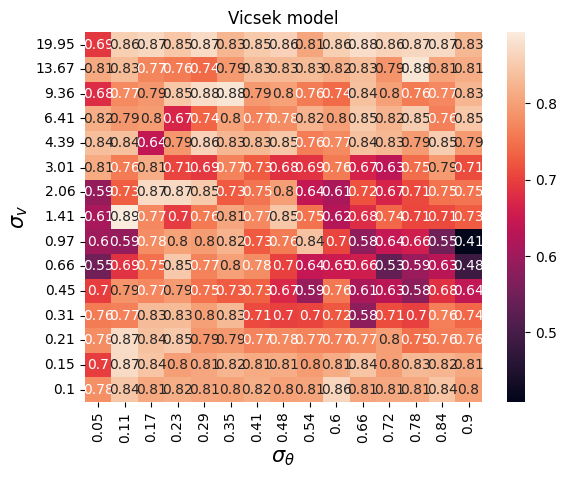

In [8]:
vicsek_correlations = pd.DataFrame(index=sigma_v_list, columns=sigma_t_list)

for sigma_v in sigma_v_list:
    for sigma_t in sigma_t_list:
        start = time.time()
        interaction_params = {
            "vicsek": {
                "rate": rate * np.ones(N),
                "sigma_v": sigma_v * np.ones(N),
                "sigma_t": sigma_t * np.ones(N),
                "interaction_length": L * np.ones(N),
            }
        }

        sim= StochasticFish_IndependentRates(
            N=N,
            Tmax=Tmax,
            arena_size=arena_size,
            interaction_params=interaction_params,
            vscale=v_scale,
        )
        sim.simulate()

        sim_object, derivedDF = get_predictors_from_sim(
            sim,
            grid_size=grid_size,
            frames_skipped=None,
            leeway=leeway,
            verbose=False,
            grid_sampling_fraction=grid_sampling_fraction,
            window_size_multiplier=window_size_multiplier,
            score_kwargs = score_kwargs
        )

        # save correlation
        vicsek_correlations.loc[sigma_v, sigma_t] = derivedDF.corr(method="spearman").loc[
            "vicsek", "pairwiseCopying"
        ]
        end = time.time()
        derivation_logger.info(f"[sigma_v={sigma_v},sigma_t={sigma_t}] generated in {end-start:.2f} seconds.")
        print("-"*50)

vicsek_correlations = vicsek_correlations.astype(float)
sns.heatmap(vicsek_correlations, annot=True)
plt.xlabel(r"$\sigma_{\theta}$",fontsize=15)
plt.ylabel(r"$\sigma_v$",fontsize=15)
plt.gca().invert_yaxis()
plt.title("Vicsek model")

plt.show()

# Pairwise copying

Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:35:34,323 - Local windows completed in 8.23 seconds.
2024-10-09 02:35:49,734 - vicsek completed in 15.41 seconds.
2024-10-09 02:36:18,653 - pairwiseCopying completed in 28.92 seconds.
2024-10-09 02:36:26,452 - velocityDiffusion completed in 7.80 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156217 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:36:27,083 - derivedDF generated in 0.63 seconds.
2024-10-09 02:36:27,184 - [sigma_v=0.1,sigma_t=0.05] generated in 62.98 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:36:37,049 - Local windows completed in 8.02 seconds.
2024-10-09 02:36:52,516 - vicsek completed in 15.47 seconds.
2024-10-09 02:37:24,166 - pairwiseCopying completed in 31.65 seconds.
2024-10-09 02:37:32,070 - velocityDiffusion completed in 7.90 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151461 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:37:32,403 - derivedDF generated in 0.33 seconds.
2024-10-09 02:37:32,523 - [sigma_v=0.1,sigma_t=0.11] generated in 65.34 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:37:42,622 - Local windows completed in 8.19 seconds.
2024-10-09 02:37:58,117 - vicsek completed in 15.49 seconds.
2024-10-09 02:38:28,352 - pairwiseCopying completed in 30.23 seconds.
2024-10-09 02:38:36,134 - velocityDiffusion completed in 7.78 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152389 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:38:36,454 - derivedDF generated in 0.32 seconds.
2024-10-09 02:38:36,579 - [sigma_v=0.1,sigma_t=0.17] generated in 64.06 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:38:46,552 - Local windows completed in 8.13 seconds.
2024-10-09 02:39:02,275 - vicsek completed in 15.72 seconds.
2024-10-09 02:39:31,171 - pairwiseCopying completed in 28.89 seconds.
2024-10-09 02:39:38,976 - velocityDiffusion completed in 7.80 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156278 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:39:39,602 - derivedDF generated in 0.63 seconds.
2024-10-09 02:39:39,733 - [sigma_v=0.1,sigma_t=0.23] generated in 63.15 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:39:49,493 - Local windows completed in 7.87 seconds.
2024-10-09 02:40:05,048 - vicsek completed in 15.55 seconds.
2024-10-09 02:40:34,194 - pairwiseCopying completed in 29.15 seconds.
2024-10-09 02:40:41,991 - velocityDiffusion completed in 7.80 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155692 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:40:42,316 - derivedDF generated in 0.32 seconds.
2024-10-09 02:40:42,448 - [sigma_v=0.1,sigma_t=0.29] generated in 62.71 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:40:52,501 - Local windows completed in 8.20 seconds.
2024-10-09 02:41:08,125 - vicsek completed in 15.62 seconds.
2024-10-09 02:41:37,237 - pairwiseCopying completed in 29.11 seconds.
2024-10-09 02:41:45,095 - velocityDiffusion completed in 7.86 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156544 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:41:45,418 - derivedDF generated in 0.32 seconds.
2024-10-09 02:41:45,547 - [sigma_v=0.1,sigma_t=0.35] generated in 63.10 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:41:55,449 - Local windows completed in 8.07 seconds.
2024-10-09 02:42:10,884 - vicsek completed in 15.43 seconds.
2024-10-09 02:42:39,863 - pairwiseCopying completed in 28.98 seconds.
2024-10-09 02:42:47,670 - velocityDiffusion completed in 7.81 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154975 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:42:47,995 - derivedDF generated in 0.32 seconds.
2024-10-09 02:42:48,125 - [sigma_v=0.1,sigma_t=0.41] generated in 62.58 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:42:58,146 - Local windows completed in 8.05 seconds.
2024-10-09 02:43:13,539 - vicsek completed in 15.39 seconds.
2024-10-09 02:43:43,720 - pairwiseCopying completed in 30.18 seconds.
2024-10-09 02:43:51,477 - velocityDiffusion completed in 7.76 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154817 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:43:52,111 - derivedDF generated in 0.63 seconds.
2024-10-09 02:43:52,234 - [sigma_v=0.1,sigma_t=0.48] generated in 64.11 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:44:01,970 - Local windows completed in 7.85 seconds.
2024-10-09 02:44:17,624 - vicsek completed in 15.65 seconds.
2024-10-09 02:44:46,839 - pairwiseCopying completed in 29.21 seconds.
2024-10-09 02:44:54,736 - velocityDiffusion completed in 7.90 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153035 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:44:55,061 - derivedDF generated in 0.32 seconds.
2024-10-09 02:44:55,183 - [sigma_v=0.1,sigma_t=0.54] generated in 62.95 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4085 (10.21%)
Number pairwiseCopying interactions with more than 1 neighbor: 3839 (93.98%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:45:05,100 - Local windows completed in 8.07 seconds.
2024-10-09 02:45:19,933 - vicsek completed in 14.83 seconds.
2024-10-09 02:45:44,937 - pairwiseCopying completed in 25.00 seconds.
2024-10-09 02:45:52,630 - velocityDiffusion completed in 7.69 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/157126 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:45:52,960 - derivedDF generated in 0.33 seconds.
2024-10-09 02:45:53,151 - [sigma_v=0.1,sigma_t=0.6] generated in 57.97 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:46:03,119 - Local windows completed in 8.08 seconds.
2024-10-09 02:46:18,505 - vicsek completed in 15.39 seconds.
2024-10-09 02:46:45,227 - pairwiseCopying completed in 26.72 seconds.
2024-10-09 02:46:52,976 - velocityDiffusion completed in 7.75 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/158666 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:46:53,300 - derivedDF generated in 0.32 seconds.
2024-10-09 02:46:53,421 - [sigma_v=0.1,sigma_t=0.66] generated in 60.27 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:47:03,519 - Local windows completed in 8.22 seconds.
2024-10-09 02:47:19,540 - vicsek completed in 16.02 seconds.
2024-10-09 02:47:48,068 - pairwiseCopying completed in 28.53 seconds.
2024-10-09 02:47:56,021 - velocityDiffusion completed in 7.95 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/162244 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:47:56,364 - derivedDF generated in 0.34 seconds.
2024-10-09 02:47:56,503 - [sigma_v=0.1,sigma_t=0.72] generated in 63.08 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4072 (10.18%)
Number pairwiseCopying interactions with more than 1 neighbor: 4026 (98.87%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:48:06,756 - Local windows completed in 8.41 seconds.
2024-10-09 02:48:22,715 - vicsek completed in 15.96 seconds.
2024-10-09 02:48:51,948 - pairwiseCopying completed in 29.23 seconds.
2024-10-09 02:48:59,953 - velocityDiffusion completed in 8.00 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/160125 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:49:00,612 - derivedDF generated in 0.66 seconds.
2024-10-09 02:49:00,744 - [sigma_v=0.1,sigma_t=0.78] generated in 64.24 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:49:11,071 - Local windows completed in 8.43 seconds.
2024-10-09 02:49:27,283 - vicsek completed in 16.21 seconds.
2024-10-09 02:49:56,737 - pairwiseCopying completed in 29.45 seconds.
2024-10-09 02:50:04,776 - velocityDiffusion completed in 8.04 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156012 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:50:05,113 - derivedDF generated in 0.34 seconds.
2024-10-09 02:50:05,240 - [sigma_v=0.1,sigma_t=0.84] generated in 64.49 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:50:15,404 - Local windows completed in 8.29 seconds.
2024-10-09 02:50:31,924 - vicsek completed in 16.52 seconds.
2024-10-09 02:51:01,531 - pairwiseCopying completed in 29.61 seconds.
2024-10-09 02:51:09,633 - velocityDiffusion completed in 8.10 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154501 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:51:09,974 - derivedDF generated in 0.34 seconds.
2024-10-09 02:51:10,098 - [sigma_v=0.1,sigma_t=0.9] generated in 64.86 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:51:20,203 - Local windows completed in 8.23 seconds.
2024-10-09 02:51:37,178 - vicsek completed in 16.97 seconds.
2024-10-09 02:52:07,981 - pairwiseCopying completed in 30.80 seconds.
2024-10-09 02:52:16,287 - velocityDiffusion completed in 8.31 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155427 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:52:16,629 - derivedDF generated in 0.34 seconds.
2024-10-09 02:52:16,740 - [sigma_v=0.15,sigma_t=0.05] generated in 66.64 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:52:27,346 - Local windows completed in 8.71 seconds.
2024-10-09 02:52:43,958 - vicsek completed in 16.61 seconds.
2024-10-09 02:53:14,630 - pairwiseCopying completed in 30.67 seconds.
2024-10-09 02:53:22,892 - velocityDiffusion completed in 8.26 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154485 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:53:23,231 - derivedDF generated in 0.34 seconds.
2024-10-09 02:53:23,364 - [sigma_v=0.15,sigma_t=0.11] generated in 66.62 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:53:34,042 - Local windows completed in 8.74 seconds.
2024-10-09 02:53:51,749 - vicsek completed in 17.71 seconds.
2024-10-09 02:54:21,173 - pairwiseCopying completed in 29.42 seconds.
2024-10-09 02:54:29,066 - velocityDiffusion completed in 7.89 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156421 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:54:29,391 - derivedDF generated in 0.32 seconds.
2024-10-09 02:54:29,527 - [sigma_v=0.15,sigma_t=0.17] generated in 66.16 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:54:39,483 - Local windows completed in 8.10 seconds.
2024-10-09 02:54:54,944 - vicsek completed in 15.46 seconds.
2024-10-09 02:55:23,780 - pairwiseCopying completed in 28.84 seconds.
2024-10-09 02:55:31,551 - velocityDiffusion completed in 7.77 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153849 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:55:31,977 - derivedDF generated in 0.42 seconds.
2024-10-09 02:55:32,115 - [sigma_v=0.15,sigma_t=0.23] generated in 62.59 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:55:42,034 - Local windows completed in 8.07 seconds.
2024-10-09 02:55:57,547 - vicsek completed in 15.51 seconds.
2024-10-09 02:56:26,405 - pairwiseCopying completed in 28.86 seconds.
2024-10-09 02:56:34,222 - velocityDiffusion completed in 7.82 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153798 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:56:34,547 - derivedDF generated in 0.32 seconds.
2024-10-09 02:56:34,677 - [sigma_v=0.15,sigma_t=0.29] generated in 62.56 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4088 (10.22%)
Number pairwiseCopying interactions with more than 1 neighbor: 4015 (98.21%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:56:44,754 - Local windows completed in 8.22 seconds.
2024-10-09 02:57:00,522 - vicsek completed in 15.77 seconds.
2024-10-09 02:57:28,366 - pairwiseCopying completed in 27.84 seconds.
2024-10-09 02:57:36,478 - velocityDiffusion completed in 8.11 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/148717 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:57:37,103 - derivedDF generated in 0.62 seconds.
2024-10-09 02:57:37,232 - [sigma_v=0.15,sigma_t=0.35] generated in 62.55 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:57:46,982 - Local windows completed in 7.87 seconds.
2024-10-09 02:58:02,386 - vicsek completed in 15.40 seconds.
2024-10-09 02:58:31,522 - pairwiseCopying completed in 29.14 seconds.
2024-10-09 02:58:39,309 - velocityDiffusion completed in 7.79 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/157351 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:58:39,635 - derivedDF generated in 0.32 seconds.
2024-10-09 02:58:39,768 - [sigma_v=0.15,sigma_t=0.41] generated in 62.54 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4229 (10.57%)
Number pairwiseCopying interactions with more than 1 neighbor: 3532 (83.52%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:58:50,784 - Local windows completed in 9.14 seconds.
2024-10-09 02:59:05,383 - vicsek completed in 14.60 seconds.
2024-10-09 02:59:28,662 - pairwiseCopying completed in 23.28 seconds.
2024-10-09 02:59:36,608 - velocityDiffusion completed in 7.95 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/148863 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 02:59:36,935 - derivedDF generated in 0.33 seconds.
2024-10-09 02:59:37,060 - [sigma_v=0.15,sigma_t=0.48] generated in 57.29 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 02:59:47,041 - Local windows completed in 8.14 seconds.
2024-10-09 03:00:02,451 - vicsek completed in 15.41 seconds.
2024-10-09 03:00:31,496 - pairwiseCopying completed in 29.04 seconds.
2024-10-09 03:00:39,407 - velocityDiffusion completed in 7.91 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/159496 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:00:39,737 - derivedDF generated in 0.33 seconds.
2024-10-09 03:00:39,866 - [sigma_v=0.15,sigma_t=0.54] generated in 62.80 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:00:50,881 - Local windows completed in 9.06 seconds.
2024-10-09 03:01:07,050 - vicsek completed in 16.17 seconds.
2024-10-09 03:01:34,166 - pairwiseCopying completed in 27.12 seconds.
2024-10-09 03:01:41,928 - velocityDiffusion completed in 7.76 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/158723 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:01:42,253 - derivedDF generated in 0.32 seconds.
2024-10-09 03:01:42,382 - [sigma_v=0.15,sigma_t=0.6] generated in 62.51 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:01:52,385 - Local windows completed in 8.16 seconds.
2024-10-09 03:02:07,697 - vicsek completed in 15.31 seconds.
2024-10-09 03:02:34,754 - pairwiseCopying completed in 27.06 seconds.
2024-10-09 03:02:42,477 - velocityDiffusion completed in 7.72 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/159295 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:02:43,103 - derivedDF generated in 0.63 seconds.
2024-10-09 03:02:43,237 - [sigma_v=0.15,sigma_t=0.66] generated in 60.85 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:02:52,973 - Local windows completed in 7.87 seconds.
2024-10-09 03:03:08,195 - vicsek completed in 15.22 seconds.
2024-10-09 03:03:36,133 - pairwiseCopying completed in 27.94 seconds.
2024-10-09 03:03:43,811 - velocityDiffusion completed in 7.68 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/163172 (~0.30%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:03:44,143 - derivedDF generated in 0.33 seconds.
2024-10-09 03:03:44,289 - [sigma_v=0.15,sigma_t=0.72] generated in 61.05 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4067 (10.17%)
Number pairwiseCopying interactions with more than 1 neighbor: 4011 (98.62%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:03:54,702 - Local windows completed in 8.52 seconds.
2024-10-09 03:04:11,173 - vicsek completed in 16.47 seconds.
2024-10-09 03:04:37,809 - pairwiseCopying completed in 26.63 seconds.
2024-10-09 03:04:45,451 - velocityDiffusion completed in 7.64 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/164648 (~0.30%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:04:45,779 - derivedDF generated in 0.33 seconds.
2024-10-09 03:04:45,918 - [sigma_v=0.15,sigma_t=0.78] generated in 61.63 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:04:55,888 - Local windows completed in 8.11 seconds.
2024-10-09 03:05:11,039 - vicsek completed in 15.15 seconds.
2024-10-09 03:05:37,389 - pairwiseCopying completed in 26.35 seconds.
2024-10-09 03:05:44,825 - velocityDiffusion completed in 7.43 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154569 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:05:45,149 - derivedDF generated in 0.32 seconds.
2024-10-09 03:05:45,277 - [sigma_v=0.15,sigma_t=0.84] generated in 59.36 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:05:55,216 - Local windows completed in 8.09 seconds.
2024-10-09 03:06:10,443 - vicsek completed in 15.23 seconds.
2024-10-09 03:06:37,755 - pairwiseCopying completed in 27.31 seconds.
2024-10-09 03:06:45,123 - velocityDiffusion completed in 7.37 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/159395 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:06:45,448 - derivedDF generated in 0.32 seconds.
2024-10-09 03:06:45,579 - [sigma_v=0.15,sigma_t=0.9] generated in 60.30 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:06:55,670 - Local windows completed in 8.25 seconds.
2024-10-09 03:07:10,937 - vicsek completed in 15.27 seconds.
2024-10-09 03:07:39,439 - pairwiseCopying completed in 28.50 seconds.
2024-10-09 03:07:47,107 - velocityDiffusion completed in 7.67 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155422 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:07:47,432 - derivedDF generated in 0.32 seconds.
2024-10-09 03:07:47,541 - [sigma_v=0.21,sigma_t=0.05] generated in 61.96 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:07:57,536 - Local windows completed in 8.13 seconds.
2024-10-09 03:08:12,886 - vicsek completed in 15.35 seconds.
2024-10-09 03:08:41,444 - pairwiseCopying completed in 28.56 seconds.
2024-10-09 03:08:49,220 - velocityDiffusion completed in 7.77 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156612 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:08:49,856 - derivedDF generated in 0.64 seconds.
2024-10-09 03:08:49,995 - [sigma_v=0.21,sigma_t=0.11] generated in 62.45 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:08:59,713 - Local windows completed in 7.88 seconds.
2024-10-09 03:09:16,127 - vicsek completed in 16.41 seconds.
2024-10-09 03:09:44,921 - pairwiseCopying completed in 28.79 seconds.
2024-10-09 03:09:52,608 - velocityDiffusion completed in 7.69 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156932 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:09:52,933 - derivedDF generated in 0.32 seconds.
2024-10-09 03:09:53,061 - [sigma_v=0.21,sigma_t=0.17] generated in 63.06 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:10:03,026 - Local windows completed in 8.06 seconds.
2024-10-09 03:10:18,293 - vicsek completed in 15.27 seconds.
2024-10-09 03:10:46,984 - pairwiseCopying completed in 28.69 seconds.
2024-10-09 03:10:54,621 - velocityDiffusion completed in 7.64 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152174 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:10:55,278 - derivedDF generated in 0.66 seconds.
2024-10-09 03:10:55,407 - [sigma_v=0.21,sigma_t=0.23] generated in 62.34 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:11:05,605 - Local windows completed in 8.22 seconds.
2024-10-09 03:11:20,852 - vicsek completed in 15.25 seconds.
2024-10-09 03:11:49,344 - pairwiseCopying completed in 28.49 seconds.
2024-10-09 03:11:56,963 - velocityDiffusion completed in 7.62 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152450 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:11:57,290 - derivedDF generated in 0.33 seconds.
2024-10-09 03:11:57,419 - [sigma_v=0.21,sigma_t=0.29] generated in 62.01 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:12:07,840 - Local windows completed in 8.55 seconds.
2024-10-09 03:12:24,702 - vicsek completed in 16.86 seconds.
2024-10-09 03:12:55,089 - pairwiseCopying completed in 30.39 seconds.
2024-10-09 03:13:02,968 - velocityDiffusion completed in 7.88 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156368 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:13:03,298 - derivedDF generated in 0.33 seconds.
2024-10-09 03:13:03,432 - [sigma_v=0.21,sigma_t=0.35] generated in 66.01 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:13:13,614 - Local windows completed in 8.32 seconds.
2024-10-09 03:13:29,553 - vicsek completed in 15.94 seconds.
2024-10-09 03:13:58,828 - pairwiseCopying completed in 29.27 seconds.
2024-10-09 03:14:06,544 - velocityDiffusion completed in 7.71 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154242 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:14:06,872 - derivedDF generated in 0.33 seconds.
2024-10-09 03:14:06,998 - [sigma_v=0.21,sigma_t=0.41] generated in 63.57 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:14:18,753 - Local windows completed in 9.92 seconds.
2024-10-09 03:14:34,909 - vicsek completed in 16.16 seconds.
2024-10-09 03:15:03,512 - pairwiseCopying completed in 28.60 seconds.
2024-10-09 03:15:11,762 - velocityDiffusion completed in 8.25 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155051 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:15:12,082 - derivedDF generated in 0.32 seconds.
2024-10-09 03:15:12,209 - [sigma_v=0.21,sigma_t=0.48] generated in 65.21 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:15:22,133 - Local windows completed in 8.08 seconds.
2024-10-09 03:15:37,444 - vicsek completed in 15.31 seconds.
2024-10-09 03:16:04,961 - pairwiseCopying completed in 27.52 seconds.
2024-10-09 03:16:12,310 - velocityDiffusion completed in 7.35 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/158698 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:16:12,636 - derivedDF generated in 0.32 seconds.
2024-10-09 03:16:12,762 - [sigma_v=0.21,sigma_t=0.54] generated in 60.55 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:16:22,710 - Local windows completed in 8.11 seconds.
2024-10-09 03:16:37,743 - vicsek completed in 15.03 seconds.
2024-10-09 03:17:05,153 - pairwiseCopying completed in 27.41 seconds.
2024-10-09 03:17:12,447 - velocityDiffusion completed in 7.29 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156366 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:17:12,771 - derivedDF generated in 0.32 seconds.
2024-10-09 03:17:12,898 - [sigma_v=0.21,sigma_t=0.6] generated in 60.13 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:17:22,913 - Local windows completed in 8.15 seconds.
2024-10-09 03:17:37,914 - vicsek completed in 15.00 seconds.
2024-10-09 03:18:05,083 - pairwiseCopying completed in 27.17 seconds.
2024-10-09 03:18:12,448 - velocityDiffusion completed in 7.36 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/158874 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:18:12,771 - derivedDF generated in 0.32 seconds.
2024-10-09 03:18:12,901 - [sigma_v=0.21,sigma_t=0.66] generated in 60.00 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:18:22,868 - Local windows completed in 8.06 seconds.
2024-10-09 03:18:37,981 - vicsek completed in 15.11 seconds.
2024-10-09 03:19:05,070 - pairwiseCopying completed in 27.09 seconds.
2024-10-09 03:19:12,473 - velocityDiffusion completed in 7.40 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/161948 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:19:13,102 - derivedDF generated in 0.63 seconds.
2024-10-09 03:19:13,245 - [sigma_v=0.21,sigma_t=0.72] generated in 60.34 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:19:23,354 - Local windows completed in 8.27 seconds.
2024-10-09 03:19:39,342 - vicsek completed in 15.99 seconds.
2024-10-09 03:20:06,195 - pairwiseCopying completed in 26.85 seconds.
2024-10-09 03:20:13,662 - velocityDiffusion completed in 7.47 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/162278 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:20:14,025 - derivedDF generated in 0.36 seconds.
2024-10-09 03:20:14,161 - [sigma_v=0.21,sigma_t=0.78] generated in 60.92 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:20:24,081 - Local windows completed in 8.09 seconds.
2024-10-09 03:20:39,141 - vicsek completed in 15.06 seconds.
2024-10-09 03:21:05,839 - pairwiseCopying completed in 26.70 seconds.
2024-10-09 03:21:13,243 - velocityDiffusion completed in 7.40 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/148841 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:21:13,567 - derivedDF generated in 0.32 seconds.
2024-10-09 03:21:13,691 - [sigma_v=0.21,sigma_t=0.84] generated in 59.53 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:21:23,737 - Local windows completed in 8.15 seconds.
2024-10-09 03:21:38,776 - vicsek completed in 15.04 seconds.
2024-10-09 03:22:06,228 - pairwiseCopying completed in 27.45 seconds.
2024-10-09 03:22:13,701 - velocityDiffusion completed in 7.47 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/160092 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:22:14,021 - derivedDF generated in 0.32 seconds.
2024-10-09 03:22:14,151 - [sigma_v=0.21,sigma_t=0.9] generated in 60.46 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:22:24,251 - Local windows completed in 8.25 seconds.
2024-10-09 03:22:39,076 - vicsek completed in 14.82 seconds.
2024-10-09 03:23:06,183 - pairwiseCopying completed in 27.11 seconds.
2024-10-09 03:23:13,532 - velocityDiffusion completed in 7.35 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/158921 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:23:14,160 - derivedDF generated in 0.63 seconds.
2024-10-09 03:23:14,268 - [sigma_v=0.31,sigma_t=0.05] generated in 60.12 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:23:24,039 - Local windows completed in 7.94 seconds.
2024-10-09 03:23:38,923 - vicsek completed in 14.88 seconds.
2024-10-09 03:24:05,872 - pairwiseCopying completed in 26.95 seconds.
2024-10-09 03:24:13,254 - velocityDiffusion completed in 7.38 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/157739 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:24:13,577 - derivedDF generated in 0.32 seconds.
2024-10-09 03:24:13,703 - [sigma_v=0.31,sigma_t=0.11] generated in 59.43 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:24:23,645 - Local windows completed in 8.10 seconds.
2024-10-09 03:24:39,735 - vicsek completed in 16.09 seconds.
2024-10-09 03:25:07,039 - pairwiseCopying completed in 27.30 seconds.
2024-10-09 03:25:14,633 - velocityDiffusion completed in 7.59 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156181 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:25:14,978 - derivedDF generated in 0.34 seconds.
2024-10-09 03:25:15,109 - [sigma_v=0.31,sigma_t=0.17] generated in 61.40 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:25:25,177 - Local windows completed in 8.20 seconds.
2024-10-09 03:25:40,153 - vicsek completed in 14.98 seconds.
2024-10-09 03:26:07,226 - pairwiseCopying completed in 27.07 seconds.
2024-10-09 03:26:14,406 - velocityDiffusion completed in 7.18 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/157722 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:26:14,729 - derivedDF generated in 0.32 seconds.
2024-10-09 03:26:14,860 - [sigma_v=0.31,sigma_t=0.23] generated in 59.75 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4045 (10.11%)
Number pairwiseCopying interactions with more than 1 neighbor: 3912 (96.71%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:26:24,813 - Local windows completed in 8.15 seconds.
2024-10-09 03:26:39,945 - vicsek completed in 15.13 seconds.
2024-10-09 03:27:06,626 - pairwiseCopying completed in 26.68 seconds.
2024-10-09 03:27:14,375 - velocityDiffusion completed in 7.75 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151271 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:27:14,999 - derivedDF generated in 0.62 seconds.
2024-10-09 03:27:15,130 - [sigma_v=0.31,sigma_t=0.29] generated in 60.27 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:27:25,102 - Local windows completed in 7.99 seconds.
2024-10-09 03:27:39,865 - vicsek completed in 14.76 seconds.
2024-10-09 03:28:06,603 - pairwiseCopying completed in 26.74 seconds.
2024-10-09 03:28:13,695 - velocityDiffusion completed in 7.09 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/144613 (~0.34%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:28:14,085 - derivedDF generated in 0.39 seconds.
2024-10-09 03:28:14,208 - [sigma_v=0.31,sigma_t=0.35] generated in 59.08 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:28:24,129 - Local windows completed in 8.09 seconds.
2024-10-09 03:28:38,633 - vicsek completed in 14.50 seconds.
2024-10-09 03:29:05,105 - pairwiseCopying completed in 26.47 seconds.
2024-10-09 03:29:12,094 - velocityDiffusion completed in 6.99 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153786 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:29:12,424 - derivedDF generated in 0.33 seconds.
2024-10-09 03:29:12,548 - [sigma_v=0.31,sigma_t=0.41] generated in 58.34 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:29:22,654 - Local windows completed in 8.26 seconds.
2024-10-09 03:29:37,891 - vicsek completed in 15.24 seconds.
2024-10-09 03:30:04,569 - pairwiseCopying completed in 26.68 seconds.
2024-10-09 03:30:12,087 - velocityDiffusion completed in 7.52 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152309 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:30:12,411 - derivedDF generated in 0.32 seconds.
2024-10-09 03:30:12,537 - [sigma_v=0.31,sigma_t=0.48] generated in 59.99 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:30:22,456 - Local windows completed in 8.08 seconds.
2024-10-09 03:30:37,112 - vicsek completed in 14.65 seconds.
2024-10-09 03:31:03,735 - pairwiseCopying completed in 26.62 seconds.
2024-10-09 03:31:10,633 - velocityDiffusion completed in 6.90 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/159684 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:31:10,959 - derivedDF generated in 0.33 seconds.
2024-10-09 03:31:11,087 - [sigma_v=0.31,sigma_t=0.54] generated in 58.55 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4219 (10.55%)
Number pairwiseCopying interactions with more than 1 neighbor: 3521 (83.46%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:31:21,095 - Local windows completed in 8.06 seconds.
2024-10-09 03:31:34,930 - vicsek completed in 13.83 seconds.
2024-10-09 03:31:56,818 - pairwiseCopying completed in 21.89 seconds.
2024-10-09 03:32:04,302 - velocityDiffusion completed in 7.48 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154626 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:32:04,927 - derivedDF generated in 0.62 seconds.
2024-10-09 03:32:05,052 - [sigma_v=0.31,sigma_t=0.6] generated in 53.96 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4107 (10.27%)
Number pairwiseCopying interactions with more than 1 neighbor: 4019 (97.86%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:32:14,803 - Local windows completed in 7.92 seconds.
2024-10-09 03:32:28,806 - vicsek completed in 14.00 seconds.
2024-10-09 03:32:52,625 - pairwiseCopying completed in 23.82 seconds.
2024-10-09 03:32:59,056 - velocityDiffusion completed in 6.43 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156643 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:32:59,385 - derivedDF generated in 0.33 seconds.
2024-10-09 03:32:59,512 - [sigma_v=0.31,sigma_t=0.66] generated in 54.46 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:33:09,349 - Local windows completed in 7.96 seconds.
2024-10-09 03:33:24,206 - vicsek completed in 14.86 seconds.
2024-10-09 03:33:49,154 - pairwiseCopying completed in 24.95 seconds.
2024-10-09 03:33:56,468 - velocityDiffusion completed in 7.31 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/163235 (~0.30%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:33:56,795 - derivedDF generated in 0.33 seconds.
2024-10-09 03:33:56,935 - [sigma_v=0.31,sigma_t=0.72] generated in 57.42 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:34:06,605 - Local windows completed in 7.85 seconds.
2024-10-09 03:34:21,569 - vicsek completed in 14.96 seconds.
2024-10-09 03:34:46,384 - pairwiseCopying completed in 24.81 seconds.
2024-10-09 03:34:54,572 - velocityDiffusion completed in 8.19 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/163717 (~0.30%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:34:54,901 - derivedDF generated in 0.33 seconds.
2024-10-09 03:34:55,041 - [sigma_v=0.31,sigma_t=0.78] generated in 58.11 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4079 (10.20%)
Number pairwiseCopying interactions with more than 1 neighbor: 3441 (84.36%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:35:04,901 - Local windows completed in 8.01 seconds.
2024-10-09 03:35:19,449 - vicsek completed in 14.55 seconds.
2024-10-09 03:35:41,979 - pairwiseCopying completed in 22.53 seconds.
2024-10-09 03:35:49,323 - velocityDiffusion completed in 7.34 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/157793 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:35:49,651 - derivedDF generated in 0.33 seconds.
2024-10-09 03:35:49,776 - [sigma_v=0.31,sigma_t=0.84] generated in 54.73 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4070 (10.17%)
Number pairwiseCopying interactions with more than 1 neighbor: 4034 (99.12%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:35:59,605 - Local windows completed in 7.88 seconds.
2024-10-09 03:36:14,744 - vicsek completed in 15.14 seconds.
2024-10-09 03:36:39,830 - pairwiseCopying completed in 25.09 seconds.
2024-10-09 03:36:47,560 - velocityDiffusion completed in 7.73 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/158574 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:36:47,896 - derivedDF generated in 0.34 seconds.
2024-10-09 03:36:48,025 - [sigma_v=0.31,sigma_t=0.9] generated in 58.25 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:36:57,774 - Local windows completed in 7.91 seconds.
2024-10-09 03:37:12,125 - vicsek completed in 14.35 seconds.
2024-10-09 03:37:37,275 - pairwiseCopying completed in 25.15 seconds.
2024-10-09 03:37:44,198 - velocityDiffusion completed in 6.92 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/158843 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:37:44,529 - derivedDF generated in 0.33 seconds.
2024-10-09 03:37:44,640 - [sigma_v=0.45,sigma_t=0.05] generated in 56.61 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:37:54,521 - Local windows completed in 8.02 seconds.
2024-10-09 03:38:08,522 - vicsek completed in 14.00 seconds.
2024-10-09 03:38:33,821 - pairwiseCopying completed in 25.30 seconds.
2024-10-09 03:38:40,518 - velocityDiffusion completed in 6.70 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/148154 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:38:41,138 - derivedDF generated in 0.62 seconds.
2024-10-09 03:38:41,258 - [sigma_v=0.45,sigma_t=0.11] generated in 56.62 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:38:50,914 - Local windows completed in 7.83 seconds.
2024-10-09 03:39:05,052 - vicsek completed in 14.14 seconds.
2024-10-09 03:39:30,373 - pairwiseCopying completed in 25.32 seconds.
2024-10-09 03:39:36,933 - velocityDiffusion completed in 6.56 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152063 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:39:37,260 - derivedDF generated in 0.33 seconds.
2024-10-09 03:39:37,382 - [sigma_v=0.45,sigma_t=0.17] generated in 56.12 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:39:47,342 - Local windows completed in 8.15 seconds.
2024-10-09 03:40:02,442 - vicsek completed in 15.10 seconds.
2024-10-09 03:40:28,134 - pairwiseCopying completed in 25.69 seconds.
2024-10-09 03:40:34,867 - velocityDiffusion completed in 6.73 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155863 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:40:35,190 - derivedDF generated in 0.32 seconds.
2024-10-09 03:40:35,311 - [sigma_v=0.45,sigma_t=0.23] generated in 57.93 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:40:45,010 - Local windows completed in 7.86 seconds.
2024-10-09 03:40:59,472 - vicsek completed in 14.46 seconds.
2024-10-09 03:41:24,525 - pairwiseCopying completed in 25.05 seconds.
2024-10-09 03:41:31,222 - velocityDiffusion completed in 6.70 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150594 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:41:31,544 - derivedDF generated in 0.32 seconds.
2024-10-09 03:41:31,664 - [sigma_v=0.45,sigma_t=0.29] generated in 56.35 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:41:41,429 - Local windows completed in 7.93 seconds.
2024-10-09 03:41:55,631 - vicsek completed in 14.20 seconds.
2024-10-09 03:42:20,578 - pairwiseCopying completed in 24.95 seconds.
2024-10-09 03:42:27,130 - velocityDiffusion completed in 6.55 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153229 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:42:27,454 - derivedDF generated in 0.32 seconds.
2024-10-09 03:42:27,579 - [sigma_v=0.45,sigma_t=0.35] generated in 55.91 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:42:37,378 - Local windows completed in 7.98 seconds.
2024-10-09 03:42:51,519 - vicsek completed in 14.14 seconds.
2024-10-09 03:43:16,182 - pairwiseCopying completed in 24.66 seconds.
2024-10-09 03:43:22,935 - velocityDiffusion completed in 6.75 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/157057 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:43:23,257 - derivedDF generated in 0.32 seconds.
2024-10-09 03:43:23,380 - [sigma_v=0.45,sigma_t=0.41] generated in 55.80 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:43:33,220 - Local windows completed in 7.99 seconds.
2024-10-09 03:43:47,297 - vicsek completed in 14.08 seconds.
2024-10-09 03:44:11,648 - pairwiseCopying completed in 24.35 seconds.
2024-10-09 03:44:18,444 - velocityDiffusion completed in 6.79 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151646 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:44:18,763 - derivedDF generated in 0.32 seconds.
2024-10-09 03:44:18,888 - [sigma_v=0.45,sigma_t=0.48] generated in 55.51 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:44:28,710 - Local windows completed in 7.97 seconds.
2024-10-09 03:44:43,036 - vicsek completed in 14.33 seconds.
2024-10-09 03:45:08,190 - pairwiseCopying completed in 25.15 seconds.
2024-10-09 03:45:14,993 - velocityDiffusion completed in 6.80 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/162106 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:45:15,324 - derivedDF generated in 0.33 seconds.
2024-10-09 03:45:15,461 - [sigma_v=0.45,sigma_t=0.54] generated in 56.57 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:45:25,555 - Local windows completed in 8.00 seconds.
2024-10-09 03:45:39,292 - vicsek completed in 13.74 seconds.
2024-10-09 03:46:03,089 - pairwiseCopying completed in 23.80 seconds.
2024-10-09 03:46:09,470 - velocityDiffusion completed in 6.38 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/161895 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:46:10,092 - derivedDF generated in 0.62 seconds.
2024-10-09 03:46:10,220 - [sigma_v=0.45,sigma_t=0.6] generated in 54.76 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:46:19,907 - Local windows completed in 7.87 seconds.
2024-10-09 03:46:33,697 - vicsek completed in 13.79 seconds.
2024-10-09 03:46:58,044 - pairwiseCopying completed in 24.35 seconds.
2024-10-09 03:47:04,392 - velocityDiffusion completed in 6.35 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/161409 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:47:04,719 - derivedDF generated in 0.33 seconds.
2024-10-09 03:47:04,845 - [sigma_v=0.45,sigma_t=0.66] generated in 54.62 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:47:14,740 - Local windows completed in 8.07 seconds.
2024-10-09 03:47:28,427 - vicsek completed in 13.69 seconds.
2024-10-09 03:47:51,623 - pairwiseCopying completed in 23.20 seconds.
2024-10-09 03:47:57,750 - velocityDiffusion completed in 6.13 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/165388 (~0.30%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:47:58,076 - derivedDF generated in 0.33 seconds.
2024-10-09 03:47:58,205 - [sigma_v=0.45,sigma_t=0.72] generated in 53.36 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:48:08,178 - Local windows completed in 8.15 seconds.
2024-10-09 03:48:22,237 - vicsek completed in 14.06 seconds.
2024-10-09 03:48:45,666 - pairwiseCopying completed in 23.43 seconds.
2024-10-09 03:48:52,415 - velocityDiffusion completed in 6.75 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/162675 (~0.30%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:48:52,744 - derivedDF generated in 0.33 seconds.
2024-10-09 03:48:52,871 - [sigma_v=0.45,sigma_t=0.78] generated in 54.66 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:49:02,746 - Local windows completed in 8.07 seconds.
2024-10-09 03:49:17,031 - vicsek completed in 14.28 seconds.
2024-10-09 03:49:40,621 - pairwiseCopying completed in 23.59 seconds.
2024-10-09 03:49:47,318 - velocityDiffusion completed in 6.70 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/162091 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:49:47,650 - derivedDF generated in 0.33 seconds.
2024-10-09 03:49:47,782 - [sigma_v=0.45,sigma_t=0.84] generated in 54.91 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:49:57,488 - Local windows completed in 7.87 seconds.
2024-10-09 03:50:11,484 - vicsek completed in 14.00 seconds.
2024-10-09 03:50:37,115 - pairwiseCopying completed in 25.63 seconds.
2024-10-09 03:50:43,415 - velocityDiffusion completed in 6.30 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/158581 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:50:43,738 - derivedDF generated in 0.32 seconds.
2024-10-09 03:50:43,865 - [sigma_v=0.45,sigma_t=0.9] generated in 56.08 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:50:53,576 - Local windows completed in 7.86 seconds.
2024-10-09 03:51:07,713 - vicsek completed in 14.14 seconds.
2024-10-09 03:51:32,177 - pairwiseCopying completed in 24.46 seconds.
2024-10-09 03:51:38,509 - velocityDiffusion completed in 6.33 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155797 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:51:38,834 - derivedDF generated in 0.32 seconds.
2024-10-09 03:51:38,943 - [sigma_v=0.66,sigma_t=0.05] generated in 55.08 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:51:48,737 - Local windows completed in 7.86 seconds.
2024-10-09 03:52:02,656 - vicsek completed in 13.92 seconds.
2024-10-09 03:52:26,759 - pairwiseCopying completed in 24.10 seconds.
2024-10-09 03:52:33,317 - velocityDiffusion completed in 6.56 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156523 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:52:33,693 - derivedDF generated in 0.38 seconds.
2024-10-09 03:52:33,814 - [sigma_v=0.66,sigma_t=0.11] generated in 54.87 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:52:43,651 - Local windows completed in 8.03 seconds.
2024-10-09 03:52:57,561 - vicsek completed in 13.91 seconds.
2024-10-09 03:53:21,621 - pairwiseCopying completed in 24.06 seconds.
2024-10-09 03:53:28,178 - velocityDiffusion completed in 6.56 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153144 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:53:28,518 - derivedDF generated in 0.34 seconds.
2024-10-09 03:53:28,637 - [sigma_v=0.66,sigma_t=0.17] generated in 54.82 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:53:38,393 - Local windows completed in 7.92 seconds.
2024-10-09 03:53:52,212 - vicsek completed in 13.82 seconds.
2024-10-09 03:54:16,376 - pairwiseCopying completed in 24.16 seconds.
2024-10-09 03:54:22,763 - velocityDiffusion completed in 6.39 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153233 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:54:23,375 - derivedDF generated in 0.61 seconds.
2024-10-09 03:54:23,520 - [sigma_v=0.66,sigma_t=0.23] generated in 54.88 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:54:33,195 - Local windows completed in 7.85 seconds.
2024-10-09 03:54:46,846 - vicsek completed in 13.65 seconds.
2024-10-09 03:55:11,026 - pairwiseCopying completed in 24.18 seconds.
2024-10-09 03:55:17,209 - velocityDiffusion completed in 6.18 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156004 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:55:17,532 - derivedDF generated in 0.32 seconds.
2024-10-09 03:55:17,652 - [sigma_v=0.66,sigma_t=0.29] generated in 54.13 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:55:28,485 - Local windows completed in 8.95 seconds.
2024-10-09 03:55:42,425 - vicsek completed in 13.94 seconds.
2024-10-09 03:56:06,484 - pairwiseCopying completed in 24.06 seconds.
2024-10-09 03:56:12,739 - velocityDiffusion completed in 6.25 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151391 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:56:13,355 - derivedDF generated in 0.61 seconds.
2024-10-09 03:56:13,483 - [sigma_v=0.66,sigma_t=0.35] generated in 55.83 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:56:23,907 - Local windows completed in 8.58 seconds.
2024-10-09 03:56:37,400 - vicsek completed in 13.49 seconds.
2024-10-09 03:57:01,521 - pairwiseCopying completed in 24.12 seconds.
2024-10-09 03:57:07,709 - velocityDiffusion completed in 6.19 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156780 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:57:08,038 - derivedDF generated in 0.33 seconds.
2024-10-09 03:57:08,162 - [sigma_v=0.66,sigma_t=0.41] generated in 54.68 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:57:17,967 - Local windows completed in 7.96 seconds.
2024-10-09 03:57:31,707 - vicsek completed in 13.74 seconds.
2024-10-09 03:57:55,377 - pairwiseCopying completed in 23.67 seconds.
2024-10-09 03:58:01,470 - velocityDiffusion completed in 6.09 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/159584 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:58:01,797 - derivedDF generated in 0.33 seconds.
2024-10-09 03:58:01,923 - [sigma_v=0.66,sigma_t=0.48] generated in 53.76 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:58:11,687 - Local windows completed in 7.85 seconds.
2024-10-09 03:58:25,622 - vicsek completed in 13.93 seconds.
2024-10-09 03:58:48,500 - pairwiseCopying completed in 22.88 seconds.
2024-10-09 03:58:55,192 - velocityDiffusion completed in 6.69 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154552 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:58:55,514 - derivedDF generated in 0.32 seconds.
2024-10-09 03:58:55,635 - [sigma_v=0.66,sigma_t=0.54] generated in 53.71 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:59:05,463 - Local windows completed in 7.99 seconds.
2024-10-09 03:59:19,002 - vicsek completed in 13.54 seconds.
2024-10-09 03:59:41,275 - pairwiseCopying completed in 22.27 seconds.
2024-10-09 03:59:47,546 - velocityDiffusion completed in 6.27 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/160057 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 03:59:47,872 - derivedDF generated in 0.33 seconds.
2024-10-09 03:59:47,993 - [sigma_v=0.66,sigma_t=0.6] generated in 52.36 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 03:59:57,735 - Local windows completed in 7.84 seconds.
2024-10-09 04:00:11,277 - vicsek completed in 13.54 seconds.
2024-10-09 04:00:34,160 - pairwiseCopying completed in 22.88 seconds.
2024-10-09 04:00:41,263 - velocityDiffusion completed in 7.10 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/162819 (~0.30%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:00:41,593 - derivedDF generated in 0.33 seconds.
2024-10-09 04:00:41,728 - [sigma_v=0.66,sigma_t=0.66] generated in 53.73 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:00:51,641 - Local windows completed in 8.06 seconds.
2024-10-09 04:01:05,283 - vicsek completed in 13.64 seconds.
2024-10-09 04:01:28,309 - pairwiseCopying completed in 23.03 seconds.
2024-10-09 04:01:34,566 - velocityDiffusion completed in 6.26 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/162477 (~0.30%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:01:35,187 - derivedDF generated in 0.62 seconds.
2024-10-09 04:01:35,318 - [sigma_v=0.66,sigma_t=0.72] generated in 53.59 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:01:45,159 - Local windows completed in 7.97 seconds.
2024-10-09 04:01:58,715 - vicsek completed in 13.56 seconds.
2024-10-09 04:02:20,813 - pairwiseCopying completed in 22.10 seconds.
2024-10-09 04:02:27,012 - velocityDiffusion completed in 6.20 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/164336 (~0.30%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:02:27,345 - derivedDF generated in 0.33 seconds.
2024-10-09 04:02:27,479 - [sigma_v=0.66,sigma_t=0.78] generated in 52.16 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4027 (98.39%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:02:37,445 - Local windows completed in 8.08 seconds.
2024-10-09 04:02:51,180 - vicsek completed in 13.73 seconds.
2024-10-09 04:03:13,815 - pairwiseCopying completed in 22.63 seconds.
2024-10-09 04:03:20,190 - velocityDiffusion completed in 6.37 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/163914 (~0.30%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:03:20,520 - derivedDF generated in 0.33 seconds.
2024-10-09 04:03:20,647 - [sigma_v=0.66,sigma_t=0.84] generated in 53.17 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:03:30,685 - Local windows completed in 8.20 seconds.
2024-10-09 04:03:43,505 - vicsek completed in 12.82 seconds.
2024-10-09 04:04:05,359 - pairwiseCopying completed in 21.85 seconds.
2024-10-09 04:04:11,105 - velocityDiffusion completed in 5.74 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/162653 (~0.30%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:04:11,434 - derivedDF generated in 0.33 seconds.
2024-10-09 04:04:11,557 - [sigma_v=0.66,sigma_t=0.9] generated in 50.91 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:04:21,450 - Local windows completed in 8.07 seconds.
2024-10-09 04:04:35,715 - vicsek completed in 14.26 seconds.
2024-10-09 04:05:01,098 - pairwiseCopying completed in 25.38 seconds.
2024-10-09 04:05:07,804 - velocityDiffusion completed in 6.71 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155686 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:05:08,249 - derivedDF generated in 0.44 seconds.
2024-10-09 04:05:08,358 - [sigma_v=0.97,sigma_t=0.05] generated in 56.80 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:05:18,267 - Local windows completed in 8.08 seconds.
2024-10-09 04:05:32,579 - vicsek completed in 14.31 seconds.
2024-10-09 04:05:59,337 - pairwiseCopying completed in 26.76 seconds.
2024-10-09 04:06:05,950 - velocityDiffusion completed in 6.61 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151175 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:06:06,276 - derivedDF generated in 0.32 seconds.
2024-10-09 04:06:06,410 - [sigma_v=0.97,sigma_t=0.11] generated in 58.05 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:06:16,555 - Local windows completed in 8.16 seconds.
2024-10-09 04:06:30,777 - vicsek completed in 14.22 seconds.
2024-10-09 04:06:56,136 - pairwiseCopying completed in 25.36 seconds.
2024-10-09 04:07:02,753 - velocityDiffusion completed in 6.62 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/157837 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:07:03,082 - derivedDF generated in 0.33 seconds.
2024-10-09 04:07:03,205 - [sigma_v=0.97,sigma_t=0.17] generated in 56.79 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:07:13,120 - Local windows completed in 8.11 seconds.
2024-10-09 04:07:27,248 - vicsek completed in 14.13 seconds.
2024-10-09 04:07:52,636 - pairwiseCopying completed in 25.39 seconds.
2024-10-09 04:07:59,305 - velocityDiffusion completed in 6.67 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/157143 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:07:59,628 - derivedDF generated in 0.32 seconds.
2024-10-09 04:07:59,753 - [sigma_v=0.97,sigma_t=0.23] generated in 56.55 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:08:09,846 - Local windows completed in 8.17 seconds.
2024-10-09 04:08:24,043 - vicsek completed in 14.20 seconds.
2024-10-09 04:08:49,317 - pairwiseCopying completed in 25.27 seconds.
2024-10-09 04:08:55,889 - velocityDiffusion completed in 6.57 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/158280 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:08:56,230 - derivedDF generated in 0.34 seconds.
2024-10-09 04:08:56,357 - [sigma_v=0.97,sigma_t=0.29] generated in 56.60 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:09:06,273 - Local windows completed in 8.06 seconds.
2024-10-09 04:09:20,442 - vicsek completed in 14.17 seconds.
2024-10-09 04:09:45,557 - pairwiseCopying completed in 25.11 seconds.
2024-10-09 04:09:52,146 - velocityDiffusion completed in 6.59 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153396 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:09:52,468 - derivedDF generated in 0.32 seconds.
2024-10-09 04:09:52,591 - [sigma_v=0.97,sigma_t=0.35] generated in 56.23 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:10:02,661 - Local windows completed in 8.09 seconds.
2024-10-09 04:10:16,794 - vicsek completed in 14.13 seconds.
2024-10-09 04:10:41,902 - pairwiseCopying completed in 25.11 seconds.
2024-10-09 04:10:48,387 - velocityDiffusion completed in 6.48 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156391 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:10:48,714 - derivedDF generated in 0.33 seconds.
2024-10-09 04:10:48,841 - [sigma_v=0.97,sigma_t=0.41] generated in 56.25 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:10:59,951 - Local windows completed in 8.55 seconds.
2024-10-09 04:11:14,143 - vicsek completed in 14.19 seconds.
2024-10-09 04:11:39,023 - pairwiseCopying completed in 24.88 seconds.
2024-10-09 04:11:45,457 - velocityDiffusion completed in 6.43 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/159996 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:11:45,892 - derivedDF generated in 0.43 seconds.
2024-10-09 04:11:46,018 - [sigma_v=0.97,sigma_t=0.48] generated in 57.18 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4080 (10.20%)
Number pairwiseCopying interactions with more than 1 neighbor: 4047 (99.19%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:11:55,946 - Local windows completed in 8.08 seconds.
2024-10-09 04:12:09,890 - vicsek completed in 13.94 seconds.
2024-10-09 04:12:33,714 - pairwiseCopying completed in 23.82 seconds.
2024-10-09 04:12:40,114 - velocityDiffusion completed in 6.40 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155987 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:12:40,436 - derivedDF generated in 0.32 seconds.
2024-10-09 04:12:40,570 - [sigma_v=0.97,sigma_t=0.54] generated in 54.55 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4082 (10.20%)
Number pairwiseCopying interactions with more than 1 neighbor: 3790 (92.85%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:12:50,549 - Local windows completed in 8.11 seconds.
2024-10-09 04:13:04,537 - vicsek completed in 13.99 seconds.
2024-10-09 04:13:27,687 - pairwiseCopying completed in 23.15 seconds.
2024-10-09 04:13:34,671 - velocityDiffusion completed in 6.98 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156400 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:13:34,998 - derivedDF generated in 0.33 seconds.
2024-10-09 04:13:35,128 - [sigma_v=0.97,sigma_t=0.6] generated in 54.56 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:13:45,088 - Local windows completed in 8.14 seconds.
2024-10-09 04:13:58,887 - vicsek completed in 13.80 seconds.
2024-10-09 04:14:23,306 - pairwiseCopying completed in 24.42 seconds.
2024-10-09 04:14:29,686 - velocityDiffusion completed in 6.38 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/160733 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:14:30,316 - derivedDF generated in 0.63 seconds.
2024-10-09 04:14:30,448 - [sigma_v=0.97,sigma_t=0.66] generated in 55.32 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:14:40,245 - Local windows completed in 7.96 seconds.
2024-10-09 04:14:54,428 - vicsek completed in 14.18 seconds.
2024-10-09 04:15:17,999 - pairwiseCopying completed in 23.57 seconds.
2024-10-09 04:15:24,754 - velocityDiffusion completed in 6.75 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/158040 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:15:25,113 - derivedDF generated in 0.36 seconds.
2024-10-09 04:15:25,240 - [sigma_v=0.97,sigma_t=0.72] generated in 54.79 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:15:35,401 - Local windows completed in 8.30 seconds.
2024-10-09 04:15:49,473 - vicsek completed in 14.07 seconds.
2024-10-09 04:16:13,903 - pairwiseCopying completed in 24.43 seconds.
2024-10-09 04:16:20,573 - velocityDiffusion completed in 6.67 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/157624 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:16:20,899 - derivedDF generated in 0.32 seconds.
2024-10-09 04:16:21,026 - [sigma_v=0.97,sigma_t=0.78] generated in 55.78 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:16:31,179 - Local windows completed in 8.21 seconds.
2024-10-09 04:16:44,883 - vicsek completed in 13.70 seconds.
2024-10-09 04:17:07,651 - pairwiseCopying completed in 22.77 seconds.
2024-10-09 04:17:13,930 - velocityDiffusion completed in 6.28 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/159244 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:17:14,255 - derivedDF generated in 0.32 seconds.
2024-10-09 04:17:14,378 - [sigma_v=0.97,sigma_t=0.84] generated in 53.35 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4140 (10.35%)
Number pairwiseCopying interactions with more than 1 neighbor: 3876 (93.62%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:17:24,358 - Local windows completed in 8.10 seconds.
2024-10-09 04:17:38,666 - vicsek completed in 14.31 seconds.
2024-10-09 04:18:02,555 - pairwiseCopying completed in 23.89 seconds.
2024-10-09 04:18:09,667 - velocityDiffusion completed in 7.11 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156351 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:18:10,293 - derivedDF generated in 0.63 seconds.
2024-10-09 04:18:10,418 - [sigma_v=0.97,sigma_t=0.9] generated in 56.04 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:18:20,214 - Local windows completed in 7.99 seconds.
2024-10-09 04:18:34,784 - vicsek completed in 14.57 seconds.
2024-10-09 04:19:01,334 - pairwiseCopying completed in 26.55 seconds.
2024-10-09 04:19:08,367 - velocityDiffusion completed in 7.03 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156152 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:19:08,694 - derivedDF generated in 0.33 seconds.
2024-10-09 04:19:08,812 - [sigma_v=1.41,sigma_t=0.05] generated in 58.39 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:19:18,764 - Local windows completed in 8.09 seconds.
2024-10-09 04:19:33,282 - vicsek completed in 14.52 seconds.
2024-10-09 04:19:59,943 - pairwiseCopying completed in 26.66 seconds.
2024-10-09 04:20:06,949 - velocityDiffusion completed in 7.00 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/157854 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:20:07,279 - derivedDF generated in 0.33 seconds.
2024-10-09 04:20:07,408 - [sigma_v=1.41,sigma_t=0.11] generated in 58.59 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:20:17,559 - Local windows completed in 8.27 seconds.
2024-10-09 04:20:32,173 - vicsek completed in 14.61 seconds.
2024-10-09 04:20:58,485 - pairwiseCopying completed in 26.31 seconds.
2024-10-09 04:21:05,515 - velocityDiffusion completed in 7.03 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/158731 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:21:05,853 - derivedDF generated in 0.34 seconds.
2024-10-09 04:21:05,990 - [sigma_v=1.41,sigma_t=0.17] generated in 58.58 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:21:18,521 - Local windows completed in 10.66 seconds.
2024-10-09 04:21:33,648 - vicsek completed in 15.13 seconds.
2024-10-09 04:22:00,137 - pairwiseCopying completed in 26.49 seconds.
2024-10-09 04:22:07,161 - velocityDiffusion completed in 7.02 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152550 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:22:07,606 - derivedDF generated in 0.44 seconds.
2024-10-09 04:22:07,739 - [sigma_v=1.41,sigma_t=0.23] generated in 61.75 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:22:17,704 - Local windows completed in 8.06 seconds.
2024-10-09 04:22:32,313 - vicsek completed in 14.61 seconds.
2024-10-09 04:22:58,756 - pairwiseCopying completed in 26.44 seconds.
2024-10-09 04:23:05,693 - velocityDiffusion completed in 6.94 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154226 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:23:06,329 - derivedDF generated in 0.63 seconds.
2024-10-09 04:23:06,454 - [sigma_v=1.41,sigma_t=0.29] generated in 58.71 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:23:16,314 - Local windows completed in 7.97 seconds.
2024-10-09 04:23:30,894 - vicsek completed in 14.58 seconds.
2024-10-09 04:23:57,315 - pairwiseCopying completed in 26.42 seconds.
2024-10-09 04:24:04,377 - velocityDiffusion completed in 7.06 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/158874 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:24:04,703 - derivedDF generated in 0.33 seconds.
2024-10-09 04:24:04,836 - [sigma_v=1.41,sigma_t=0.35] generated in 58.38 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:24:14,867 - Local windows completed in 8.20 seconds.
2024-10-09 04:24:29,302 - vicsek completed in 14.43 seconds.
2024-10-09 04:24:55,454 - pairwiseCopying completed in 26.15 seconds.
2024-10-09 04:25:02,413 - velocityDiffusion completed in 6.96 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151314 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:25:02,741 - derivedDF generated in 0.33 seconds.
2024-10-09 04:25:02,867 - [sigma_v=1.41,sigma_t=0.41] generated in 58.03 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:25:12,830 - Local windows completed in 8.13 seconds.
2024-10-09 04:25:27,209 - vicsek completed in 14.38 seconds.
2024-10-09 04:25:53,208 - pairwiseCopying completed in 26.00 seconds.
2024-10-09 04:26:00,071 - velocityDiffusion completed in 6.86 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/157024 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:26:00,394 - derivedDF generated in 0.32 seconds.
2024-10-09 04:26:00,520 - [sigma_v=1.41,sigma_t=0.48] generated in 57.65 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:26:10,618 - Local windows completed in 8.22 seconds.
2024-10-09 04:26:26,456 - vicsek completed in 15.84 seconds.
2024-10-09 04:26:52,390 - pairwiseCopying completed in 25.93 seconds.
2024-10-09 04:26:59,248 - velocityDiffusion completed in 6.86 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156965 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:26:59,576 - derivedDF generated in 0.33 seconds.
2024-10-09 04:26:59,709 - [sigma_v=1.41,sigma_t=0.54] generated in 59.19 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:27:09,718 - Local windows completed in 8.15 seconds.
2024-10-09 04:27:24,230 - vicsek completed in 14.51 seconds.
2024-10-09 04:27:49,903 - pairwiseCopying completed in 25.67 seconds.
2024-10-09 04:27:56,699 - velocityDiffusion completed in 6.80 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155383 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:27:57,022 - derivedDF generated in 0.32 seconds.
2024-10-09 04:27:57,147 - [sigma_v=1.41,sigma_t=0.6] generated in 57.44 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:28:07,163 - Local windows completed in 8.14 seconds.
2024-10-09 04:28:21,662 - vicsek completed in 14.50 seconds.
2024-10-09 04:28:46,611 - pairwiseCopying completed in 24.95 seconds.
2024-10-09 04:28:53,474 - velocityDiffusion completed in 6.86 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/159594 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:28:54,122 - derivedDF generated in 0.65 seconds.
2024-10-09 04:28:54,250 - [sigma_v=1.41,sigma_t=0.66] generated in 57.10 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:29:04,133 - Local windows completed in 7.95 seconds.
2024-10-09 04:29:18,379 - vicsek completed in 14.25 seconds.
2024-10-09 04:29:44,096 - pairwiseCopying completed in 25.72 seconds.
2024-10-09 04:29:50,917 - velocityDiffusion completed in 6.82 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/157445 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:29:51,242 - derivedDF generated in 0.32 seconds.
2024-10-09 04:29:51,373 - [sigma_v=1.41,sigma_t=0.72] generated in 57.12 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4050 (10.12%)
Number pairwiseCopying interactions with more than 1 neighbor: 3375 (83.33%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:30:01,371 - Local windows completed in 8.16 seconds.
2024-10-09 04:30:16,206 - vicsek completed in 14.83 seconds.
2024-10-09 04:30:39,290 - pairwiseCopying completed in 23.08 seconds.
2024-10-09 04:30:46,691 - velocityDiffusion completed in 7.40 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/159345 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:30:47,020 - derivedDF generated in 0.33 seconds.
2024-10-09 04:30:47,157 - [sigma_v=1.41,sigma_t=0.78] generated in 55.78 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4090 (10.22%)
Number pairwiseCopying interactions with more than 1 neighbor: 4029 (98.51%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:30:57,199 - Local windows completed in 8.19 seconds.
2024-10-09 04:31:12,210 - vicsek completed in 15.01 seconds.
2024-10-09 04:31:39,566 - pairwiseCopying completed in 27.35 seconds.
2024-10-09 04:31:47,195 - velocityDiffusion completed in 7.63 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153352 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:31:47,522 - derivedDF generated in 0.33 seconds.
2024-10-09 04:31:47,660 - [sigma_v=1.41,sigma_t=0.84] generated in 60.50 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4048 (10.12%)
Number pairwiseCopying interactions with more than 1 neighbor: 4024 (99.41%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:31:57,626 - Local windows completed in 8.12 seconds.
2024-10-09 04:32:11,650 - vicsek completed in 14.02 seconds.
2024-10-09 04:32:36,127 - pairwiseCopying completed in 24.48 seconds.
2024-10-09 04:32:42,566 - velocityDiffusion completed in 6.44 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/147209 (~0.34%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:32:42,888 - derivedDF generated in 0.32 seconds.
2024-10-09 04:32:43,011 - [sigma_v=1.41,sigma_t=0.9] generated in 55.35 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:32:53,061 - Local windows completed in 8.16 seconds.
2024-10-09 04:33:07,934 - vicsek completed in 14.87 seconds.
2024-10-09 04:33:35,174 - pairwiseCopying completed in 27.24 seconds.
2024-10-09 04:33:42,566 - velocityDiffusion completed in 7.39 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154142 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:33:42,891 - derivedDF generated in 0.32 seconds.
2024-10-09 04:33:43,000 - [sigma_v=2.06,sigma_t=0.05] generated in 59.99 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:33:52,958 - Local windows completed in 8.11 seconds.
2024-10-09 04:34:07,777 - vicsek completed in 14.82 seconds.
2024-10-09 04:34:35,317 - pairwiseCopying completed in 27.54 seconds.
2024-10-09 04:34:42,617 - velocityDiffusion completed in 7.30 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155866 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:34:42,945 - derivedDF generated in 0.33 seconds.
2024-10-09 04:34:43,074 - [sigma_v=2.06,sigma_t=0.11] generated in 60.07 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:34:53,151 - Local windows completed in 8.24 seconds.
2024-10-09 04:35:07,942 - vicsek completed in 14.79 seconds.
2024-10-09 04:35:35,301 - pairwiseCopying completed in 27.36 seconds.
2024-10-09 04:35:42,748 - velocityDiffusion completed in 7.45 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/147886 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:35:43,373 - derivedDF generated in 0.62 seconds.
2024-10-09 04:35:43,502 - [sigma_v=2.06,sigma_t=0.17] generated in 60.43 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:35:53,374 - Local windows completed in 7.98 seconds.
2024-10-09 04:36:08,156 - vicsek completed in 14.78 seconds.
2024-10-09 04:36:35,380 - pairwiseCopying completed in 27.22 seconds.
2024-10-09 04:36:43,967 - velocityDiffusion completed in 8.59 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156036 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:36:44,296 - derivedDF generated in 0.33 seconds.
2024-10-09 04:36:44,424 - [sigma_v=2.06,sigma_t=0.23] generated in 60.92 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:36:54,635 - Local windows completed in 8.38 seconds.
2024-10-09 04:37:09,599 - vicsek completed in 14.96 seconds.
2024-10-09 04:37:36,750 - pairwiseCopying completed in 27.15 seconds.
2024-10-09 04:37:44,149 - velocityDiffusion completed in 7.40 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154887 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:37:44,476 - derivedDF generated in 0.33 seconds.
2024-10-09 04:37:44,605 - [sigma_v=2.06,sigma_t=0.29] generated in 60.18 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:37:54,506 - Local windows completed in 8.08 seconds.
2024-10-09 04:38:09,415 - vicsek completed in 14.91 seconds.
2024-10-09 04:38:36,610 - pairwiseCopying completed in 27.19 seconds.
2024-10-09 04:38:43,815 - velocityDiffusion completed in 7.20 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156904 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:38:44,141 - derivedDF generated in 0.32 seconds.
2024-10-09 04:38:44,274 - [sigma_v=2.06,sigma_t=0.35] generated in 59.67 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:38:54,387 - Local windows completed in 8.21 seconds.
2024-10-09 04:39:09,267 - vicsek completed in 14.88 seconds.
2024-10-09 04:39:36,337 - pairwiseCopying completed in 27.07 seconds.
2024-10-09 04:39:43,518 - velocityDiffusion completed in 7.18 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151439 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:39:43,844 - derivedDF generated in 0.33 seconds.
2024-10-09 04:39:43,974 - [sigma_v=2.06,sigma_t=0.41] generated in 59.70 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:39:53,964 - Local windows completed in 8.11 seconds.
2024-10-09 04:40:08,877 - vicsek completed in 14.91 seconds.
2024-10-09 04:40:36,142 - pairwiseCopying completed in 27.26 seconds.
2024-10-09 04:40:43,532 - velocityDiffusion completed in 7.39 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153088 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:40:43,858 - derivedDF generated in 0.33 seconds.
2024-10-09 04:40:43,987 - [sigma_v=2.06,sigma_t=0.48] generated in 60.01 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:40:53,972 - Local windows completed in 8.13 seconds.
2024-10-09 04:41:08,701 - vicsek completed in 14.73 seconds.
2024-10-09 04:41:35,473 - pairwiseCopying completed in 26.77 seconds.
2024-10-09 04:41:42,758 - velocityDiffusion completed in 7.28 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/162244 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:41:43,088 - derivedDF generated in 0.33 seconds.
2024-10-09 04:41:43,229 - [sigma_v=2.06,sigma_t=0.54] generated in 59.24 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4085 (10.21%)
Number pairwiseCopying interactions with more than 1 neighbor: 3867 (94.66%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:41:54,134 - Local windows completed in 9.08 seconds.
2024-10-09 04:42:09,489 - vicsek completed in 15.35 seconds.
2024-10-09 04:42:35,430 - pairwiseCopying completed in 25.94 seconds.
2024-10-09 04:42:42,861 - velocityDiffusion completed in 7.43 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156464 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:42:43,186 - derivedDF generated in 0.33 seconds.
2024-10-09 04:42:43,319 - [sigma_v=2.06,sigma_t=0.6] generated in 60.09 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4107 (10.27%)
Number pairwiseCopying interactions with more than 1 neighbor: 4099 (99.81%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:42:53,230 - Local windows completed in 8.10 seconds.
2024-10-09 04:43:07,511 - vicsek completed in 14.28 seconds.
2024-10-09 04:43:32,175 - pairwiseCopying completed in 24.66 seconds.
2024-10-09 04:43:38,946 - velocityDiffusion completed in 6.77 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154951 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:43:39,271 - derivedDF generated in 0.32 seconds.
2024-10-09 04:43:39,399 - [sigma_v=2.06,sigma_t=0.66] generated in 56.08 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4078 (10.19%)
Number pairwiseCopying interactions with more than 1 neighbor: 4071 (99.83%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:43:49,283 - Local windows completed in 8.02 seconds.
2024-10-09 04:44:04,100 - vicsek completed in 14.82 seconds.
2024-10-09 04:44:30,933 - pairwiseCopying completed in 26.83 seconds.
2024-10-09 04:44:38,143 - velocityDiffusion completed in 7.21 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/157160 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:44:38,467 - derivedDF generated in 0.32 seconds.
2024-10-09 04:44:38,596 - [sigma_v=2.06,sigma_t=0.72] generated in 59.20 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4047 (10.12%)
Number pairwiseCopying interactions with more than 1 neighbor: 3983 (98.42%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:44:48,665 - Local windows completed in 8.19 seconds.
2024-10-09 04:45:03,225 - vicsek completed in 14.56 seconds.
2024-10-09 04:45:28,166 - pairwiseCopying completed in 24.94 seconds.
2024-10-09 04:45:35,362 - velocityDiffusion completed in 7.20 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/158314 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:45:35,688 - derivedDF generated in 0.33 seconds.
2024-10-09 04:45:35,820 - [sigma_v=2.06,sigma_t=0.78] generated in 57.22 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:45:45,804 - Local windows completed in 8.16 seconds.
2024-10-09 04:46:00,289 - vicsek completed in 14.48 seconds.
2024-10-09 04:46:26,498 - pairwiseCopying completed in 26.21 seconds.
2024-10-09 04:46:33,507 - velocityDiffusion completed in 7.01 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155227 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:46:33,833 - derivedDF generated in 0.32 seconds.
2024-10-09 04:46:33,964 - [sigma_v=2.06,sigma_t=0.84] generated in 58.14 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4055 (10.14%)
Number pairwiseCopying interactions with more than 1 neighbor: 3851 (94.97%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:46:44,002 - Local windows completed in 8.20 seconds.
2024-10-09 04:46:58,919 - vicsek completed in 14.92 seconds.
2024-10-09 04:47:23,615 - pairwiseCopying completed in 24.70 seconds.
2024-10-09 04:47:30,602 - velocityDiffusion completed in 6.99 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152727 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:47:30,931 - derivedDF generated in 0.33 seconds.
2024-10-09 04:47:31,055 - [sigma_v=2.06,sigma_t=0.9] generated in 57.09 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:47:41,115 - Local windows completed in 8.17 seconds.
2024-10-09 04:47:56,246 - vicsek completed in 15.13 seconds.
2024-10-09 04:48:23,950 - pairwiseCopying completed in 27.70 seconds.
2024-10-09 04:48:31,378 - velocityDiffusion completed in 7.43 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155431 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:48:31,707 - derivedDF generated in 0.33 seconds.
2024-10-09 04:48:31,819 - [sigma_v=3.01,sigma_t=0.05] generated in 60.76 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:48:41,912 - Local windows completed in 8.21 seconds.
2024-10-09 04:48:56,970 - vicsek completed in 15.06 seconds.
2024-10-09 04:49:24,771 - pairwiseCopying completed in 27.80 seconds.
2024-10-09 04:49:32,326 - velocityDiffusion completed in 7.55 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152936 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:49:32,652 - derivedDF generated in 0.33 seconds.
2024-10-09 04:49:32,782 - [sigma_v=3.01,sigma_t=0.11] generated in 60.96 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:49:42,655 - Local windows completed in 8.02 seconds.
2024-10-09 04:49:57,858 - vicsek completed in 15.20 seconds.
2024-10-09 04:50:25,584 - pairwiseCopying completed in 27.73 seconds.
2024-10-09 04:50:33,078 - velocityDiffusion completed in 7.49 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153866 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:50:33,403 - derivedDF generated in 0.32 seconds.
2024-10-09 04:50:33,533 - [sigma_v=3.01,sigma_t=0.17] generated in 60.75 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:50:43,595 - Local windows completed in 8.09 seconds.
2024-10-09 04:50:58,716 - vicsek completed in 15.12 seconds.
2024-10-09 04:51:26,658 - pairwiseCopying completed in 27.94 seconds.
2024-10-09 04:51:34,190 - velocityDiffusion completed in 7.53 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153533 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:51:34,515 - derivedDF generated in 0.32 seconds.
2024-10-09 04:51:34,649 - [sigma_v=3.01,sigma_t=0.23] generated in 61.12 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:51:44,662 - Local windows completed in 8.13 seconds.
2024-10-09 04:51:59,615 - vicsek completed in 14.95 seconds.
2024-10-09 04:52:29,810 - pairwiseCopying completed in 30.19 seconds.
2024-10-09 04:52:37,527 - velocityDiffusion completed in 7.72 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/157167 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:52:38,154 - derivedDF generated in 0.63 seconds.
2024-10-09 04:52:38,288 - [sigma_v=3.01,sigma_t=0.29] generated in 63.64 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:52:48,482 - Local windows completed in 8.32 seconds.
2024-10-09 04:53:04,400 - vicsek completed in 15.92 seconds.
2024-10-09 04:53:34,061 - pairwiseCopying completed in 29.66 seconds.
2024-10-09 04:53:42,175 - velocityDiffusion completed in 8.11 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152820 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:53:42,520 - derivedDF generated in 0.34 seconds.
2024-10-09 04:53:42,664 - [sigma_v=3.01,sigma_t=0.35] generated in 64.38 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4092 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 3960 (96.77%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:53:53,035 - Local windows completed in 8.51 seconds.
2024-10-09 04:54:09,378 - vicsek completed in 16.34 seconds.
2024-10-09 04:54:37,911 - pairwiseCopying completed in 28.53 seconds.
2024-10-09 04:54:46,023 - velocityDiffusion completed in 8.11 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152946 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:54:46,367 - derivedDF generated in 0.34 seconds.
2024-10-09 04:54:46,511 - [sigma_v=3.01,sigma_t=0.41] generated in 63.85 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4083 (10.21%)
Number pairwiseCopying interactions with more than 1 neighbor: 4007 (98.14%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:54:57,004 - Local windows completed in 8.59 seconds.
2024-10-09 04:55:13,560 - vicsek completed in 16.55 seconds.
2024-10-09 04:55:42,390 - pairwiseCopying completed in 28.83 seconds.
2024-10-09 04:55:50,544 - velocityDiffusion completed in 8.15 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153530 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:55:50,883 - derivedDF generated in 0.34 seconds.
2024-10-09 04:55:51,023 - [sigma_v=3.01,sigma_t=0.48] generated in 64.51 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:56:01,367 - Local windows completed in 8.49 seconds.
2024-10-09 04:56:17,578 - vicsek completed in 16.21 seconds.
2024-10-09 04:56:46,347 - pairwiseCopying completed in 28.77 seconds.
2024-10-09 04:56:54,281 - velocityDiffusion completed in 7.93 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154857 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:56:54,621 - derivedDF generated in 0.34 seconds.
2024-10-09 04:56:54,757 - [sigma_v=3.01,sigma_t=0.54] generated in 63.73 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4073 (10.18%)
Number pairwiseCopying interactions with more than 1 neighbor: 3749 (92.05%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:57:05,119 - Local windows completed in 8.44 seconds.
2024-10-09 04:57:22,662 - vicsek completed in 17.54 seconds.
2024-10-09 04:57:49,790 - pairwiseCopying completed in 27.13 seconds.
2024-10-09 04:57:57,859 - velocityDiffusion completed in 8.07 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/146123 (~0.34%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:57:58,200 - derivedDF generated in 0.34 seconds.
2024-10-09 04:57:58,332 - [sigma_v=3.01,sigma_t=0.6] generated in 63.57 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4048 (10.12%)
Number pairwiseCopying interactions with more than 1 neighbor: 3772 (93.18%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:58:08,446 - Local windows completed in 8.23 seconds.
2024-10-09 04:58:23,867 - vicsek completed in 15.42 seconds.
2024-10-09 04:58:49,356 - pairwiseCopying completed in 25.49 seconds.
2024-10-09 04:58:57,027 - velocityDiffusion completed in 7.67 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/148102 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:58:57,353 - derivedDF generated in 0.33 seconds.
2024-10-09 04:58:57,482 - [sigma_v=3.01,sigma_t=0.66] generated in 59.15 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4067 (10.17%)
Number pairwiseCopying interactions with more than 1 neighbor: 3784 (93.04%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 04:59:07,168 - Local windows completed in 7.85 seconds.
2024-10-09 04:59:22,379 - vicsek completed in 15.21 seconds.
2024-10-09 04:59:48,311 - pairwiseCopying completed in 25.93 seconds.
2024-10-09 04:59:56,113 - velocityDiffusion completed in 7.80 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153268 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 04:59:56,438 - derivedDF generated in 0.32 seconds.
2024-10-09 04:59:56,573 - [sigma_v=3.01,sigma_t=0.72] generated in 59.09 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4074 (10.18%)
Number pairwiseCopying interactions with more than 1 neighbor: 3475 (85.30%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:00:06,410 - Local windows completed in 8.01 seconds.
2024-10-09 05:00:21,299 - vicsek completed in 14.89 seconds.
2024-10-09 05:00:44,347 - pairwiseCopying completed in 23.05 seconds.
2024-10-09 05:00:52,027 - velocityDiffusion completed in 7.68 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153359 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:00:52,354 - derivedDF generated in 0.33 seconds.
2024-10-09 05:00:52,490 - [sigma_v=3.01,sigma_t=0.78] generated in 55.92 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4116 (10.29%)
Number pairwiseCopying interactions with more than 1 neighbor: 3887 (94.44%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:01:02,270 - Local windows completed in 7.88 seconds.
2024-10-09 05:01:17,688 - vicsek completed in 15.42 seconds.
2024-10-09 05:01:43,297 - pairwiseCopying completed in 25.61 seconds.
2024-10-09 05:01:51,139 - velocityDiffusion completed in 7.84 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/158549 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:01:51,471 - derivedDF generated in 0.33 seconds.
2024-10-09 05:01:51,656 - [sigma_v=3.01,sigma_t=0.84] generated in 59.16 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4080 (10.20%)
Number pairwiseCopying interactions with more than 1 neighbor: 4068 (99.71%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:02:01,313 - Local windows completed in 7.84 seconds.
2024-10-09 05:02:16,157 - vicsek completed in 14.84 seconds.
2024-10-09 05:02:44,290 - pairwiseCopying completed in 28.13 seconds.
2024-10-09 05:02:51,589 - velocityDiffusion completed in 7.30 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151118 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:02:52,216 - derivedDF generated in 0.63 seconds.
2024-10-09 05:02:52,413 - [sigma_v=3.01,sigma_t=0.9] generated in 60.76 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:03:02,172 - Local windows completed in 7.94 seconds.
2024-10-09 05:03:17,410 - vicsek completed in 15.24 seconds.
2024-10-09 05:03:45,578 - pairwiseCopying completed in 28.17 seconds.
2024-10-09 05:03:53,227 - velocityDiffusion completed in 7.65 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/156318 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:03:53,568 - derivedDF generated in 0.34 seconds.
2024-10-09 05:03:53,679 - [sigma_v=4.39,sigma_t=0.05] generated in 61.27 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:04:03,616 - Local windows completed in 8.09 seconds.
2024-10-09 05:04:18,917 - vicsek completed in 15.30 seconds.
2024-10-09 05:04:47,157 - pairwiseCopying completed in 28.24 seconds.
2024-10-09 05:04:54,788 - velocityDiffusion completed in 7.63 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/149718 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:04:55,142 - derivedDF generated in 0.35 seconds.
2024-10-09 05:04:55,271 - [sigma_v=4.39,sigma_t=0.11] generated in 61.59 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:05:05,321 - Local windows completed in 8.22 seconds.
2024-10-09 05:05:20,434 - vicsek completed in 15.11 seconds.
2024-10-09 05:05:48,717 - pairwiseCopying completed in 28.28 seconds.
2024-10-09 05:05:56,361 - velocityDiffusion completed in 7.64 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/155792 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:05:56,686 - derivedDF generated in 0.32 seconds.
2024-10-09 05:05:56,824 - [sigma_v=4.39,sigma_t=0.17] generated in 61.55 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:06:06,719 - Local windows completed in 8.05 seconds.
2024-10-09 05:06:22,087 - vicsek completed in 15.37 seconds.
2024-10-09 05:06:50,357 - pairwiseCopying completed in 28.27 seconds.
2024-10-09 05:06:58,075 - velocityDiffusion completed in 7.72 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/148812 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:06:58,705 - derivedDF generated in 0.63 seconds.
2024-10-09 05:06:58,835 - [sigma_v=4.39,sigma_t=0.23] generated in 62.01 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4085 (10.21%)
Number pairwiseCopying interactions with more than 1 neighbor: 4071 (99.66%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:07:08,491 - Local windows completed in 7.85 seconds.
2024-10-09 05:07:23,871 - vicsek completed in 15.38 seconds.
2024-10-09 05:07:53,780 - pairwiseCopying completed in 29.91 seconds.
2024-10-09 05:08:01,507 - velocityDiffusion completed in 7.73 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/149543 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:08:01,829 - derivedDF generated in 0.32 seconds.
2024-10-09 05:08:01,963 - [sigma_v=4.39,sigma_t=0.29] generated in 63.13 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4092 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4048 (98.92%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:08:12,015 - Local windows completed in 8.19 seconds.
2024-10-09 05:08:27,289 - vicsek completed in 15.27 seconds.
2024-10-09 05:08:55,280 - pairwiseCopying completed in 27.99 seconds.
2024-10-09 05:09:02,893 - velocityDiffusion completed in 7.61 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151500 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:09:03,219 - derivedDF generated in 0.32 seconds.
2024-10-09 05:09:03,352 - [sigma_v=4.39,sigma_t=0.35] generated in 61.39 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4125 (10.31%)
Number pairwiseCopying interactions with more than 1 neighbor: 3979 (96.46%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:09:13,315 - Local windows completed in 8.07 seconds.
2024-10-09 05:09:28,596 - vicsek completed in 15.28 seconds.
2024-10-09 05:09:55,487 - pairwiseCopying completed in 26.89 seconds.
2024-10-09 05:10:03,231 - velocityDiffusion completed in 7.74 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150663 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:10:03,560 - derivedDF generated in 0.33 seconds.
2024-10-09 05:10:03,794 - [sigma_v=4.39,sigma_t=0.41] generated in 60.44 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4080 (10.20%)
Number pairwiseCopying interactions with more than 1 neighbor: 4043 (99.09%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:10:13,716 - Local windows completed in 8.08 seconds.
2024-10-09 05:10:29,121 - vicsek completed in 15.40 seconds.
2024-10-09 05:10:56,418 - pairwiseCopying completed in 27.30 seconds.
2024-10-09 05:11:04,045 - velocityDiffusion completed in 7.63 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/149402 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:11:04,674 - derivedDF generated in 0.63 seconds.
2024-10-09 05:11:04,803 - [sigma_v=4.39,sigma_t=0.48] generated in 61.01 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4092 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 3505 (85.65%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:11:14,676 - Local windows completed in 8.01 seconds.
2024-10-09 05:11:29,431 - vicsek completed in 14.75 seconds.
2024-10-09 05:11:52,929 - pairwiseCopying completed in 23.50 seconds.
2024-10-09 05:12:00,224 - velocityDiffusion completed in 7.29 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152481 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:12:00,549 - derivedDF generated in 0.32 seconds.
2024-10-09 05:12:00,675 - [sigma_v=4.39,sigma_t=0.54] generated in 55.87 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4112 (10.28%)
Number pairwiseCopying interactions with more than 1 neighbor: 3821 (92.92%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:12:10,750 - Local windows completed in 8.20 seconds.
2024-10-09 05:12:25,973 - vicsek completed in 15.22 seconds.
2024-10-09 05:12:54,160 - pairwiseCopying completed in 28.19 seconds.
2024-10-09 05:13:01,763 - velocityDiffusion completed in 7.60 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150782 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:13:02,095 - derivedDF generated in 0.33 seconds.
2024-10-09 05:13:02,225 - [sigma_v=4.39,sigma_t=0.6] generated in 61.55 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4087 (10.22%)
Number pairwiseCopying interactions with more than 1 neighbor: 3818 (93.42%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:13:12,312 - Local windows completed in 8.19 seconds.
2024-10-09 05:13:27,398 - vicsek completed in 15.09 seconds.
2024-10-09 05:13:53,337 - pairwiseCopying completed in 25.94 seconds.
2024-10-09 05:14:00,866 - velocityDiffusion completed in 7.53 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154731 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:14:01,193 - derivedDF generated in 0.33 seconds.
2024-10-09 05:14:01,329 - [sigma_v=4.39,sigma_t=0.66] generated in 59.10 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4171 (10.43%)
Number pairwiseCopying interactions with more than 1 neighbor: 3631 (87.05%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:14:11,404 - Local windows completed in 8.20 seconds.
2024-10-09 05:14:26,505 - vicsek completed in 15.10 seconds.
2024-10-09 05:14:51,156 - pairwiseCopying completed in 24.65 seconds.
2024-10-09 05:14:58,963 - velocityDiffusion completed in 7.81 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151710 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:14:59,596 - derivedDF generated in 0.63 seconds.
2024-10-09 05:14:59,737 - [sigma_v=4.39,sigma_t=0.72] generated in 58.41 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4059 (10.15%)
Number pairwiseCopying interactions with more than 1 neighbor: 2787 (68.66%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:15:09,587 - Local windows completed in 8.00 seconds.
2024-10-09 05:15:24,109 - vicsek completed in 14.52 seconds.
2024-10-09 05:15:46,101 - pairwiseCopying completed in 21.99 seconds.
2024-10-09 05:15:53,538 - velocityDiffusion completed in 7.44 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152239 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:15:53,867 - derivedDF generated in 0.33 seconds.
2024-10-09 05:15:53,997 - [sigma_v=4.39,sigma_t=0.78] generated in 54.26 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4112 (10.28%)
Number pairwiseCopying interactions with more than 1 neighbor: 3219 (78.28%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:16:03,994 - Local windows completed in 8.15 seconds.
2024-10-09 05:16:18,572 - vicsek completed in 14.58 seconds.
2024-10-09 05:16:41,322 - pairwiseCopying completed in 22.75 seconds.
2024-10-09 05:16:49,006 - velocityDiffusion completed in 7.68 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153374 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:16:49,342 - derivedDF generated in 0.33 seconds.
2024-10-09 05:16:49,473 - [sigma_v=4.39,sigma_t=0.84] generated in 55.47 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4043 (10.11%)
Number pairwiseCopying interactions with more than 1 neighbor: 3230 (79.89%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:16:59,601 - Local windows completed in 8.30 seconds.
2024-10-09 05:17:14,398 - vicsek completed in 14.80 seconds.
2024-10-09 05:17:37,168 - pairwiseCopying completed in 22.77 seconds.
2024-10-09 05:17:44,929 - velocityDiffusion completed in 7.76 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154086 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:17:45,271 - derivedDF generated in 0.34 seconds.
2024-10-09 05:17:45,415 - [sigma_v=4.39,sigma_t=0.9] generated in 55.94 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:17:56,459 - Local windows completed in 9.19 seconds.
2024-10-09 05:18:12,094 - vicsek completed in 15.63 seconds.
2024-10-09 05:18:40,594 - pairwiseCopying completed in 28.50 seconds.
2024-10-09 05:18:48,306 - velocityDiffusion completed in 7.71 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154892 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:18:48,632 - derivedDF generated in 0.32 seconds.
2024-10-09 05:18:48,743 - [sigma_v=6.41,sigma_t=0.05] generated in 63.33 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:18:58,865 - Local windows completed in 8.21 seconds.
2024-10-09 05:19:14,106 - vicsek completed in 15.24 seconds.
2024-10-09 05:19:42,573 - pairwiseCopying completed in 28.47 seconds.
2024-10-09 05:19:50,419 - velocityDiffusion completed in 7.85 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151987 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:19:50,744 - derivedDF generated in 0.32 seconds.
2024-10-09 05:19:50,876 - [sigma_v=6.41,sigma_t=0.11] generated in 62.13 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:20:00,876 - Local windows completed in 8.18 seconds.
2024-10-09 05:20:16,214 - vicsek completed in 15.34 seconds.
2024-10-09 05:20:44,650 - pairwiseCopying completed in 28.43 seconds.
2024-10-09 05:20:52,473 - velocityDiffusion completed in 7.82 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154734 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:20:52,805 - derivedDF generated in 0.33 seconds.
2024-10-09 05:20:52,944 - [sigma_v=6.41,sigma_t=0.17] generated in 62.07 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:21:02,945 - Local windows completed in 8.15 seconds.
2024-10-09 05:21:18,382 - vicsek completed in 15.44 seconds.
2024-10-09 05:21:46,725 - pairwiseCopying completed in 28.34 seconds.
2024-10-09 05:21:54,390 - velocityDiffusion completed in 7.66 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154427 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:21:54,735 - derivedDF generated in 0.34 seconds.
2024-10-09 05:21:54,880 - [sigma_v=6.41,sigma_t=0.23] generated in 61.93 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4084 (10.21%)
Number pairwiseCopying interactions with more than 1 neighbor: 4065 (99.53%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:22:04,907 - Local windows completed in 8.19 seconds.
2024-10-09 05:22:20,139 - vicsek completed in 15.23 seconds.
2024-10-09 05:22:48,364 - pairwiseCopying completed in 28.22 seconds.
2024-10-09 05:22:55,980 - velocityDiffusion completed in 7.62 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152816 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:22:56,305 - derivedDF generated in 0.32 seconds.
2024-10-09 05:22:56,436 - [sigma_v=6.41,sigma_t=0.29] generated in 61.56 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4080 (10.20%)
Number pairwiseCopying interactions with more than 1 neighbor: 4062 (99.56%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:23:07,283 - Local windows completed in 8.66 seconds.
2024-10-09 05:23:23,049 - vicsek completed in 15.77 seconds.
2024-10-09 05:23:51,527 - pairwiseCopying completed in 28.48 seconds.
2024-10-09 05:23:59,441 - velocityDiffusion completed in 7.91 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151522 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:24:00,074 - derivedDF generated in 0.63 seconds.
2024-10-09 05:24:00,206 - [sigma_v=6.41,sigma_t=0.35] generated in 63.77 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4193 (10.48%)
Number pairwiseCopying interactions with more than 1 neighbor: 3791 (90.41%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:24:10,059 - Local windows completed in 7.91 seconds.
2024-10-09 05:24:25,349 - vicsek completed in 15.29 seconds.
2024-10-09 05:24:51,210 - pairwiseCopying completed in 25.86 seconds.
2024-10-09 05:24:59,230 - velocityDiffusion completed in 8.02 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151357 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:24:59,565 - derivedDF generated in 0.33 seconds.
2024-10-09 05:24:59,698 - [sigma_v=6.41,sigma_t=0.41] generated in 59.49 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4055 (10.14%)
Number pairwiseCopying interactions with more than 1 neighbor: 3709 (91.47%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:25:09,426 - Local windows completed in 7.91 seconds.
2024-10-09 05:25:25,167 - vicsek completed in 15.74 seconds.
2024-10-09 05:25:51,807 - pairwiseCopying completed in 26.64 seconds.
2024-10-09 05:25:59,565 - velocityDiffusion completed in 7.76 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152378 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:25:59,895 - derivedDF generated in 0.33 seconds.
2024-10-09 05:26:00,029 - [sigma_v=6.41,sigma_t=0.48] generated in 60.33 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4014 (10.03%)
Number pairwiseCopying interactions with more than 1 neighbor: 3528 (87.89%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:26:10,183 - Local windows completed in 8.31 seconds.
2024-10-09 05:26:25,169 - vicsek completed in 14.99 seconds.
2024-10-09 05:26:50,346 - pairwiseCopying completed in 25.18 seconds.
2024-10-09 05:26:58,156 - velocityDiffusion completed in 7.81 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150190 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:26:58,484 - derivedDF generated in 0.33 seconds.
2024-10-09 05:26:58,619 - [sigma_v=6.41,sigma_t=0.54] generated in 58.59 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4014 (10.03%)
Number pairwiseCopying interactions with more than 1 neighbor: 3410 (84.95%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:27:08,616 - Local windows completed in 8.16 seconds.
2024-10-09 05:27:23,461 - vicsek completed in 14.84 seconds.
2024-10-09 05:27:47,927 - pairwiseCopying completed in 24.47 seconds.
2024-10-09 05:27:55,656 - velocityDiffusion completed in 7.73 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/149393 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:27:55,990 - derivedDF generated in 0.33 seconds.
2024-10-09 05:27:56,123 - [sigma_v=6.41,sigma_t=0.6] generated in 57.50 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4072 (10.18%)
Number pairwiseCopying interactions with more than 1 neighbor: 3292 (80.84%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:28:06,134 - Local windows completed in 8.07 seconds.
2024-10-09 05:28:22,163 - vicsek completed in 16.03 seconds.
2024-10-09 05:28:46,477 - pairwiseCopying completed in 24.31 seconds.
2024-10-09 05:28:54,259 - velocityDiffusion completed in 7.78 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150596 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:28:54,590 - derivedDF generated in 0.33 seconds.
2024-10-09 05:28:54,723 - [sigma_v=6.41,sigma_t=0.66] generated in 58.60 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4151 (10.38%)
Number pairwiseCopying interactions with more than 1 neighbor: 3431 (82.65%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:29:04,857 - Local windows completed in 8.19 seconds.
2024-10-09 05:29:19,821 - vicsek completed in 14.96 seconds.
2024-10-09 05:29:44,218 - pairwiseCopying completed in 24.40 seconds.
2024-10-09 05:29:52,020 - velocityDiffusion completed in 7.80 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152499 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:29:52,347 - derivedDF generated in 0.33 seconds.
2024-10-09 05:29:52,477 - [sigma_v=6.41,sigma_t=0.72] generated in 57.75 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4115 (10.29%)
Number pairwiseCopying interactions with more than 1 neighbor: 3430 (83.35%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:30:02,536 - Local windows completed in 8.19 seconds.
2024-10-09 05:30:17,498 - vicsek completed in 14.96 seconds.
2024-10-09 05:30:42,417 - pairwiseCopying completed in 24.92 seconds.
2024-10-09 05:30:50,199 - velocityDiffusion completed in 7.78 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150571 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:30:50,544 - derivedDF generated in 0.34 seconds.
2024-10-09 05:30:50,679 - [sigma_v=6.41,sigma_t=0.78] generated in 58.20 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4193 (10.48%)
Number pairwiseCopying interactions with more than 1 neighbor: 2359 (56.26%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:31:00,738 - Local windows completed in 8.20 seconds.
2024-10-09 05:31:15,462 - vicsek completed in 14.72 seconds.
2024-10-09 05:31:35,319 - pairwiseCopying completed in 19.86 seconds.
2024-10-09 05:31:42,801 - velocityDiffusion completed in 7.48 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/149860 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:31:43,134 - derivedDF generated in 0.33 seconds.
2024-10-09 05:31:43,269 - [sigma_v=6.41,sigma_t=0.84] generated in 52.59 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4140 (10.35%)
Number pairwiseCopying interactions with more than 1 neighbor: 3082 (74.44%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:31:53,181 - Local windows completed in 8.07 seconds.
2024-10-09 05:32:07,960 - vicsek completed in 14.78 seconds.
2024-10-09 05:32:30,330 - pairwiseCopying completed in 22.37 seconds.
2024-10-09 05:32:38,266 - velocityDiffusion completed in 7.94 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151725 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:32:38,601 - derivedDF generated in 0.33 seconds.
2024-10-09 05:32:38,733 - [sigma_v=6.41,sigma_t=0.9] generated in 55.46 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:32:48,896 - Local windows completed in 8.34 seconds.
2024-10-09 05:33:04,276 - vicsek completed in 15.38 seconds.
2024-10-09 05:33:34,513 - pairwiseCopying completed in 30.24 seconds.
2024-10-09 05:33:42,303 - velocityDiffusion completed in 7.79 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/144560 (~0.34%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:33:42,625 - derivedDF generated in 0.32 seconds.
2024-10-09 05:33:42,732 - [sigma_v=9.36,sigma_t=0.05] generated in 64.00 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:33:52,784 - Local windows completed in 8.16 seconds.
2024-10-09 05:34:08,254 - vicsek completed in 15.47 seconds.
2024-10-09 05:34:36,807 - pairwiseCopying completed in 28.55 seconds.
2024-10-09 05:34:44,572 - velocityDiffusion completed in 7.76 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/154201 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:34:45,203 - derivedDF generated in 0.63 seconds.
2024-10-09 05:34:45,334 - [sigma_v=9.36,sigma_t=0.11] generated in 62.60 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:34:55,086 - Local windows completed in 7.90 seconds.
2024-10-09 05:35:10,379 - vicsek completed in 15.29 seconds.
2024-10-09 05:35:39,212 - pairwiseCopying completed in 28.83 seconds.
2024-10-09 05:35:46,891 - velocityDiffusion completed in 7.68 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/149319 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:35:47,216 - derivedDF generated in 0.32 seconds.
2024-10-09 05:35:47,348 - [sigma_v=9.36,sigma_t=0.17] generated in 62.01 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:35:57,361 - Local windows completed in 8.16 seconds.
2024-10-09 05:36:12,709 - vicsek completed in 15.35 seconds.
2024-10-09 05:36:41,518 - pairwiseCopying completed in 28.81 seconds.
2024-10-09 05:36:49,229 - velocityDiffusion completed in 7.71 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151240 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:36:49,556 - derivedDF generated in 0.33 seconds.
2024-10-09 05:36:49,690 - [sigma_v=9.36,sigma_t=0.23] generated in 62.34 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4033 (98.53%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:36:59,806 - Local windows completed in 8.27 seconds.
2024-10-09 05:37:15,132 - vicsek completed in 15.33 seconds.
2024-10-09 05:37:43,108 - pairwiseCopying completed in 27.97 seconds.
2024-10-09 05:37:51,044 - velocityDiffusion completed in 7.94 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151564 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:37:51,689 - derivedDF generated in 0.64 seconds.
2024-10-09 05:37:51,829 - [sigma_v=9.36,sigma_t=0.29] generated in 62.14 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4069 (10.17%)
Number pairwiseCopying interactions with more than 1 neighbor: 4014 (98.65%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:38:01,589 - Local windows completed in 7.94 seconds.
2024-10-09 05:38:16,939 - vicsek completed in 15.35 seconds.
2024-10-09 05:38:47,006 - pairwiseCopying completed in 30.07 seconds.
2024-10-09 05:38:54,699 - velocityDiffusion completed in 7.69 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/148526 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:38:55,024 - derivedDF generated in 0.32 seconds.
2024-10-09 05:38:55,155 - [sigma_v=9.36,sigma_t=0.35] generated in 63.32 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4135 (10.34%)
Number pairwiseCopying interactions with more than 1 neighbor: 3888 (94.03%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:39:05,319 - Local windows completed in 8.09 seconds.
2024-10-09 05:39:20,617 - vicsek completed in 15.30 seconds.
2024-10-09 05:39:47,483 - pairwiseCopying completed in 26.87 seconds.
2024-10-09 05:39:55,218 - velocityDiffusion completed in 7.73 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150248 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:39:55,669 - derivedDF generated in 0.45 seconds.
2024-10-09 05:39:55,805 - [sigma_v=9.36,sigma_t=0.41] generated in 60.65 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4085 (10.21%)
Number pairwiseCopying interactions with more than 1 neighbor: 3526 (86.32%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:40:05,747 - Local windows completed in 8.08 seconds.
2024-10-09 05:40:21,064 - vicsek completed in 15.32 seconds.
2024-10-09 05:40:46,318 - pairwiseCopying completed in 25.25 seconds.
2024-10-09 05:40:54,263 - velocityDiffusion completed in 7.94 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151236 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:40:54,597 - derivedDF generated in 0.33 seconds.
2024-10-09 05:40:54,733 - [sigma_v=9.36,sigma_t=0.48] generated in 58.93 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4061 (10.15%)
Number pairwiseCopying interactions with more than 1 neighbor: 3839 (94.53%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:41:04,681 - Local windows completed in 8.10 seconds.
2024-10-09 05:41:20,099 - vicsek completed in 15.42 seconds.
2024-10-09 05:41:46,588 - pairwiseCopying completed in 26.49 seconds.
2024-10-09 05:41:54,408 - velocityDiffusion completed in 7.82 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152523 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:41:54,739 - derivedDF generated in 0.33 seconds.
2024-10-09 05:41:54,872 - [sigma_v=9.36,sigma_t=0.54] generated in 60.14 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4049 (10.12%)
Number pairwiseCopying interactions with more than 1 neighbor: 3441 (84.98%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:42:04,934 - Local windows completed in 8.08 seconds.
2024-10-09 05:42:20,084 - vicsek completed in 15.15 seconds.
2024-10-09 05:42:44,240 - pairwiseCopying completed in 24.16 seconds.
2024-10-09 05:42:52,230 - velocityDiffusion completed in 7.99 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153157 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:42:52,566 - derivedDF generated in 0.33 seconds.
2024-10-09 05:42:52,700 - [sigma_v=9.36,sigma_t=0.6] generated in 57.83 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4044 (10.11%)
Number pairwiseCopying interactions with more than 1 neighbor: 3405 (84.20%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:43:02,504 - Local windows completed in 7.97 seconds.
2024-10-09 05:43:17,650 - vicsek completed in 15.15 seconds.
2024-10-09 05:43:43,808 - pairwiseCopying completed in 26.16 seconds.
2024-10-09 05:43:51,547 - velocityDiffusion completed in 7.74 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150100 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:43:51,882 - derivedDF generated in 0.33 seconds.
2024-10-09 05:43:52,013 - [sigma_v=9.36,sigma_t=0.66] generated in 59.31 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4034 (10.08%)
Number pairwiseCopying interactions with more than 1 neighbor: 3357 (83.22%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:44:01,830 - Local windows completed in 7.89 seconds.
2024-10-09 05:44:17,151 - vicsek completed in 15.32 seconds.
2024-10-09 05:44:41,845 - pairwiseCopying completed in 24.69 seconds.
2024-10-09 05:44:49,664 - velocityDiffusion completed in 7.82 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151753 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:44:49,996 - derivedDF generated in 0.33 seconds.
2024-10-09 05:44:50,129 - [sigma_v=9.36,sigma_t=0.72] generated in 58.11 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4146 (10.36%)
Number pairwiseCopying interactions with more than 1 neighbor: 3165 (76.34%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:44:59,975 - Local windows completed in 7.89 seconds.
2024-10-09 05:45:15,012 - vicsek completed in 15.04 seconds.
2024-10-09 05:45:37,589 - pairwiseCopying completed in 22.58 seconds.
2024-10-09 05:45:45,609 - velocityDiffusion completed in 8.02 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150924 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:45:46,019 - derivedDF generated in 0.41 seconds.
2024-10-09 05:45:46,149 - [sigma_v=9.36,sigma_t=0.78] generated in 56.02 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4113 (10.28%)
Number pairwiseCopying interactions with more than 1 neighbor: 3328 (80.91%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:45:55,857 - Local windows completed in 7.88 seconds.
2024-10-09 05:46:11,214 - vicsek completed in 15.36 seconds.
2024-10-09 05:46:34,748 - pairwiseCopying completed in 23.53 seconds.
2024-10-09 05:46:42,736 - velocityDiffusion completed in 7.99 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153548 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:46:43,072 - derivedDF generated in 0.34 seconds.
2024-10-09 05:46:43,208 - [sigma_v=9.36,sigma_t=0.84] generated in 57.06 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4130 (10.32%)
Number pairwiseCopying interactions with more than 1 neighbor: 2929 (70.92%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:46:53,079 - Local windows completed in 8.00 seconds.
2024-10-09 05:47:07,990 - vicsek completed in 14.91 seconds.
2024-10-09 05:47:29,580 - pairwiseCopying completed in 21.59 seconds.
2024-10-09 05:47:37,757 - velocityDiffusion completed in 8.18 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151184 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:47:38,093 - derivedDF generated in 0.34 seconds.
2024-10-09 05:47:38,226 - [sigma_v=9.36,sigma_t=0.9] generated in 55.02 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:47:48,080 - Local windows completed in 8.00 seconds.
2024-10-09 05:48:03,534 - vicsek completed in 15.45 seconds.
2024-10-09 05:48:32,266 - pairwiseCopying completed in 28.73 seconds.
2024-10-09 05:48:40,980 - velocityDiffusion completed in 8.71 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153193 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:48:41,701 - derivedDF generated in 0.72 seconds.
2024-10-09 05:48:41,815 - [sigma_v=13.67,sigma_t=0.05] generated in 63.59 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4096 (10.24%)
Number pairwiseCopying interactions with more than 1 neighbor: 4072 (99.41%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:48:51,756 - Local windows completed in 8.06 seconds.
2024-10-09 05:49:07,259 - vicsek completed in 15.50 seconds.
2024-10-09 05:49:35,921 - pairwiseCopying completed in 28.66 seconds.
2024-10-09 05:49:43,771 - velocityDiffusion completed in 7.85 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/147792 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:49:44,096 - derivedDF generated in 0.32 seconds.
2024-10-09 05:49:44,227 - [sigma_v=13.67,sigma_t=0.11] generated in 62.41 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4074 (10.18%)
Number pairwiseCopying interactions with more than 1 neighbor: 4073 (99.98%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:49:54,298 - Local windows completed in 8.19 seconds.
2024-10-09 05:50:09,627 - vicsek completed in 15.33 seconds.
2024-10-09 05:50:38,415 - pairwiseCopying completed in 28.79 seconds.
2024-10-09 05:50:46,220 - velocityDiffusion completed in 7.80 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152807 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:50:46,847 - derivedDF generated in 0.63 seconds.
2024-10-09 05:50:46,987 - [sigma_v=13.67,sigma_t=0.17] generated in 62.76 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4048 (10.12%)
Number pairwiseCopying interactions with more than 1 neighbor: 4001 (98.84%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:50:56,857 - Local windows completed in 8.00 seconds.
2024-10-09 05:51:12,369 - vicsek completed in 15.51 seconds.
2024-10-09 05:51:40,927 - pairwiseCopying completed in 28.56 seconds.
2024-10-09 05:51:48,729 - velocityDiffusion completed in 7.80 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/148946 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:51:49,059 - derivedDF generated in 0.33 seconds.
2024-10-09 05:51:49,192 - [sigma_v=13.67,sigma_t=0.23] generated in 62.20 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4105 (10.26%)
Number pairwiseCopying interactions with more than 1 neighbor: 3979 (96.93%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:51:59,242 - Local windows completed in 8.21 seconds.
2024-10-09 05:52:14,703 - vicsek completed in 15.46 seconds.
2024-10-09 05:52:42,879 - pairwiseCopying completed in 28.17 seconds.
2024-10-09 05:52:50,705 - velocityDiffusion completed in 7.83 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/149739 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:52:51,038 - derivedDF generated in 0.33 seconds.
2024-10-09 05:52:51,172 - [sigma_v=13.67,sigma_t=0.29] generated in 61.98 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4080 (10.20%)
Number pairwiseCopying interactions with more than 1 neighbor: 3824 (93.73%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:53:01,142 - Local windows completed in 8.08 seconds.
2024-10-09 05:53:16,459 - vicsek completed in 15.32 seconds.
2024-10-09 05:53:43,469 - pairwiseCopying completed in 27.01 seconds.
2024-10-09 05:53:52,629 - velocityDiffusion completed in 9.16 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/148785 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:53:52,992 - derivedDF generated in 0.36 seconds.
2024-10-09 05:53:53,125 - [sigma_v=13.67,sigma_t=0.35] generated in 61.95 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4062 (10.15%)
Number pairwiseCopying interactions with more than 1 neighbor: 3477 (85.60%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:54:03,213 - Local windows completed in 8.19 seconds.
2024-10-09 05:54:18,559 - vicsek completed in 15.35 seconds.
2024-10-09 05:54:43,498 - pairwiseCopying completed in 24.94 seconds.
2024-10-09 05:54:51,495 - velocityDiffusion completed in 8.00 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/149177 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:54:51,826 - derivedDF generated in 0.33 seconds.
2024-10-09 05:54:51,958 - [sigma_v=13.67,sigma_t=0.41] generated in 58.83 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4107 (10.27%)
Number pairwiseCopying interactions with more than 1 neighbor: 3836 (93.40%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:55:02,082 - Local windows completed in 8.22 seconds.
2024-10-09 05:55:17,028 - vicsek completed in 14.95 seconds.
2024-10-09 05:55:41,663 - pairwiseCopying completed in 24.63 seconds.
2024-10-09 05:55:49,282 - velocityDiffusion completed in 7.62 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152065 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:55:49,911 - derivedDF generated in 0.63 seconds.
2024-10-09 05:55:50,043 - [sigma_v=13.67,sigma_t=0.48] generated in 58.08 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4077 (10.19%)
Number pairwiseCopying interactions with more than 1 neighbor: 3730 (91.49%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:55:59,850 - Local windows completed in 7.95 seconds.
2024-10-09 05:56:14,812 - vicsek completed in 14.96 seconds.
2024-10-09 05:56:40,225 - pairwiseCopying completed in 25.41 seconds.
2024-10-09 05:56:48,055 - velocityDiffusion completed in 7.83 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153345 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:56:48,387 - derivedDF generated in 0.33 seconds.
2024-10-09 05:56:48,523 - [sigma_v=13.67,sigma_t=0.54] generated in 58.48 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4111 (10.28%)
Number pairwiseCopying interactions with more than 1 neighbor: 3454 (84.02%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:56:58,609 - Local windows completed in 8.24 seconds.
2024-10-09 05:57:13,672 - vicsek completed in 15.06 seconds.
2024-10-09 05:57:37,688 - pairwiseCopying completed in 24.02 seconds.
2024-10-09 05:57:45,548 - velocityDiffusion completed in 7.86 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/149132 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:57:46,005 - derivedDF generated in 0.46 seconds.
2024-10-09 05:57:46,136 - [sigma_v=13.67,sigma_t=0.6] generated in 57.61 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4063 (10.16%)
Number pairwiseCopying interactions with more than 1 neighbor: 3428 (84.37%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:57:56,085 - Local windows completed in 8.10 seconds.
2024-10-09 05:58:11,062 - vicsek completed in 14.98 seconds.
2024-10-09 05:58:35,911 - pairwiseCopying completed in 24.85 seconds.
2024-10-09 05:58:43,670 - velocityDiffusion completed in 7.76 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152198 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:58:44,000 - derivedDF generated in 0.33 seconds.
2024-10-09 05:58:44,134 - [sigma_v=13.67,sigma_t=0.66] generated in 58.00 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4114 (10.28%)
Number pairwiseCopying interactions with more than 1 neighbor: 2963 (72.02%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:58:54,209 - Local windows completed in 8.08 seconds.
2024-10-09 05:59:10,250 - vicsek completed in 16.04 seconds.
2024-10-09 05:59:32,478 - pairwiseCopying completed in 22.23 seconds.
2024-10-09 05:59:40,474 - velocityDiffusion completed in 8.00 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150665 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 05:59:40,875 - derivedDF generated in 0.40 seconds.
2024-10-09 05:59:41,007 - [sigma_v=13.67,sigma_t=0.72] generated in 56.87 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4156 (10.39%)
Number pairwiseCopying interactions with more than 1 neighbor: 3160 (76.03%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 05:59:51,077 - Local windows completed in 8.19 seconds.
2024-10-09 06:00:06,042 - vicsek completed in 14.96 seconds.
2024-10-09 06:00:29,075 - pairwiseCopying completed in 23.03 seconds.
2024-10-09 06:00:37,081 - velocityDiffusion completed in 8.01 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/149995 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:00:37,414 - derivedDF generated in 0.33 seconds.
2024-10-09 06:00:37,543 - [sigma_v=13.67,sigma_t=0.78] generated in 56.54 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4097 (10.24%)
Number pairwiseCopying interactions with more than 1 neighbor: 3041 (74.23%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:00:47,580 - Local windows completed in 8.17 seconds.
2024-10-09 06:01:02,387 - vicsek completed in 14.81 seconds.
2024-10-09 06:01:24,870 - pairwiseCopying completed in 22.48 seconds.
2024-10-09 06:01:32,659 - velocityDiffusion completed in 7.79 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151703 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:01:32,995 - derivedDF generated in 0.34 seconds.
2024-10-09 06:01:33,125 - [sigma_v=13.67,sigma_t=0.84] generated in 55.58 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4028 (10.07%)
Number pairwiseCopying interactions with more than 1 neighbor: 2784 (69.12%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:01:43,148 - Local windows completed in 8.20 seconds.
2024-10-09 06:01:57,830 - vicsek completed in 14.68 seconds.
2024-10-09 06:02:19,634 - pairwiseCopying completed in 21.80 seconds.
2024-10-09 06:02:27,605 - velocityDiffusion completed in 7.97 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151159 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:02:27,939 - derivedDF generated in 0.33 seconds.
2024-10-09 06:02:28,071 - [sigma_v=13.67,sigma_t=0.9] generated in 54.95 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:02:37,994 - Local windows completed in 8.06 seconds.
2024-10-09 06:02:53,598 - vicsek completed in 15.60 seconds.
2024-10-09 06:03:22,456 - pairwiseCopying completed in 28.86 seconds.
2024-10-09 06:03:30,476 - velocityDiffusion completed in 8.02 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150966 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:03:31,111 - derivedDF generated in 0.63 seconds.
2024-10-09 06:03:31,231 - [sigma_v=19.95,sigma_t=0.05] generated in 63.16 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4093 (10.23%)
Number pairwiseCopying interactions with more than 1 neighbor: 4093 (100.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:03:41,030 - Local windows completed in 7.97 seconds.
2024-10-09 06:03:56,457 - vicsek completed in 15.43 seconds.
2024-10-09 06:04:26,941 - pairwiseCopying completed in 30.48 seconds.
2024-10-09 06:04:34,782 - velocityDiffusion completed in 7.84 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152149 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:04:35,107 - derivedDF generated in 0.32 seconds.
2024-10-09 06:04:35,243 - [sigma_v=19.95,sigma_t=0.11] generated in 64.01 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4060 (10.15%)
Number pairwiseCopying interactions with more than 1 neighbor: 3974 (97.88%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:04:45,254 - Local windows completed in 8.07 seconds.
2024-10-09 06:05:00,763 - vicsek completed in 15.51 seconds.
2024-10-09 06:05:29,079 - pairwiseCopying completed in 28.31 seconds.
2024-10-09 06:05:36,941 - velocityDiffusion completed in 7.86 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150230 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:05:37,622 - derivedDF generated in 0.68 seconds.
2024-10-09 06:05:37,756 - [sigma_v=19.95,sigma_t=0.17] generated in 62.51 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 3990 (9.97%)
Number pairwiseCopying interactions with more than 1 neighbor: 3774 (94.59%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:05:47,588 - Local windows completed in 8.01 seconds.
2024-10-09 06:06:02,884 - vicsek completed in 15.30 seconds.
2024-10-09 06:06:30,205 - pairwiseCopying completed in 27.32 seconds.
2024-10-09 06:06:38,072 - velocityDiffusion completed in 7.87 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/149027 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:06:38,401 - derivedDF generated in 0.33 seconds.
2024-10-09 06:06:38,532 - [sigma_v=19.95,sigma_t=0.23] generated in 60.78 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4139 (10.35%)
Number pairwiseCopying interactions with more than 1 neighbor: 3972 (95.97%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:06:48,558 - Local windows completed in 8.15 seconds.
2024-10-09 06:07:03,816 - vicsek completed in 15.26 seconds.
2024-10-09 06:07:30,841 - pairwiseCopying completed in 27.02 seconds.
2024-10-09 06:07:38,747 - velocityDiffusion completed in 7.91 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/148719 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:07:39,079 - derivedDF generated in 0.33 seconds.
2024-10-09 06:07:39,212 - [sigma_v=19.95,sigma_t=0.29] generated in 60.68 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4103 (10.26%)
Number pairwiseCopying interactions with more than 1 neighbor: 3952 (96.32%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:07:49,230 - Local windows completed in 8.08 seconds.
2024-10-09 06:08:04,685 - vicsek completed in 15.45 seconds.
2024-10-09 06:08:32,328 - pairwiseCopying completed in 27.64 seconds.
2024-10-09 06:08:40,058 - velocityDiffusion completed in 7.73 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/152269 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:08:40,387 - derivedDF generated in 0.33 seconds.
2024-10-09 06:08:40,527 - [sigma_v=19.95,sigma_t=0.35] generated in 61.31 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4018 (10.04%)
Number pairwiseCopying interactions with more than 1 neighbor: 3882 (96.62%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:08:50,470 - Local windows completed in 8.07 seconds.
2024-10-09 06:09:05,803 - vicsek completed in 15.33 seconds.
2024-10-09 06:09:34,429 - pairwiseCopying completed in 28.62 seconds.
2024-10-09 06:09:42,119 - velocityDiffusion completed in 7.69 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/153023 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:09:42,451 - derivedDF generated in 0.33 seconds.
2024-10-09 06:09:42,586 - [sigma_v=19.95,sigma_t=0.41] generated in 62.06 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4061 (10.15%)
Number pairwiseCopying interactions with more than 1 neighbor: 3505 (86.31%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:09:52,853 - Local windows completed in 8.38 seconds.
2024-10-09 06:10:07,972 - vicsek completed in 15.12 seconds.
2024-10-09 06:10:32,807 - pairwiseCopying completed in 24.83 seconds.
2024-10-09 06:10:40,616 - velocityDiffusion completed in 7.81 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/151367 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:10:41,312 - derivedDF generated in 0.70 seconds.
2024-10-09 06:10:41,444 - [sigma_v=19.95,sigma_t=0.48] generated in 58.86 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4128 (10.32%)
Number pairwiseCopying interactions with more than 1 neighbor: 3207 (77.69%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:10:51,195 - Local windows completed in 7.86 seconds.
2024-10-09 06:11:06,167 - vicsek completed in 14.97 seconds.
2024-10-09 06:11:29,958 - pairwiseCopying completed in 23.79 seconds.
2024-10-09 06:11:37,841 - velocityDiffusion completed in 7.88 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/149883 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:11:38,181 - derivedDF generated in 0.34 seconds.
2024-10-09 06:11:38,312 - [sigma_v=19.95,sigma_t=0.54] generated in 56.87 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4081 (10.20%)
Number pairwiseCopying interactions with more than 1 neighbor: 3395 (83.19%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:11:48,090 - Local windows completed in 7.85 seconds.
2024-10-09 06:12:03,295 - vicsek completed in 15.20 seconds.
2024-10-09 06:12:27,097 - pairwiseCopying completed in 23.80 seconds.
2024-10-09 06:12:34,864 - velocityDiffusion completed in 7.77 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150248 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:12:35,198 - derivedDF generated in 0.33 seconds.
2024-10-09 06:12:35,325 - [sigma_v=19.95,sigma_t=0.6] generated in 57.01 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4044 (10.11%)
Number pairwiseCopying interactions with more than 1 neighbor: 3483 (86.13%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:12:45,076 - Local windows completed in 7.84 seconds.
2024-10-09 06:13:00,339 - vicsek completed in 15.26 seconds.
2024-10-09 06:13:24,712 - pairwiseCopying completed in 24.37 seconds.
2024-10-09 06:13:32,622 - velocityDiffusion completed in 7.91 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150658 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:13:32,959 - derivedDF generated in 0.34 seconds.
2024-10-09 06:13:33,166 - [sigma_v=19.95,sigma_t=0.66] generated in 57.84 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4070 (10.17%)
Number pairwiseCopying interactions with more than 1 neighbor: 2715 (66.71%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:13:42,968 - Local windows completed in 7.98 seconds.
2024-10-09 06:13:57,442 - vicsek completed in 14.47 seconds.
2024-10-09 06:14:18,226 - pairwiseCopying completed in 20.78 seconds.
2024-10-09 06:14:26,361 - velocityDiffusion completed in 8.13 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150263 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:14:26,695 - derivedDF generated in 0.33 seconds.
2024-10-09 06:14:26,822 - [sigma_v=19.95,sigma_t=0.72] generated in 53.66 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4084 (10.21%)
Number pairwiseCopying interactions with more than 1 neighbor: 2715 (66.48%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:14:37,650 - Local windows completed in 8.92 seconds.
2024-10-09 06:14:52,494 - vicsek completed in 14.84 seconds.
2024-10-09 06:15:13,233 - pairwiseCopying completed in 20.74 seconds.
2024-10-09 06:15:21,360 - velocityDiffusion completed in 8.13 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150474 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:15:21,772 - derivedDF generated in 0.41 seconds.
2024-10-09 06:15:21,905 - [sigma_v=19.95,sigma_t=0.78] generated in 55.08 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4090 (10.22%)
Number pairwiseCopying interactions with more than 1 neighbor: 3062 (74.87%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:15:31,704 - Local windows completed in 7.96 seconds.
2024-10-09 06:15:46,710 - vicsek completed in 15.01 seconds.
2024-10-09 06:16:08,513 - pairwiseCopying completed in 21.80 seconds.
2024-10-09 06:16:16,626 - velocityDiffusion completed in 8.11 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/149671 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:16:16,965 - derivedDF generated in 0.34 seconds.
2024-10-09 06:16:17,096 - [sigma_v=19.95,sigma_t=0.84] generated in 55.19 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Average number of pairwiseCopying interactions before leaving interaction radius: 80
Time-steps with pairwiseCopying interaction: 4069 (10.17%)
Number pairwiseCopying interactions with more than 1 neighbor: 3050 (74.96%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:16:26,957 - Local windows completed in 7.90 seconds.
2024-10-09 06:16:41,807 - vicsek completed in 14.85 seconds.
2024-10-09 06:17:04,930 - pairwiseCopying completed in 23.12 seconds.
2024-10-09 06:17:12,739 - velocityDiffusion completed in 7.81 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 495/150235 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:17:13,435 - derivedDF generated in 0.70 seconds.
2024-10-09 06:17:13,564 - [sigma_v=19.95,sigma_t=0.9] generated in 56.47 seconds.


--------------------------------------------------


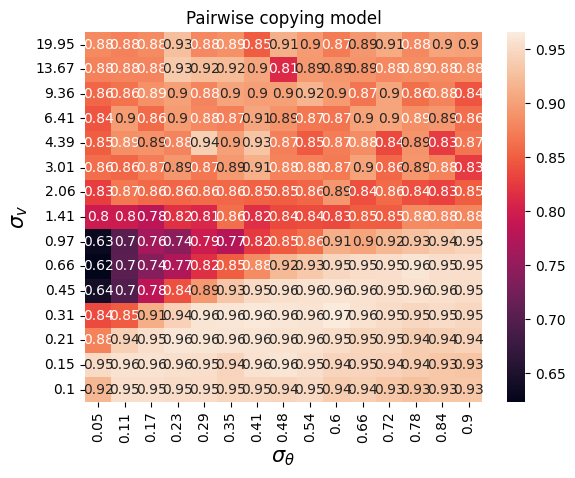

In [9]:
pairwiseCopying_correlations = pd.DataFrame(index=sigma_v_list, columns=sigma_t_list)

for sigma_v in sigma_v_list:
    for sigma_t in sigma_t_list:
        start = time.time()
        interaction_params = {
            "pairwiseCopying": {
                "rate": rate * np.ones(N),
                "sigma_v": sigma_v * np.ones(N),
                "sigma_t": sigma_t * np.ones(N),
                "interaction_length": L * np.ones(N),
            }
        }

        sim = StochasticFish_IndependentRates(
            N=N,
            Tmax=Tmax,
            arena_size=arena_size,
            interaction_params=interaction_params,
            vscale=v_scale,
        )
        sim.simulate()

        sim_object, derivedDF = get_predictors_from_sim(
            sim,
            grid_size=grid_size,
            frames_skipped=None,
            leeway=leeway,
            verbose=False,
            grid_sampling_fraction=grid_sampling_fraction,
            window_size_multiplier=window_size_multiplier,
            score_kwargs = score_kwargs
        )

        # save correlation
        pairwiseCopying_correlations.loc[sigma_v, sigma_t] = derivedDF.corr(method="spearman").loc[
            "vicsek", "pairwiseCopying"
        ]
        end = time.time()
        derivation_logger.info(f"[sigma_v={sigma_v},sigma_t={sigma_t}] generated in {end-start:.2f} seconds.")
        print("-"*50)

pairwiseCopying_correlations = pairwiseCopying_correlations.astype(float)
sns.heatmap(pairwiseCopying_correlations, annot=True)
plt.xlabel(r"$\sigma_{\theta}$",fontsize=15)
plt.ylabel(r"$\sigma_v$",fontsize=15)
plt.gca().invert_yaxis()
plt.title("Pairwise copying model")
plt.show()

# Diffusion

Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:17:23,993 - Local windows completed in 8.01 seconds.
2024-10-09 06:17:35,200 - vicsek completed in 11.21 seconds.
2024-10-09 06:17:49,988 - pairwiseCopying completed in 14.79 seconds.
2024-10-09 06:17:57,345 - velocityDiffusion completed in 7.36 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/108098 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:17:57,671 - derivedDF generated in 0.33 seconds.
2024-10-09 06:17:57,758 - [sigma_v=0.1,sigma_t=0.05] generated in 43.43 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:18:07,529 - Local windows completed in 8.17 seconds.
2024-10-09 06:18:19,449 - vicsek completed in 11.92 seconds.
2024-10-09 06:18:34,402 - pairwiseCopying completed in 14.95 seconds.
2024-10-09 06:18:41,761 - velocityDiffusion completed in 7.36 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107646 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:18:42,090 - derivedDF generated in 0.33 seconds.
2024-10-09 06:18:42,189 - [sigma_v=0.1,sigma_t=0.11] generated in 44.43 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:18:51,946 - Local windows completed in 8.05 seconds.
2024-10-09 06:19:03,137 - vicsek completed in 11.19 seconds.
2024-10-09 06:19:16,559 - pairwiseCopying completed in 13.42 seconds.
2024-10-09 06:19:23,999 - velocityDiffusion completed in 7.44 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105386 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:19:24,329 - derivedDF generated in 0.33 seconds.
2024-10-09 06:19:24,425 - [sigma_v=0.1,sigma_t=0.17] generated in 42.23 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:19:34,008 - Local windows completed in 7.94 seconds.
2024-10-09 06:19:46,301 - vicsek completed in 12.29 seconds.
2024-10-09 06:19:59,437 - pairwiseCopying completed in 13.13 seconds.
2024-10-09 06:20:07,099 - velocityDiffusion completed in 7.66 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107360 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:20:07,428 - derivedDF generated in 0.33 seconds.
2024-10-09 06:20:07,522 - [sigma_v=0.1,sigma_t=0.23] generated in 43.10 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:20:17,266 - Local windows completed in 8.09 seconds.
2024-10-09 06:20:28,401 - vicsek completed in 11.13 seconds.
2024-10-09 06:20:40,981 - pairwiseCopying completed in 12.58 seconds.
2024-10-09 06:20:48,607 - velocityDiffusion completed in 7.63 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/101642 (~0.34%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:20:48,934 - derivedDF generated in 0.33 seconds.
2024-10-09 06:20:49,024 - [sigma_v=0.1,sigma_t=0.29] generated in 41.50 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:20:58,614 - Local windows completed in 7.97 seconds.
2024-10-09 06:21:10,318 - vicsek completed in 11.70 seconds.
2024-10-09 06:21:24,994 - pairwiseCopying completed in 14.68 seconds.
2024-10-09 06:21:32,492 - velocityDiffusion completed in 7.50 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/102925 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:21:33,118 - derivedDF generated in 0.63 seconds.
2024-10-09 06:21:33,209 - [sigma_v=0.1,sigma_t=0.35] generated in 44.18 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:21:42,710 - Local windows completed in 7.89 seconds.
2024-10-09 06:21:54,638 - vicsek completed in 11.93 seconds.
2024-10-09 06:22:09,952 - pairwiseCopying completed in 15.31 seconds.
2024-10-09 06:22:17,489 - velocityDiffusion completed in 7.54 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104807 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:22:17,816 - derivedDF generated in 0.33 seconds.
2024-10-09 06:22:17,909 - [sigma_v=0.1,sigma_t=0.41] generated in 44.70 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:22:27,742 - Local windows completed in 8.22 seconds.
2024-10-09 06:22:40,425 - vicsek completed in 12.68 seconds.
2024-10-09 06:22:57,842 - pairwiseCopying completed in 17.42 seconds.
2024-10-09 06:23:05,184 - velocityDiffusion completed in 7.34 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/109631 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:23:05,508 - derivedDF generated in 0.32 seconds.
2024-10-09 06:23:05,605 - [sigma_v=0.1,sigma_t=0.48] generated in 47.69 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:23:15,387 - Local windows completed in 8.14 seconds.
2024-10-09 06:23:27,639 - vicsek completed in 12.25 seconds.
2024-10-09 06:23:41,539 - pairwiseCopying completed in 13.90 seconds.
2024-10-09 06:23:48,882 - velocityDiffusion completed in 7.34 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105653 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:23:49,207 - derivedDF generated in 0.32 seconds.
2024-10-09 06:23:49,301 - [sigma_v=0.1,sigma_t=0.54] generated in 43.70 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:23:59,066 - Local windows completed in 8.05 seconds.
2024-10-09 06:24:11,428 - vicsek completed in 12.36 seconds.
2024-10-09 06:24:26,668 - pairwiseCopying completed in 15.24 seconds.
2024-10-09 06:24:34,167 - velocityDiffusion completed in 7.50 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107174 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:24:34,494 - derivedDF generated in 0.33 seconds.
2024-10-09 06:24:34,597 - [sigma_v=0.1,sigma_t=0.6] generated in 45.29 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:24:44,225 - Local windows completed in 8.02 seconds.
2024-10-09 06:24:58,150 - vicsek completed in 13.92 seconds.
2024-10-09 06:25:14,717 - pairwiseCopying completed in 16.57 seconds.
2024-10-09 06:25:22,155 - velocityDiffusion completed in 7.44 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/109275 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:25:22,478 - derivedDF generated in 0.32 seconds.
2024-10-09 06:25:22,574 - [sigma_v=0.1,sigma_t=0.66] generated in 47.98 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:25:32,439 - Local windows completed in 8.26 seconds.
2024-10-09 06:25:44,870 - vicsek completed in 12.43 seconds.
2024-10-09 06:26:01,566 - pairwiseCopying completed in 16.69 seconds.
2024-10-09 06:26:09,036 - velocityDiffusion completed in 7.47 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/108742 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:26:09,364 - derivedDF generated in 0.33 seconds.
2024-10-09 06:26:09,460 - [sigma_v=0.1,sigma_t=0.72] generated in 46.89 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:26:19,257 - Local windows completed in 8.20 seconds.
2024-10-09 06:26:30,590 - vicsek completed in 11.33 seconds.
2024-10-09 06:26:45,175 - pairwiseCopying completed in 14.58 seconds.
2024-10-09 06:26:52,504 - velocityDiffusion completed in 7.33 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107936 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:26:52,834 - derivedDF generated in 0.33 seconds.
2024-10-09 06:26:52,926 - [sigma_v=0.1,sigma_t=0.78] generated in 43.46 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:27:02,738 - Local windows completed in 8.19 seconds.
2024-10-09 06:27:15,025 - vicsek completed in 12.29 seconds.
2024-10-09 06:27:29,264 - pairwiseCopying completed in 14.24 seconds.
2024-10-09 06:27:36,710 - velocityDiffusion completed in 7.45 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105608 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:27:37,036 - derivedDF generated in 0.33 seconds.
2024-10-09 06:27:37,129 - [sigma_v=0.1,sigma_t=0.84] generated in 44.20 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:27:47,011 - Local windows completed in 8.27 seconds.
2024-10-09 06:27:57,918 - vicsek completed in 10.91 seconds.
2024-10-09 06:28:10,861 - pairwiseCopying completed in 12.94 seconds.
2024-10-09 06:28:18,154 - velocityDiffusion completed in 7.29 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107981 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:28:18,482 - derivedDF generated in 0.33 seconds.
2024-10-09 06:28:18,571 - [sigma_v=0.1,sigma_t=0.9] generated in 41.44 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:28:28,425 - Local windows completed in 8.21 seconds.
2024-10-09 06:28:39,505 - vicsek completed in 11.08 seconds.
2024-10-09 06:28:53,364 - pairwiseCopying completed in 13.86 seconds.
2024-10-09 06:29:00,693 - velocityDiffusion completed in 7.33 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/109049 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:29:01,303 - derivedDF generated in 0.61 seconds.
2024-10-09 06:29:01,387 - [sigma_v=0.15,sigma_t=0.05] generated in 42.82 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:29:10,963 - Local windows completed in 7.86 seconds.
2024-10-09 06:29:23,271 - vicsek completed in 12.31 seconds.
2024-10-09 06:29:38,328 - pairwiseCopying completed in 15.06 seconds.
2024-10-09 06:29:45,731 - velocityDiffusion completed in 7.40 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105578 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:29:46,060 - derivedDF generated in 0.33 seconds.
2024-10-09 06:29:46,154 - [sigma_v=0.15,sigma_t=0.11] generated in 44.77 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:29:55,953 - Local windows completed in 8.17 seconds.
2024-10-09 06:30:08,486 - vicsek completed in 12.53 seconds.
2024-10-09 06:30:23,264 - pairwiseCopying completed in 14.78 seconds.
2024-10-09 06:30:30,741 - velocityDiffusion completed in 7.48 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106045 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:30:31,067 - derivedDF generated in 0.33 seconds.
2024-10-09 06:30:31,162 - [sigma_v=0.15,sigma_t=0.17] generated in 45.01 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:30:40,885 - Local windows completed in 7.89 seconds.
2024-10-09 06:30:52,401 - vicsek completed in 11.52 seconds.
2024-10-09 06:31:05,954 - pairwiseCopying completed in 13.55 seconds.
2024-10-09 06:31:13,714 - velocityDiffusion completed in 7.76 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/103743 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:31:14,042 - derivedDF generated in 0.33 seconds.
2024-10-09 06:31:14,134 - [sigma_v=0.15,sigma_t=0.23] generated in 42.97 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:31:23,661 - Local windows completed in 7.92 seconds.
2024-10-09 06:31:35,730 - vicsek completed in 12.07 seconds.
2024-10-09 06:31:48,949 - pairwiseCopying completed in 13.22 seconds.
2024-10-09 06:31:56,533 - velocityDiffusion completed in 7.58 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/101213 (~0.34%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:31:56,878 - derivedDF generated in 0.34 seconds.
2024-10-09 06:31:56,968 - [sigma_v=0.15,sigma_t=0.29] generated in 42.83 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:32:06,565 - Local windows completed in 7.99 seconds.
2024-10-09 06:32:18,969 - vicsek completed in 12.40 seconds.
2024-10-09 06:32:34,176 - pairwiseCopying completed in 15.21 seconds.
2024-10-09 06:32:41,670 - velocityDiffusion completed in 7.49 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/101802 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:32:42,275 - derivedDF generated in 0.60 seconds.
2024-10-09 06:32:42,369 - [sigma_v=0.15,sigma_t=0.35] generated in 45.40 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:32:51,934 - Local windows completed in 7.96 seconds.
2024-10-09 06:33:04,713 - vicsek completed in 12.78 seconds.
2024-10-09 06:33:21,260 - pairwiseCopying completed in 16.55 seconds.
2024-10-09 06:33:28,601 - velocityDiffusion completed in 7.34 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/109185 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:33:28,926 - derivedDF generated in 0.32 seconds.
2024-10-09 06:33:29,024 - [sigma_v=0.15,sigma_t=0.41] generated in 46.65 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:33:38,805 - Local windows completed in 8.14 seconds.
2024-10-09 06:33:52,494 - vicsek completed in 13.69 seconds.
2024-10-09 06:34:11,504 - pairwiseCopying completed in 19.01 seconds.
2024-10-09 06:34:18,874 - velocityDiffusion completed in 7.37 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/108338 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:34:19,196 - derivedDF generated in 0.32 seconds.
2024-10-09 06:34:19,295 - [sigma_v=0.15,sigma_t=0.48] generated in 50.27 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:34:29,134 - Local windows completed in 8.24 seconds.
2024-10-09 06:34:41,355 - vicsek completed in 12.22 seconds.
2024-10-09 06:34:58,020 - pairwiseCopying completed in 16.66 seconds.
2024-10-09 06:35:05,392 - velocityDiffusion completed in 7.37 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106941 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:35:05,719 - derivedDF generated in 0.33 seconds.
2024-10-09 06:35:05,817 - [sigma_v=0.15,sigma_t=0.54] generated in 46.52 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:35:16,674 - Local windows completed in 8.89 seconds.
2024-10-09 06:35:28,708 - vicsek completed in 12.03 seconds.
2024-10-09 06:35:43,170 - pairwiseCopying completed in 14.46 seconds.
2024-10-09 06:35:50,532 - velocityDiffusion completed in 7.36 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106988 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:35:50,858 - derivedDF generated in 0.33 seconds.
2024-10-09 06:35:50,950 - [sigma_v=0.15,sigma_t=0.6] generated in 45.13 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:36:00,524 - Local windows completed in 7.97 seconds.
2024-10-09 06:36:12,161 - vicsek completed in 11.64 seconds.
2024-10-09 06:36:26,022 - pairwiseCopying completed in 13.86 seconds.
2024-10-09 06:36:33,569 - velocityDiffusion completed in 7.55 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107337 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:36:33,898 - derivedDF generated in 0.33 seconds.
2024-10-09 06:36:33,990 - [sigma_v=0.15,sigma_t=0.66] generated in 43.04 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:36:43,565 - Local windows completed in 7.96 seconds.
2024-10-09 06:36:55,587 - vicsek completed in 12.02 seconds.
2024-10-09 06:37:09,921 - pairwiseCopying completed in 14.33 seconds.
2024-10-09 06:37:17,577 - velocityDiffusion completed in 7.66 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/110152 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:37:17,907 - derivedDF generated in 0.33 seconds.
2024-10-09 06:37:18,002 - [sigma_v=0.15,sigma_t=0.72] generated in 44.01 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:37:27,582 - Local windows completed in 7.98 seconds.
2024-10-09 06:37:40,120 - vicsek completed in 12.54 seconds.
2024-10-09 06:37:55,803 - pairwiseCopying completed in 15.68 seconds.
2024-10-09 06:38:03,057 - velocityDiffusion completed in 7.25 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107139 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:38:03,686 - derivedDF generated in 0.63 seconds.
2024-10-09 06:38:03,779 - [sigma_v=0.15,sigma_t=0.78] generated in 45.78 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:38:13,375 - Local windows completed in 8.00 seconds.
2024-10-09 06:38:26,423 - vicsek completed in 13.05 seconds.
2024-10-09 06:38:42,554 - pairwiseCopying completed in 16.13 seconds.
2024-10-09 06:38:49,998 - velocityDiffusion completed in 7.44 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106342 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:38:50,321 - derivedDF generated in 0.32 seconds.
2024-10-09 06:38:50,416 - [sigma_v=0.15,sigma_t=0.84] generated in 46.64 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:39:00,277 - Local windows completed in 8.20 seconds.
2024-10-09 06:39:10,654 - vicsek completed in 10.38 seconds.
2024-10-09 06:39:23,645 - pairwiseCopying completed in 12.99 seconds.
2024-10-09 06:39:30,880 - velocityDiffusion completed in 7.23 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106943 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:39:31,208 - derivedDF generated in 0.33 seconds.
2024-10-09 06:39:31,299 - [sigma_v=0.15,sigma_t=0.9] generated in 40.88 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:39:41,129 - Local windows completed in 8.12 seconds.
2024-10-09 06:39:52,639 - vicsek completed in 11.51 seconds.
2024-10-09 06:40:07,609 - pairwiseCopying completed in 14.97 seconds.
2024-10-09 06:40:14,893 - velocityDiffusion completed in 7.28 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107989 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:40:15,219 - derivedDF generated in 0.33 seconds.
2024-10-09 06:40:15,305 - [sigma_v=0.21,sigma_t=0.05] generated in 44.01 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:40:26,176 - Local windows completed in 9.19 seconds.
2024-10-09 06:40:38,390 - vicsek completed in 12.21 seconds.
2024-10-09 06:40:53,061 - pairwiseCopying completed in 14.67 seconds.
2024-10-09 06:41:00,628 - velocityDiffusion completed in 7.57 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105957 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:41:01,014 - derivedDF generated in 0.38 seconds.
2024-10-09 06:41:01,107 - [sigma_v=0.21,sigma_t=0.11] generated in 45.80 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:41:10,940 - Local windows completed in 8.25 seconds.
2024-10-09 06:41:21,801 - vicsek completed in 10.86 seconds.
2024-10-09 06:41:35,231 - pairwiseCopying completed in 13.43 seconds.
2024-10-09 06:41:42,469 - velocityDiffusion completed in 7.24 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/108349 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:41:42,799 - derivedDF generated in 0.33 seconds.
2024-10-09 06:41:42,890 - [sigma_v=0.21,sigma_t=0.17] generated in 41.78 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:41:52,691 - Local windows completed in 8.15 seconds.
2024-10-09 06:42:04,915 - vicsek completed in 12.22 seconds.
2024-10-09 06:42:19,172 - pairwiseCopying completed in 14.26 seconds.
2024-10-09 06:42:26,760 - velocityDiffusion completed in 7.59 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106036 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:42:27,085 - derivedDF generated in 0.32 seconds.
2024-10-09 06:42:27,180 - [sigma_v=0.21,sigma_t=0.23] generated in 44.29 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:42:36,883 - Local windows completed in 8.10 seconds.
2024-10-09 06:42:48,083 - vicsek completed in 11.20 seconds.
2024-10-09 06:43:01,845 - pairwiseCopying completed in 13.76 seconds.
2024-10-09 06:43:09,249 - velocityDiffusion completed in 7.40 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/102071 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:43:09,580 - derivedDF generated in 0.33 seconds.
2024-10-09 06:43:09,673 - [sigma_v=0.21,sigma_t=0.29] generated in 42.49 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:43:19,548 - Local windows completed in 8.28 seconds.
2024-10-09 06:43:30,515 - vicsek completed in 10.97 seconds.
2024-10-09 06:43:43,757 - pairwiseCopying completed in 13.24 seconds.
2024-10-09 06:43:51,159 - velocityDiffusion completed in 7.40 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/103176 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:43:51,491 - derivedDF generated in 0.33 seconds.
2024-10-09 06:43:51,579 - [sigma_v=0.21,sigma_t=0.35] generated in 41.91 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:44:01,345 - Local windows completed in 8.13 seconds.
2024-10-09 06:44:12,905 - vicsek completed in 11.56 seconds.
2024-10-09 06:44:27,580 - pairwiseCopying completed in 14.67 seconds.
2024-10-09 06:44:35,007 - velocityDiffusion completed in 7.43 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106679 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:44:35,335 - derivedDF generated in 0.33 seconds.
2024-10-09 06:44:35,426 - [sigma_v=0.21,sigma_t=0.41] generated in 43.85 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:44:45,169 - Local windows completed in 8.15 seconds.
2024-10-09 06:44:58,164 - vicsek completed in 12.99 seconds.
2024-10-09 06:45:15,324 - pairwiseCopying completed in 17.16 seconds.
2024-10-09 06:45:22,638 - velocityDiffusion completed in 7.31 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107729 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:45:23,250 - derivedDF generated in 0.61 seconds.
2024-10-09 06:45:23,347 - [sigma_v=0.21,sigma_t=0.48] generated in 47.92 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:45:34,017 - Local windows completed in 8.71 seconds.
2024-10-09 06:45:47,110 - vicsek completed in 13.09 seconds.
2024-10-09 06:46:03,111 - pairwiseCopying completed in 16.00 seconds.
2024-10-09 06:46:10,547 - velocityDiffusion completed in 7.44 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107217 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:46:10,873 - derivedDF generated in 0.33 seconds.
2024-10-09 06:46:10,970 - [sigma_v=0.21,sigma_t=0.54] generated in 47.62 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:46:20,702 - Local windows completed in 8.14 seconds.
2024-10-09 06:46:33,089 - vicsek completed in 12.39 seconds.
2024-10-09 06:46:48,698 - pairwiseCopying completed in 15.61 seconds.
2024-10-09 06:46:55,927 - velocityDiffusion completed in 7.23 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/109273 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:46:56,251 - derivedDF generated in 0.32 seconds.
2024-10-09 06:46:56,348 - [sigma_v=0.21,sigma_t=0.6] generated in 45.38 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:47:05,928 - Local windows completed in 7.85 seconds.
2024-10-09 06:47:17,985 - vicsek completed in 12.06 seconds.
2024-10-09 06:47:32,464 - pairwiseCopying completed in 14.48 seconds.
2024-10-09 06:47:40,029 - velocityDiffusion completed in 7.56 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/108197 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:47:40,353 - derivedDF generated in 0.32 seconds.
2024-10-09 06:47:40,448 - [sigma_v=0.21,sigma_t=0.66] generated in 44.10 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:47:49,996 - Local windows completed in 7.95 seconds.
2024-10-09 06:48:01,855 - vicsek completed in 11.86 seconds.
2024-10-09 06:48:16,624 - pairwiseCopying completed in 14.77 seconds.
2024-10-09 06:48:24,470 - velocityDiffusion completed in 7.84 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/108955 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:48:24,806 - derivedDF generated in 0.33 seconds.
2024-10-09 06:48:24,900 - [sigma_v=0.21,sigma_t=0.72] generated in 44.45 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:48:34,846 - Local windows completed in 8.33 seconds.
2024-10-09 06:48:48,199 - vicsek completed in 13.35 seconds.
2024-10-09 06:49:04,892 - pairwiseCopying completed in 16.69 seconds.
2024-10-09 06:49:12,648 - velocityDiffusion completed in 7.76 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107952 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:49:13,286 - derivedDF generated in 0.64 seconds.
2024-10-09 06:49:13,385 - [sigma_v=0.21,sigma_t=0.78] generated in 48.48 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:49:23,487 - Local windows completed in 8.37 seconds.
2024-10-09 06:49:36,711 - vicsek completed in 13.22 seconds.
2024-10-09 06:49:52,118 - pairwiseCopying completed in 15.41 seconds.
2024-10-09 06:49:59,940 - velocityDiffusion completed in 7.82 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105553 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:50:00,278 - derivedDF generated in 0.34 seconds.
2024-10-09 06:50:00,376 - [sigma_v=0.21,sigma_t=0.84] generated in 46.99 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:50:10,561 - Local windows completed in 8.51 seconds.
2024-10-09 06:50:21,189 - vicsek completed in 10.63 seconds.
2024-10-09 06:50:35,137 - pairwiseCopying completed in 13.95 seconds.
2024-10-09 06:50:43,072 - velocityDiffusion completed in 7.93 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107936 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:50:43,417 - derivedDF generated in 0.35 seconds.
2024-10-09 06:50:43,513 - [sigma_v=0.21,sigma_t=0.9] generated in 43.14 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:50:53,987 - Local windows completed in 8.75 seconds.
2024-10-09 06:51:06,256 - vicsek completed in 12.27 seconds.
2024-10-09 06:51:21,932 - pairwiseCopying completed in 15.67 seconds.
2024-10-09 06:51:29,781 - velocityDiffusion completed in 7.85 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/108870 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:51:30,122 - derivedDF generated in 0.34 seconds.
2024-10-09 06:51:30,210 - [sigma_v=0.31,sigma_t=0.05] generated in 46.70 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:51:40,552 - Local windows completed in 8.66 seconds.
2024-10-09 06:51:53,882 - vicsek completed in 13.33 seconds.
2024-10-09 06:52:11,083 - pairwiseCopying completed in 17.20 seconds.
2024-10-09 06:52:18,820 - velocityDiffusion completed in 7.74 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/108844 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:52:19,472 - derivedDF generated in 0.65 seconds.
2024-10-09 06:52:19,573 - [sigma_v=0.31,sigma_t=0.11] generated in 49.36 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:52:29,528 - Local windows completed in 8.29 seconds.
2024-10-09 06:52:41,708 - vicsek completed in 12.18 seconds.
2024-10-09 06:52:56,762 - pairwiseCopying completed in 15.05 seconds.
2024-10-09 06:53:04,576 - velocityDiffusion completed in 7.81 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105430 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:53:04,919 - derivedDF generated in 0.34 seconds.
2024-10-09 06:53:05,017 - [sigma_v=0.31,sigma_t=0.17] generated in 45.44 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:53:15,101 - Local windows completed in 8.46 seconds.
2024-10-09 06:53:28,365 - vicsek completed in 13.26 seconds.
2024-10-09 06:53:44,538 - pairwiseCopying completed in 16.17 seconds.
2024-10-09 06:53:52,461 - velocityDiffusion completed in 7.92 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107163 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:53:52,798 - derivedDF generated in 0.34 seconds.
2024-10-09 06:53:52,898 - [sigma_v=0.31,sigma_t=0.23] generated in 47.88 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:54:02,911 - Local windows completed in 8.23 seconds.
2024-10-09 06:54:14,818 - vicsek completed in 11.91 seconds.
2024-10-09 06:54:29,512 - pairwiseCopying completed in 14.69 seconds.
2024-10-09 06:54:37,283 - velocityDiffusion completed in 7.77 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/101230 (~0.34%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:54:37,609 - derivedDF generated in 0.33 seconds.
2024-10-09 06:54:37,703 - [sigma_v=0.31,sigma_t=0.29] generated in 44.80 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:54:47,305 - Local windows completed in 7.85 seconds.
2024-10-09 06:54:58,682 - vicsek completed in 11.38 seconds.
2024-10-09 06:55:11,621 - pairwiseCopying completed in 12.94 seconds.
2024-10-09 06:55:19,062 - velocityDiffusion completed in 7.44 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/101790 (~0.34%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:55:19,674 - derivedDF generated in 0.61 seconds.
2024-10-09 06:55:19,765 - [sigma_v=0.31,sigma_t=0.35] generated in 42.06 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:55:29,901 - Local windows completed in 8.53 seconds.
2024-10-09 06:55:43,032 - vicsek completed in 13.13 seconds.
2024-10-09 06:55:59,590 - pairwiseCopying completed in 16.56 seconds.
2024-10-09 06:56:06,817 - velocityDiffusion completed in 7.23 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/108772 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:56:07,146 - derivedDF generated in 0.33 seconds.
2024-10-09 06:56:07,244 - [sigma_v=0.31,sigma_t=0.41] generated in 47.48 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:56:17,010 - Local windows completed in 8.04 seconds.
2024-10-09 06:56:29,800 - vicsek completed in 12.79 seconds.
2024-10-09 06:56:46,469 - pairwiseCopying completed in 16.67 seconds.
2024-10-09 06:56:53,842 - velocityDiffusion completed in 7.37 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107771 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:56:54,164 - derivedDF generated in 0.32 seconds.
2024-10-09 06:56:54,260 - [sigma_v=0.31,sigma_t=0.48] generated in 47.02 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:57:03,997 - Local windows completed in 8.09 seconds.
2024-10-09 06:57:16,341 - vicsek completed in 12.34 seconds.
2024-10-09 06:57:32,970 - pairwiseCopying completed in 16.63 seconds.
2024-10-09 06:57:40,273 - velocityDiffusion completed in 7.30 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/108847 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:57:40,597 - derivedDF generated in 0.32 seconds.
2024-10-09 06:57:40,694 - [sigma_v=0.31,sigma_t=0.54] generated in 46.43 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:57:50,443 - Local windows completed in 8.17 seconds.
2024-10-09 06:58:03,396 - vicsek completed in 12.95 seconds.
2024-10-09 06:58:19,747 - pairwiseCopying completed in 16.35 seconds.
2024-10-09 06:58:27,153 - velocityDiffusion completed in 7.41 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/111292 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:58:27,759 - derivedDF generated in 0.61 seconds.
2024-10-09 06:58:27,857 - [sigma_v=0.31,sigma_t=0.6] generated in 47.16 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:58:37,453 - Local windows completed in 7.98 seconds.
2024-10-09 06:58:48,610 - vicsek completed in 11.16 seconds.
2024-10-09 06:59:01,991 - pairwiseCopying completed in 13.38 seconds.
2024-10-09 06:59:09,450 - velocityDiffusion completed in 7.46 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/109369 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:59:09,780 - derivedDF generated in 0.33 seconds.
2024-10-09 06:59:09,874 - [sigma_v=0.31,sigma_t=0.66] generated in 42.02 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 06:59:19,426 - Local windows completed in 7.93 seconds.
2024-10-09 06:59:30,884 - vicsek completed in 11.46 seconds.
2024-10-09 06:59:44,943 - pairwiseCopying completed in 14.06 seconds.
2024-10-09 06:59:52,474 - velocityDiffusion completed in 7.53 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106740 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 06:59:52,799 - derivedDF generated in 0.32 seconds.
2024-10-09 06:59:52,891 - [sigma_v=0.31,sigma_t=0.72] generated in 43.02 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:00:02,570 - Local windows completed in 8.03 seconds.
2024-10-09 07:00:11,876 - vicsek completed in 9.30 seconds.
2024-10-09 07:00:23,206 - pairwiseCopying completed in 11.33 seconds.
2024-10-09 07:00:30,822 - velocityDiffusion completed in 7.62 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105757 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:00:31,155 - derivedDF generated in 0.33 seconds.
2024-10-09 07:00:31,240 - [sigma_v=0.31,sigma_t=0.78] generated in 38.35 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:00:40,961 - Local windows completed in 8.02 seconds.
2024-10-09 07:00:53,249 - vicsek completed in 12.29 seconds.
2024-10-09 07:01:07,008 - pairwiseCopying completed in 13.76 seconds.
2024-10-09 07:01:14,330 - velocityDiffusion completed in 7.32 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107277 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:01:14,933 - derivedDF generated in 0.60 seconds.
2024-10-09 07:01:15,026 - [sigma_v=0.31,sigma_t=0.84] generated in 43.78 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:01:24,618 - Local windows completed in 7.98 seconds.
2024-10-09 07:01:35,243 - vicsek completed in 10.62 seconds.
2024-10-09 07:01:48,165 - pairwiseCopying completed in 12.92 seconds.
2024-10-09 07:01:55,371 - velocityDiffusion completed in 7.20 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/108229 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:01:55,703 - derivedDF generated in 0.33 seconds.
2024-10-09 07:01:55,796 - [sigma_v=0.31,sigma_t=0.9] generated in 40.77 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:02:05,441 - Local windows completed in 8.06 seconds.
2024-10-09 07:02:17,674 - vicsek completed in 12.23 seconds.
2024-10-09 07:02:33,393 - pairwiseCopying completed in 15.72 seconds.
2024-10-09 07:02:40,763 - velocityDiffusion completed in 7.37 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107440 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:02:41,088 - derivedDF generated in 0.32 seconds.
2024-10-09 07:02:41,176 - [sigma_v=0.45,sigma_t=0.05] generated in 45.38 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:02:51,031 - Local windows completed in 8.14 seconds.
2024-10-09 07:03:02,590 - vicsek completed in 11.56 seconds.
2024-10-09 07:03:17,201 - pairwiseCopying completed in 14.61 seconds.
2024-10-09 07:03:24,583 - velocityDiffusion completed in 7.38 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106045 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:03:24,915 - derivedDF generated in 0.33 seconds.
2024-10-09 07:03:25,009 - [sigma_v=0.45,sigma_t=0.11] generated in 43.83 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:03:34,789 - Local windows completed in 8.17 seconds.
2024-10-09 07:03:45,862 - vicsek completed in 11.07 seconds.
2024-10-09 07:03:59,177 - pairwiseCopying completed in 13.31 seconds.
2024-10-09 07:04:06,605 - velocityDiffusion completed in 7.43 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106897 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:04:06,936 - derivedDF generated in 0.33 seconds.
2024-10-09 07:04:07,032 - [sigma_v=0.45,sigma_t=0.17] generated in 42.02 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:04:16,614 - Local windows completed in 7.96 seconds.
2024-10-09 07:04:28,473 - vicsek completed in 11.86 seconds.
2024-10-09 07:04:42,437 - pairwiseCopying completed in 13.96 seconds.
2024-10-09 07:04:50,029 - velocityDiffusion completed in 7.59 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107066 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:04:50,361 - derivedDF generated in 0.33 seconds.
2024-10-09 07:04:50,461 - [sigma_v=0.45,sigma_t=0.23] generated in 43.43 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:04:59,973 - Local windows completed in 7.91 seconds.
2024-10-09 07:05:11,524 - vicsek completed in 11.55 seconds.
2024-10-09 07:05:25,497 - pairwiseCopying completed in 13.97 seconds.
2024-10-09 07:05:33,317 - velocityDiffusion completed in 7.82 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106698 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:05:33,645 - derivedDF generated in 0.33 seconds.
2024-10-09 07:05:33,741 - [sigma_v=0.45,sigma_t=0.29] generated in 43.28 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:05:43,410 - Local windows completed in 8.06 seconds.
2024-10-09 07:05:55,640 - vicsek completed in 12.23 seconds.
2024-10-09 07:06:11,890 - pairwiseCopying completed in 16.25 seconds.
2024-10-09 07:06:19,266 - velocityDiffusion completed in 7.37 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/103802 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:06:19,882 - derivedDF generated in 0.62 seconds.
2024-10-09 07:06:19,978 - [sigma_v=0.45,sigma_t=0.35] generated in 46.24 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:06:29,630 - Local windows completed in 8.04 seconds.
2024-10-09 07:06:40,754 - vicsek completed in 11.12 seconds.
2024-10-09 07:06:54,484 - pairwiseCopying completed in 13.73 seconds.
2024-10-09 07:07:01,903 - velocityDiffusion completed in 7.42 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107830 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:07:02,233 - derivedDF generated in 0.33 seconds.
2024-10-09 07:07:02,326 - [sigma_v=0.45,sigma_t=0.41] generated in 42.35 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:07:12,113 - Local windows completed in 8.18 seconds.
2024-10-09 07:07:23,454 - vicsek completed in 11.34 seconds.
2024-10-09 07:07:38,208 - pairwiseCopying completed in 14.75 seconds.
2024-10-09 07:07:45,609 - velocityDiffusion completed in 7.40 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106330 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:07:45,940 - derivedDF generated in 0.33 seconds.
2024-10-09 07:07:46,033 - [sigma_v=0.45,sigma_t=0.48] generated in 43.71 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:07:55,821 - Local windows completed in 8.18 seconds.
2024-10-09 07:08:07,520 - vicsek completed in 11.70 seconds.
2024-10-09 07:08:21,737 - pairwiseCopying completed in 14.22 seconds.
2024-10-09 07:08:29,157 - velocityDiffusion completed in 7.42 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107300 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:08:29,485 - derivedDF generated in 0.33 seconds.
2024-10-09 07:08:29,578 - [sigma_v=0.45,sigma_t=0.54] generated in 43.54 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:08:39,366 - Local windows completed in 8.15 seconds.
2024-10-09 07:08:50,445 - vicsek completed in 11.08 seconds.
2024-10-09 07:09:04,808 - pairwiseCopying completed in 14.36 seconds.
2024-10-09 07:09:12,125 - velocityDiffusion completed in 7.32 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/110921 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:09:12,453 - derivedDF generated in 0.33 seconds.
2024-10-09 07:09:12,545 - [sigma_v=0.45,sigma_t=0.6] generated in 42.97 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:09:22,264 - Local windows completed in 8.09 seconds.
2024-10-09 07:09:32,997 - vicsek completed in 10.73 seconds.
2024-10-09 07:09:45,919 - pairwiseCopying completed in 12.92 seconds.
2024-10-09 07:09:53,324 - velocityDiffusion completed in 7.40 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106194 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:09:53,661 - derivedDF generated in 0.34 seconds.
2024-10-09 07:09:53,756 - [sigma_v=0.45,sigma_t=0.66] generated in 41.21 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:10:03,430 - Local windows completed in 8.01 seconds.
2024-10-09 07:10:15,118 - vicsek completed in 11.69 seconds.
2024-10-09 07:10:30,029 - pairwiseCopying completed in 14.91 seconds.
2024-10-09 07:10:37,560 - velocityDiffusion completed in 7.53 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/109293 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:10:37,888 - derivedDF generated in 0.33 seconds.
2024-10-09 07:10:37,981 - [sigma_v=0.45,sigma_t=0.72] generated in 44.22 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:10:47,755 - Local windows completed in 8.13 seconds.
2024-10-09 07:10:59,384 - vicsek completed in 11.63 seconds.
2024-10-09 07:11:15,363 - pairwiseCopying completed in 15.98 seconds.
2024-10-09 07:11:22,826 - velocityDiffusion completed in 7.46 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/108852 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:11:23,158 - derivedDF generated in 0.33 seconds.
2024-10-09 07:11:23,253 - [sigma_v=0.45,sigma_t=0.78] generated in 45.27 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:11:33,325 - Local windows completed in 8.43 seconds.
2024-10-09 07:11:43,917 - vicsek completed in 10.59 seconds.
2024-10-09 07:11:57,164 - pairwiseCopying completed in 13.25 seconds.
2024-10-09 07:12:04,533 - velocityDiffusion completed in 7.37 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107508 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:12:04,864 - derivedDF generated in 0.33 seconds.
2024-10-09 07:12:04,957 - [sigma_v=0.45,sigma_t=0.84] generated in 41.70 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:12:14,673 - Local windows completed in 8.12 seconds.
2024-10-09 07:12:25,189 - vicsek completed in 10.52 seconds.
2024-10-09 07:12:37,866 - pairwiseCopying completed in 12.68 seconds.
2024-10-09 07:12:45,263 - velocityDiffusion completed in 7.40 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/109858 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:12:45,610 - derivedDF generated in 0.35 seconds.
2024-10-09 07:12:45,700 - [sigma_v=0.45,sigma_t=0.9] generated in 40.74 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:12:55,394 - Local windows completed in 8.07 seconds.
2024-10-09 07:13:07,318 - vicsek completed in 11.92 seconds.
2024-10-09 07:13:22,078 - pairwiseCopying completed in 14.76 seconds.
2024-10-09 07:13:29,567 - velocityDiffusion completed in 7.49 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104722 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:13:29,894 - derivedDF generated in 0.33 seconds.
2024-10-09 07:13:29,981 - [sigma_v=0.66,sigma_t=0.05] generated in 44.28 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:13:39,707 - Local windows completed in 8.13 seconds.
2024-10-09 07:13:51,285 - vicsek completed in 11.58 seconds.
2024-10-09 07:14:05,769 - pairwiseCopying completed in 14.48 seconds.
2024-10-09 07:14:13,234 - velocityDiffusion completed in 7.46 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/108135 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:14:13,844 - derivedDF generated in 0.61 seconds.
2024-10-09 07:14:13,937 - [sigma_v=0.66,sigma_t=0.11] generated in 43.96 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:14:23,492 - Local windows completed in 7.96 seconds.
2024-10-09 07:14:34,483 - vicsek completed in 10.99 seconds.
2024-10-09 07:14:48,022 - pairwiseCopying completed in 13.54 seconds.
2024-10-09 07:14:55,512 - velocityDiffusion completed in 7.49 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/97968 (~0.35%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:14:55,839 - derivedDF generated in 0.33 seconds.
2024-10-09 07:14:55,928 - [sigma_v=0.66,sigma_t=0.17] generated in 41.99 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:15:05,511 - Local windows completed in 7.95 seconds.
2024-10-09 07:15:17,377 - vicsek completed in 11.87 seconds.
2024-10-09 07:15:32,046 - pairwiseCopying completed in 14.67 seconds.
2024-10-09 07:15:39,929 - velocityDiffusion completed in 7.88 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104270 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:15:40,264 - derivedDF generated in 0.33 seconds.
2024-10-09 07:15:40,356 - [sigma_v=0.66,sigma_t=0.23] generated in 44.43 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:15:50,074 - Local windows completed in 8.12 seconds.
2024-10-09 07:16:01,427 - vicsek completed in 11.35 seconds.
2024-10-09 07:16:14,814 - pairwiseCopying completed in 13.39 seconds.
2024-10-09 07:16:23,789 - velocityDiffusion completed in 8.97 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105864 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:16:24,127 - derivedDF generated in 0.34 seconds.
2024-10-09 07:16:24,220 - [sigma_v=0.66,sigma_t=0.29] generated in 43.86 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:16:34,151 - Local windows completed in 8.30 seconds.
2024-10-09 07:16:45,043 - vicsek completed in 10.89 seconds.
2024-10-09 07:16:58,936 - pairwiseCopying completed in 13.89 seconds.
2024-10-09 07:17:06,242 - velocityDiffusion completed in 7.31 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/102125 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:17:06,850 - derivedDF generated in 0.61 seconds.
2024-10-09 07:17:06,941 - [sigma_v=0.66,sigma_t=0.35] generated in 42.72 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:17:16,518 - Local windows completed in 7.93 seconds.
2024-10-09 07:17:27,356 - vicsek completed in 10.84 seconds.
2024-10-09 07:17:41,043 - pairwiseCopying completed in 13.69 seconds.
2024-10-09 07:17:48,371 - velocityDiffusion completed in 7.33 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104927 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:17:48,708 - derivedDF generated in 0.34 seconds.
2024-10-09 07:17:48,806 - [sigma_v=0.66,sigma_t=0.41] generated in 41.86 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:17:58,502 - Local windows completed in 8.07 seconds.
2024-10-09 07:18:11,381 - vicsek completed in 12.88 seconds.
2024-10-09 07:18:28,383 - pairwiseCopying completed in 17.00 seconds.
2024-10-09 07:18:35,900 - velocityDiffusion completed in 7.52 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/109082 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:18:36,225 - derivedDF generated in 0.32 seconds.
2024-10-09 07:18:36,328 - [sigma_v=0.66,sigma_t=0.48] generated in 47.52 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:18:46,050 - Local windows completed in 8.09 seconds.
2024-10-09 07:18:57,197 - vicsek completed in 11.15 seconds.
2024-10-09 07:19:11,086 - pairwiseCopying completed in 13.89 seconds.
2024-10-09 07:19:18,413 - velocityDiffusion completed in 7.33 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106309 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:19:18,751 - derivedDF generated in 0.34 seconds.
2024-10-09 07:19:18,850 - [sigma_v=0.66,sigma_t=0.54] generated in 42.52 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:19:28,647 - Local windows completed in 8.17 seconds.
2024-10-09 07:19:38,846 - vicsek completed in 10.20 seconds.
2024-10-09 07:19:51,800 - pairwiseCopying completed in 12.95 seconds.
2024-10-09 07:19:59,248 - velocityDiffusion completed in 7.45 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/108121 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:19:59,578 - derivedDF generated in 0.33 seconds.
2024-10-09 07:19:59,668 - [sigma_v=0.66,sigma_t=0.6] generated in 40.82 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:20:09,465 - Local windows completed in 8.15 seconds.
2024-10-09 07:20:20,567 - vicsek completed in 11.10 seconds.
2024-10-09 07:20:34,376 - pairwiseCopying completed in 13.81 seconds.
2024-10-09 07:20:41,869 - velocityDiffusion completed in 7.49 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105139 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:20:42,201 - derivedDF generated in 0.33 seconds.
2024-10-09 07:20:42,296 - [sigma_v=0.66,sigma_t=0.66] generated in 42.63 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:20:51,862 - Local windows completed in 7.85 seconds.
2024-10-09 07:21:04,318 - vicsek completed in 12.46 seconds.
2024-10-09 07:21:19,903 - pairwiseCopying completed in 15.58 seconds.
2024-10-09 07:21:27,687 - velocityDiffusion completed in 7.78 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/108497 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:21:28,015 - derivedDF generated in 0.33 seconds.
2024-10-09 07:21:28,113 - [sigma_v=0.66,sigma_t=0.72] generated in 45.82 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:21:38,864 - Local windows completed in 9.02 seconds.
2024-10-09 07:21:51,728 - vicsek completed in 12.86 seconds.
2024-10-09 07:22:07,722 - pairwiseCopying completed in 15.99 seconds.
2024-10-09 07:22:15,401 - velocityDiffusion completed in 7.68 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/108801 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:22:15,726 - derivedDF generated in 0.32 seconds.
2024-10-09 07:22:15,825 - [sigma_v=0.66,sigma_t=0.78] generated in 47.71 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:22:25,333 - Local windows completed in 7.91 seconds.
2024-10-09 07:22:36,983 - vicsek completed in 11.65 seconds.
2024-10-09 07:22:50,776 - pairwiseCopying completed in 13.79 seconds.
2024-10-09 07:22:58,122 - velocityDiffusion completed in 7.35 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/108889 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:22:58,730 - derivedDF generated in 0.61 seconds.
2024-10-09 07:22:58,827 - [sigma_v=0.66,sigma_t=0.84] generated in 43.00 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:23:08,313 - Local windows completed in 7.85 seconds.
2024-10-09 07:23:19,227 - vicsek completed in 10.91 seconds.
2024-10-09 07:23:32,206 - pairwiseCopying completed in 12.98 seconds.
2024-10-09 07:23:39,447 - velocityDiffusion completed in 7.24 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106028 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:23:39,776 - derivedDF generated in 0.33 seconds.
2024-10-09 07:23:39,868 - [sigma_v=0.66,sigma_t=0.9] generated in 41.04 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:23:49,521 - Local windows completed in 8.03 seconds.
2024-10-09 07:24:01,791 - vicsek completed in 12.27 seconds.
2024-10-09 07:24:17,399 - pairwiseCopying completed in 15.61 seconds.
2024-10-09 07:24:24,945 - velocityDiffusion completed in 7.55 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/108882 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:24:25,271 - derivedDF generated in 0.32 seconds.
2024-10-09 07:24:25,364 - [sigma_v=0.97,sigma_t=0.05] generated in 45.49 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:24:35,159 - Local windows completed in 8.07 seconds.
2024-10-09 07:24:47,093 - vicsek completed in 11.93 seconds.
2024-10-09 07:25:02,179 - pairwiseCopying completed in 15.08 seconds.
2024-10-09 07:25:09,579 - velocityDiffusion completed in 7.40 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107020 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:25:09,907 - derivedDF generated in 0.33 seconds.
2024-10-09 07:25:10,003 - [sigma_v=0.97,sigma_t=0.11] generated in 44.64 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:25:19,846 - Local windows completed in 8.19 seconds.
2024-10-09 07:25:31,583 - vicsek completed in 11.74 seconds.
2024-10-09 07:25:46,085 - pairwiseCopying completed in 14.50 seconds.
2024-10-09 07:25:53,600 - velocityDiffusion completed in 7.51 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105323 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:25:53,942 - derivedDF generated in 0.34 seconds.
2024-10-09 07:25:54,039 - [sigma_v=0.97,sigma_t=0.17] generated in 44.04 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:26:03,808 - Local windows completed in 8.15 seconds.
2024-10-09 07:26:15,047 - vicsek completed in 11.24 seconds.
2024-10-09 07:26:28,636 - pairwiseCopying completed in 13.59 seconds.
2024-10-09 07:26:36,066 - velocityDiffusion completed in 7.43 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105033 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:26:36,395 - derivedDF generated in 0.33 seconds.
2024-10-09 07:26:36,494 - [sigma_v=0.97,sigma_t=0.23] generated in 42.45 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:26:47,398 - Local windows completed in 9.26 seconds.
2024-10-09 07:26:59,990 - vicsek completed in 12.59 seconds.
2024-10-09 07:27:15,920 - pairwiseCopying completed in 15.93 seconds.
2024-10-09 07:27:23,472 - velocityDiffusion completed in 7.55 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/103497 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:27:24,079 - derivedDF generated in 0.61 seconds.
2024-10-09 07:27:24,177 - [sigma_v=0.97,sigma_t=0.29] generated in 47.68 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:27:33,683 - Local windows completed in 7.88 seconds.
2024-10-09 07:27:45,015 - vicsek completed in 11.33 seconds.
2024-10-09 07:27:59,530 - pairwiseCopying completed in 14.51 seconds.
2024-10-09 07:28:07,035 - velocityDiffusion completed in 7.50 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105286 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:28:07,362 - derivedDF generated in 0.33 seconds.
2024-10-09 07:28:07,455 - [sigma_v=0.97,sigma_t=0.35] generated in 43.28 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:28:17,204 - Local windows completed in 8.14 seconds.
2024-10-09 07:28:28,622 - vicsek completed in 11.42 seconds.
2024-10-09 07:28:43,050 - pairwiseCopying completed in 14.43 seconds.
2024-10-09 07:28:50,396 - velocityDiffusion completed in 7.35 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105071 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:28:50,724 - derivedDF generated in 0.33 seconds.
2024-10-09 07:28:50,818 - [sigma_v=0.97,sigma_t=0.41] generated in 43.36 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:29:00,459 - Local windows completed in 8.01 seconds.
2024-10-09 07:29:12,701 - vicsek completed in 12.24 seconds.
2024-10-09 07:29:27,507 - pairwiseCopying completed in 14.81 seconds.
2024-10-09 07:29:35,120 - velocityDiffusion completed in 7.61 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105634 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:29:35,445 - derivedDF generated in 0.32 seconds.
2024-10-09 07:29:35,541 - [sigma_v=0.97,sigma_t=0.48] generated in 44.72 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:29:45,182 - Local windows completed in 7.98 seconds.
2024-10-09 07:29:55,985 - vicsek completed in 10.80 seconds.
2024-10-09 07:30:09,077 - pairwiseCopying completed in 13.09 seconds.
2024-10-09 07:30:16,899 - velocityDiffusion completed in 7.82 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/101347 (~0.34%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:30:17,225 - derivedDF generated in 0.32 seconds.
2024-10-09 07:30:17,317 - [sigma_v=0.97,sigma_t=0.54] generated in 41.78 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:30:26,969 - Local windows completed in 8.03 seconds.
2024-10-09 07:30:39,390 - vicsek completed in 12.42 seconds.
2024-10-09 07:30:54,422 - pairwiseCopying completed in 15.03 seconds.
2024-10-09 07:31:01,761 - velocityDiffusion completed in 7.34 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/103850 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:31:02,372 - derivedDF generated in 0.61 seconds.
2024-10-09 07:31:02,469 - [sigma_v=0.97,sigma_t=0.6] generated in 45.15 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:31:12,017 - Local windows completed in 7.94 seconds.
2024-10-09 07:31:22,974 - vicsek completed in 10.96 seconds.
2024-10-09 07:31:36,931 - pairwiseCopying completed in 13.96 seconds.
2024-10-09 07:31:44,344 - velocityDiffusion completed in 7.41 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105219 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:31:44,675 - derivedDF generated in 0.33 seconds.
2024-10-09 07:31:44,772 - [sigma_v=0.97,sigma_t=0.66] generated in 42.30 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:31:55,576 - Local windows completed in 9.17 seconds.
2024-10-09 07:32:07,285 - vicsek completed in 11.71 seconds.
2024-10-09 07:32:21,862 - pairwiseCopying completed in 14.58 seconds.
2024-10-09 07:32:29,418 - velocityDiffusion completed in 7.55 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105804 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:32:29,749 - derivedDF generated in 0.33 seconds.
2024-10-09 07:32:29,843 - [sigma_v=0.97,sigma_t=0.72] generated in 45.07 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:32:39,485 - Local windows completed in 8.05 seconds.
2024-10-09 07:32:50,495 - vicsek completed in 11.01 seconds.
2024-10-09 07:33:04,589 - pairwiseCopying completed in 14.09 seconds.
2024-10-09 07:33:11,971 - velocityDiffusion completed in 7.38 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104863 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:33:12,302 - derivedDF generated in 0.33 seconds.
2024-10-09 07:33:12,396 - [sigma_v=0.97,sigma_t=0.78] generated in 42.55 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:33:22,081 - Local windows completed in 8.03 seconds.
2024-10-09 07:33:33,118 - vicsek completed in 11.04 seconds.
2024-10-09 07:33:46,637 - pairwiseCopying completed in 13.52 seconds.
2024-10-09 07:33:54,076 - velocityDiffusion completed in 7.44 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105282 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:33:54,407 - derivedDF generated in 0.33 seconds.
2024-10-09 07:33:54,506 - [sigma_v=0.97,sigma_t=0.84] generated in 42.11 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:34:04,165 - Local windows completed in 8.05 seconds.
2024-10-09 07:34:16,607 - vicsek completed in 12.44 seconds.
2024-10-09 07:34:31,648 - pairwiseCopying completed in 15.04 seconds.
2024-10-09 07:34:38,972 - velocityDiffusion completed in 7.32 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107336 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:34:39,310 - derivedDF generated in 0.34 seconds.
2024-10-09 07:34:39,410 - [sigma_v=0.97,sigma_t=0.9] generated in 44.90 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:34:49,123 - Local windows completed in 8.03 seconds.
2024-10-09 07:35:01,921 - vicsek completed in 12.80 seconds.
2024-10-09 07:35:18,286 - pairwiseCopying completed in 16.36 seconds.
2024-10-09 07:35:25,978 - velocityDiffusion completed in 7.69 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/108520 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:35:26,304 - derivedDF generated in 0.32 seconds.
2024-10-09 07:35:26,392 - [sigma_v=1.41,sigma_t=0.05] generated in 46.98 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:35:36,332 - Local windows completed in 8.32 seconds.
2024-10-09 07:35:47,534 - vicsek completed in 11.20 seconds.
2024-10-09 07:36:01,624 - pairwiseCopying completed in 14.09 seconds.
2024-10-09 07:36:09,074 - velocityDiffusion completed in 7.45 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104881 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:36:09,402 - derivedDF generated in 0.33 seconds.
2024-10-09 07:36:09,497 - [sigma_v=1.41,sigma_t=0.11] generated in 43.10 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:36:19,280 - Local windows completed in 8.16 seconds.
2024-10-09 07:36:30,591 - vicsek completed in 11.31 seconds.
2024-10-09 07:36:44,408 - pairwiseCopying completed in 13.82 seconds.
2024-10-09 07:36:52,083 - velocityDiffusion completed in 7.67 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105482 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:36:52,411 - derivedDF generated in 0.33 seconds.
2024-10-09 07:36:52,505 - [sigma_v=1.41,sigma_t=0.17] generated in 43.01 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:37:03,676 - Local windows completed in 9.52 seconds.
2024-10-09 07:37:16,009 - vicsek completed in 12.33 seconds.
2024-10-09 07:37:31,098 - pairwiseCopying completed in 15.09 seconds.
2024-10-09 07:37:38,658 - velocityDiffusion completed in 7.56 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106741 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:37:39,264 - derivedDF generated in 0.61 seconds.
2024-10-09 07:37:39,366 - [sigma_v=1.41,sigma_t=0.23] generated in 46.86 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:37:48,959 - Local windows completed in 7.96 seconds.
2024-10-09 07:38:01,333 - vicsek completed in 12.37 seconds.
2024-10-09 07:38:17,662 - pairwiseCopying completed in 16.33 seconds.
2024-10-09 07:38:25,341 - velocityDiffusion completed in 7.68 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/108385 (~0.31%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:38:25,670 - derivedDF generated in 0.33 seconds.
2024-10-09 07:38:25,768 - [sigma_v=1.41,sigma_t=0.29] generated in 46.40 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:38:35,681 - Local windows completed in 8.31 seconds.
2024-10-09 07:38:47,692 - vicsek completed in 12.01 seconds.
2024-10-09 07:39:02,730 - pairwiseCopying completed in 15.04 seconds.
2024-10-09 07:39:10,308 - velocityDiffusion completed in 7.58 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105645 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:39:10,636 - derivedDF generated in 0.33 seconds.
2024-10-09 07:39:10,732 - [sigma_v=1.41,sigma_t=0.35] generated in 44.96 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:39:20,501 - Local windows completed in 8.13 seconds.
2024-10-09 07:39:32,968 - vicsek completed in 12.47 seconds.
2024-10-09 07:39:48,195 - pairwiseCopying completed in 15.23 seconds.
2024-10-09 07:39:55,779 - velocityDiffusion completed in 7.58 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107743 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:39:56,104 - derivedDF generated in 0.32 seconds.
2024-10-09 07:39:56,205 - [sigma_v=1.41,sigma_t=0.41] generated in 45.47 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:40:05,775 - Local windows completed in 7.95 seconds.
2024-10-09 07:40:18,386 - vicsek completed in 12.61 seconds.
2024-10-09 07:40:34,437 - pairwiseCopying completed in 16.05 seconds.
2024-10-09 07:40:42,252 - velocityDiffusion completed in 7.81 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105552 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:40:42,580 - derivedDF generated in 0.33 seconds.
2024-10-09 07:40:42,676 - [sigma_v=1.41,sigma_t=0.48] generated in 46.47 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:40:52,288 - Local windows completed in 7.96 seconds.
2024-10-09 07:41:04,586 - vicsek completed in 12.30 seconds.
2024-10-09 07:41:19,692 - pairwiseCopying completed in 15.11 seconds.
2024-10-09 07:41:27,408 - velocityDiffusion completed in 7.71 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105677 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:41:27,734 - derivedDF generated in 0.33 seconds.
2024-10-09 07:41:27,833 - [sigma_v=1.41,sigma_t=0.54] generated in 45.16 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:41:37,464 - Local windows completed in 8.01 seconds.
2024-10-09 07:41:50,036 - vicsek completed in 12.57 seconds.
2024-10-09 07:42:05,747 - pairwiseCopying completed in 15.71 seconds.
2024-10-09 07:42:14,652 - velocityDiffusion completed in 8.90 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107346 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:42:14,980 - derivedDF generated in 0.33 seconds.
2024-10-09 07:42:15,081 - [sigma_v=1.41,sigma_t=0.6] generated in 47.25 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:42:24,782 - Local windows completed in 8.10 seconds.
2024-10-09 07:42:35,577 - vicsek completed in 10.79 seconds.
2024-10-09 07:42:48,439 - pairwiseCopying completed in 12.86 seconds.
2024-10-09 07:42:55,998 - velocityDiffusion completed in 7.56 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/100804 (~0.34%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:42:56,604 - derivedDF generated in 0.61 seconds.
2024-10-09 07:42:56,695 - [sigma_v=1.41,sigma_t=0.66] generated in 41.61 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:43:06,314 - Local windows completed in 8.02 seconds.
2024-10-09 07:43:18,051 - vicsek completed in 11.74 seconds.
2024-10-09 07:43:32,912 - pairwiseCopying completed in 14.86 seconds.
2024-10-09 07:43:40,338 - velocityDiffusion completed in 7.43 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105658 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:43:40,667 - derivedDF generated in 0.33 seconds.
2024-10-09 07:43:40,761 - [sigma_v=1.41,sigma_t=0.72] generated in 44.07 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:43:50,514 - Local windows completed in 8.17 seconds.
2024-10-09 07:44:01,668 - vicsek completed in 11.15 seconds.
2024-10-09 07:44:14,998 - pairwiseCopying completed in 13.33 seconds.
2024-10-09 07:44:22,405 - velocityDiffusion completed in 7.41 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104373 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:44:22,731 - derivedDF generated in 0.32 seconds.
2024-10-09 07:44:22,825 - [sigma_v=1.41,sigma_t=0.78] generated in 42.06 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:44:32,669 - Local windows completed in 8.21 seconds.
2024-10-09 07:44:43,595 - vicsek completed in 10.93 seconds.
2024-10-09 07:44:56,620 - pairwiseCopying completed in 13.02 seconds.
2024-10-09 07:45:04,364 - velocityDiffusion completed in 7.74 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104236 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:45:04,693 - derivedDF generated in 0.33 seconds.
2024-10-09 07:45:04,785 - [sigma_v=1.41,sigma_t=0.84] generated in 41.96 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:45:14,370 - Local windows completed in 7.96 seconds.
2024-10-09 07:45:26,027 - vicsek completed in 11.66 seconds.
2024-10-09 07:45:39,669 - pairwiseCopying completed in 13.64 seconds.
2024-10-09 07:45:47,302 - velocityDiffusion completed in 7.63 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106491 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:45:47,631 - derivedDF generated in 0.33 seconds.
2024-10-09 07:45:47,724 - [sigma_v=1.41,sigma_t=0.9] generated in 42.94 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:45:57,381 - Local windows completed in 8.02 seconds.
2024-10-09 07:46:09,465 - vicsek completed in 12.08 seconds.
2024-10-09 07:46:24,579 - pairwiseCopying completed in 15.11 seconds.
2024-10-09 07:46:32,408 - velocityDiffusion completed in 7.83 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107937 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:46:32,742 - derivedDF generated in 0.33 seconds.
2024-10-09 07:46:32,832 - [sigma_v=2.06,sigma_t=0.05] generated in 45.11 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:46:42,340 - Local windows completed in 7.90 seconds.
2024-10-09 07:46:53,864 - vicsek completed in 11.52 seconds.
2024-10-09 07:47:08,204 - pairwiseCopying completed in 14.34 seconds.
2024-10-09 07:47:15,759 - velocityDiffusion completed in 7.55 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/102133 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:47:16,089 - derivedDF generated in 0.33 seconds.
2024-10-09 07:47:16,182 - [sigma_v=2.06,sigma_t=0.11] generated in 43.35 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:47:26,897 - Local windows completed in 8.98 seconds.
2024-10-09 07:47:38,983 - vicsek completed in 12.08 seconds.
2024-10-09 07:47:53,354 - pairwiseCopying completed in 14.37 seconds.
2024-10-09 07:48:01,071 - velocityDiffusion completed in 7.72 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105742 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:48:01,686 - derivedDF generated in 0.61 seconds.
2024-10-09 07:48:01,782 - [sigma_v=2.06,sigma_t=0.17] generated in 45.60 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:48:11,340 - Local windows completed in 7.85 seconds.
2024-10-09 07:48:22,685 - vicsek completed in 11.34 seconds.
2024-10-09 07:48:37,118 - pairwiseCopying completed in 14.43 seconds.
2024-10-09 07:48:44,850 - velocityDiffusion completed in 7.73 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104326 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:48:45,182 - derivedDF generated in 0.33 seconds.
2024-10-09 07:48:45,276 - [sigma_v=2.06,sigma_t=0.23] generated in 43.49 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:48:54,834 - Local windows completed in 7.91 seconds.
2024-10-09 07:49:06,454 - vicsek completed in 11.62 seconds.
2024-10-09 07:49:19,946 - pairwiseCopying completed in 13.49 seconds.
2024-10-09 07:49:27,850 - velocityDiffusion completed in 7.90 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105527 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:49:28,177 - derivedDF generated in 0.33 seconds.
2024-10-09 07:49:28,271 - [sigma_v=2.06,sigma_t=0.29] generated in 42.99 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:49:37,785 - Local windows completed in 7.91 seconds.
2024-10-09 07:49:49,954 - vicsek completed in 12.17 seconds.
2024-10-09 07:50:04,854 - pairwiseCopying completed in 14.90 seconds.
2024-10-09 07:50:12,833 - velocityDiffusion completed in 7.98 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105998 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:50:13,159 - derivedDF generated in 0.33 seconds.
2024-10-09 07:50:13,256 - [sigma_v=2.06,sigma_t=0.35] generated in 44.98 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:50:22,938 - Local windows completed in 7.88 seconds.
2024-10-09 07:50:35,264 - vicsek completed in 12.32 seconds.
2024-10-09 07:50:49,829 - pairwiseCopying completed in 14.56 seconds.
2024-10-09 07:50:57,486 - velocityDiffusion completed in 7.66 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105966 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:50:58,104 - derivedDF generated in 0.62 seconds.
2024-10-09 07:50:58,203 - [sigma_v=2.06,sigma_t=0.41] generated in 44.95 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:51:07,838 - Local windows completed in 7.95 seconds.
2024-10-09 07:51:19,751 - vicsek completed in 11.91 seconds.
2024-10-09 07:51:34,660 - pairwiseCopying completed in 14.91 seconds.
2024-10-09 07:51:42,293 - velocityDiffusion completed in 7.63 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105827 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:51:42,621 - derivedDF generated in 0.33 seconds.
2024-10-09 07:51:42,716 - [sigma_v=2.06,sigma_t=0.48] generated in 44.51 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:51:52,375 - Local windows completed in 8.04 seconds.
2024-10-09 07:52:04,750 - vicsek completed in 12.37 seconds.
2024-10-09 07:52:20,340 - pairwiseCopying completed in 15.59 seconds.
2024-10-09 07:52:28,493 - velocityDiffusion completed in 8.15 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105707 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:52:28,848 - derivedDF generated in 0.35 seconds.
2024-10-09 07:52:28,947 - [sigma_v=2.06,sigma_t=0.54] generated in 46.23 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:52:38,923 - Local windows completed in 8.14 seconds.
2024-10-09 07:52:50,391 - vicsek completed in 11.47 seconds.
2024-10-09 07:53:04,623 - pairwiseCopying completed in 14.23 seconds.
2024-10-09 07:53:12,125 - velocityDiffusion completed in 7.50 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105020 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:53:12,453 - derivedDF generated in 0.33 seconds.
2024-10-09 07:53:12,547 - [sigma_v=2.06,sigma_t=0.6] generated in 43.60 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:53:22,340 - Local windows completed in 8.19 seconds.
2024-10-09 07:53:33,763 - vicsek completed in 11.42 seconds.
2024-10-09 07:53:47,425 - pairwiseCopying completed in 13.66 seconds.
2024-10-09 07:53:55,186 - velocityDiffusion completed in 7.76 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/103855 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:53:55,592 - derivedDF generated in 0.40 seconds.
2024-10-09 07:53:55,684 - [sigma_v=2.06,sigma_t=0.66] generated in 43.14 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:54:05,486 - Local windows completed in 8.17 seconds.
2024-10-09 07:54:16,719 - vicsek completed in 11.23 seconds.
2024-10-09 07:54:30,553 - pairwiseCopying completed in 13.83 seconds.
2024-10-09 07:54:38,150 - velocityDiffusion completed in 7.60 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104273 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:54:38,477 - derivedDF generated in 0.33 seconds.
2024-10-09 07:54:38,663 - [sigma_v=2.06,sigma_t=0.72] generated in 42.98 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:54:48,313 - Local windows completed in 8.05 seconds.
2024-10-09 07:54:59,702 - vicsek completed in 11.39 seconds.
2024-10-09 07:55:13,622 - pairwiseCopying completed in 13.92 seconds.
2024-10-09 07:55:21,275 - velocityDiffusion completed in 7.65 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104645 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:55:21,891 - derivedDF generated in 0.61 seconds.
2024-10-09 07:55:21,986 - [sigma_v=2.06,sigma_t=0.78] generated in 43.32 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:55:31,574 - Local windows completed in 7.95 seconds.
2024-10-09 07:55:43,396 - vicsek completed in 11.82 seconds.
2024-10-09 07:55:58,199 - pairwiseCopying completed in 14.80 seconds.
2024-10-09 07:56:05,781 - velocityDiffusion completed in 7.58 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105364 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:56:06,111 - derivedDF generated in 0.33 seconds.
2024-10-09 07:56:06,208 - [sigma_v=2.06,sigma_t=0.84] generated in 44.22 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:56:15,787 - Local windows completed in 7.83 seconds.
2024-10-09 07:56:27,717 - vicsek completed in 11.93 seconds.
2024-10-09 07:56:41,294 - pairwiseCopying completed in 13.58 seconds.
2024-10-09 07:56:49,278 - velocityDiffusion completed in 7.98 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/103294 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:56:49,604 - derivedDF generated in 0.33 seconds.
2024-10-09 07:56:49,697 - [sigma_v=2.06,sigma_t=0.9] generated in 43.49 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:56:59,229 - Local windows completed in 7.91 seconds.
2024-10-09 07:57:11,344 - vicsek completed in 12.11 seconds.
2024-10-09 07:57:25,775 - pairwiseCopying completed in 14.43 seconds.
2024-10-09 07:57:34,156 - velocityDiffusion completed in 8.38 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105008 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:57:34,571 - derivedDF generated in 0.42 seconds.
2024-10-09 07:57:34,660 - [sigma_v=3.01,sigma_t=0.05] generated in 44.96 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:57:44,698 - Local windows completed in 8.05 seconds.
2024-10-09 07:57:56,642 - vicsek completed in 11.94 seconds.
2024-10-09 07:58:11,622 - pairwiseCopying completed in 14.98 seconds.
2024-10-09 07:58:19,303 - velocityDiffusion completed in 7.68 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107425 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:58:19,914 - derivedDF generated in 0.61 seconds.
2024-10-09 07:58:20,009 - [sigma_v=3.01,sigma_t=0.11] generated in 45.35 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:58:29,631 - Local windows completed in 8.00 seconds.
2024-10-09 07:58:41,512 - vicsek completed in 11.88 seconds.
2024-10-09 07:58:56,027 - pairwiseCopying completed in 14.51 seconds.
2024-10-09 07:59:03,840 - velocityDiffusion completed in 7.81 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106443 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:59:04,169 - derivedDF generated in 0.33 seconds.
2024-10-09 07:59:04,265 - [sigma_v=3.01,sigma_t=0.17] generated in 44.26 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:59:14,010 - Local windows completed in 8.12 seconds.
2024-10-09 07:59:25,740 - vicsek completed in 11.73 seconds.
2024-10-09 07:59:40,209 - pairwiseCopying completed in 14.47 seconds.
2024-10-09 07:59:47,947 - velocityDiffusion completed in 7.74 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104415 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 07:59:48,280 - derivedDF generated in 0.33 seconds.
2024-10-09 07:59:48,375 - [sigma_v=3.01,sigma_t=0.23] generated in 44.11 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 07:59:58,331 - Local windows completed in 8.13 seconds.
2024-10-09 08:00:10,151 - vicsek completed in 11.82 seconds.
2024-10-09 08:00:25,367 - pairwiseCopying completed in 15.22 seconds.
2024-10-09 08:00:33,088 - velocityDiffusion completed in 7.72 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105850 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:00:33,416 - derivedDF generated in 0.33 seconds.
2024-10-09 08:00:33,518 - [sigma_v=3.01,sigma_t=0.29] generated in 45.14 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:00:43,009 - Local windows completed in 7.84 seconds.
2024-10-09 08:00:55,792 - vicsek completed in 12.78 seconds.
2024-10-09 08:01:11,558 - pairwiseCopying completed in 15.77 seconds.
2024-10-09 08:01:19,647 - velocityDiffusion completed in 8.09 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106771 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:01:19,975 - derivedDF generated in 0.33 seconds.
2024-10-09 08:01:20,076 - [sigma_v=3.01,sigma_t=0.35] generated in 46.56 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:01:29,812 - Local windows completed in 8.12 seconds.
2024-10-09 08:01:41,102 - vicsek completed in 11.29 seconds.
2024-10-09 08:01:54,483 - pairwiseCopying completed in 13.38 seconds.
2024-10-09 08:02:02,426 - velocityDiffusion completed in 7.94 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104813 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:02:02,754 - derivedDF generated in 0.33 seconds.
2024-10-09 08:02:02,854 - [sigma_v=3.01,sigma_t=0.41] generated in 42.78 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:02:12,491 - Local windows completed in 8.01 seconds.
2024-10-09 08:02:24,530 - vicsek completed in 12.04 seconds.
2024-10-09 08:02:38,942 - pairwiseCopying completed in 14.41 seconds.
2024-10-09 08:02:47,772 - velocityDiffusion completed in 8.83 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106412 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:02:48,381 - derivedDF generated in 0.61 seconds.
2024-10-09 08:02:48,476 - [sigma_v=3.01,sigma_t=0.48] generated in 45.62 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:02:58,187 - Local windows completed in 8.09 seconds.
2024-10-09 08:03:10,433 - vicsek completed in 12.25 seconds.
2024-10-09 08:03:26,023 - pairwiseCopying completed in 15.59 seconds.
2024-10-09 08:03:33,657 - velocityDiffusion completed in 7.63 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105273 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:03:33,985 - derivedDF generated in 0.33 seconds.
2024-10-09 08:03:34,084 - [sigma_v=3.01,sigma_t=0.54] generated in 45.61 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:03:43,965 - Local windows completed in 8.07 seconds.
2024-10-09 08:03:55,461 - vicsek completed in 11.49 seconds.
2024-10-09 08:04:09,789 - pairwiseCopying completed in 14.33 seconds.
2024-10-09 08:04:17,487 - velocityDiffusion completed in 7.70 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105171 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:04:17,818 - derivedDF generated in 0.33 seconds.
2024-10-09 08:04:17,916 - [sigma_v=3.01,sigma_t=0.6] generated in 43.83 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:04:27,697 - Local windows completed in 8.15 seconds.
2024-10-09 08:04:40,155 - vicsek completed in 12.46 seconds.
2024-10-09 08:04:55,796 - pairwiseCopying completed in 15.64 seconds.
2024-10-09 08:05:03,516 - velocityDiffusion completed in 7.72 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106125 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:05:03,841 - derivedDF generated in 0.32 seconds.
2024-10-09 08:05:03,938 - [sigma_v=3.01,sigma_t=0.66] generated in 46.02 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:05:13,717 - Local windows completed in 8.18 seconds.
2024-10-09 08:05:25,450 - vicsek completed in 11.73 seconds.
2024-10-09 08:05:39,807 - pairwiseCopying completed in 14.36 seconds.
2024-10-09 08:05:47,500 - velocityDiffusion completed in 7.69 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105924 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:05:47,828 - derivedDF generated in 0.33 seconds.
2024-10-09 08:05:47,925 - [sigma_v=3.01,sigma_t=0.72] generated in 43.99 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:05:57,693 - Local windows completed in 8.16 seconds.
2024-10-09 08:06:09,686 - vicsek completed in 11.99 seconds.
2024-10-09 08:06:24,708 - pairwiseCopying completed in 15.02 seconds.
2024-10-09 08:06:32,285 - velocityDiffusion completed in 7.58 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/103702 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:06:32,890 - derivedDF generated in 0.60 seconds.
2024-10-09 08:06:32,986 - [sigma_v=3.01,sigma_t=0.78] generated in 45.06 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:06:42,551 - Local windows completed in 7.92 seconds.
2024-10-09 08:06:53,968 - vicsek completed in 11.42 seconds.
2024-10-09 08:07:07,829 - pairwiseCopying completed in 13.86 seconds.
2024-10-09 08:07:15,531 - velocityDiffusion completed in 7.70 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105148 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:07:15,865 - derivedDF generated in 0.33 seconds.
2024-10-09 08:07:15,965 - [sigma_v=3.01,sigma_t=0.84] generated in 42.98 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:07:25,636 - Local windows completed in 8.06 seconds.
2024-10-09 08:07:36,917 - vicsek completed in 11.28 seconds.
2024-10-09 08:07:50,742 - pairwiseCopying completed in 13.82 seconds.
2024-10-09 08:07:59,441 - velocityDiffusion completed in 8.70 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/102340 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:07:59,770 - derivedDF generated in 0.33 seconds.
2024-10-09 08:07:59,865 - [sigma_v=3.01,sigma_t=0.9] generated in 43.90 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:08:09,722 - Local windows completed in 8.01 seconds.
2024-10-09 08:08:22,671 - vicsek completed in 12.95 seconds.
2024-10-09 08:08:38,229 - pairwiseCopying completed in 15.56 seconds.
2024-10-09 08:08:46,302 - velocityDiffusion completed in 8.07 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107991 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:08:46,629 - derivedDF generated in 0.33 seconds.
2024-10-09 08:08:46,717 - [sigma_v=4.39,sigma_t=0.05] generated in 46.85 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:08:56,177 - Local windows completed in 7.84 seconds.
2024-10-09 08:09:08,808 - vicsek completed in 12.63 seconds.
2024-10-09 08:09:24,192 - pairwiseCopying completed in 15.38 seconds.
2024-10-09 08:09:31,950 - velocityDiffusion completed in 7.76 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/107484 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:09:32,563 - derivedDF generated in 0.61 seconds.
2024-10-09 08:09:32,660 - [sigma_v=4.39,sigma_t=0.11] generated in 45.94 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:09:42,136 - Local windows completed in 7.85 seconds.
2024-10-09 08:09:53,874 - vicsek completed in 11.74 seconds.
2024-10-09 08:10:08,423 - pairwiseCopying completed in 14.55 seconds.
2024-10-09 08:10:16,052 - velocityDiffusion completed in 7.63 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105311 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:10:16,379 - derivedDF generated in 0.33 seconds.
2024-10-09 08:10:16,475 - [sigma_v=4.39,sigma_t=0.17] generated in 43.81 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:10:26,390 - Local windows completed in 8.30 seconds.
2024-10-09 08:10:37,918 - vicsek completed in 11.53 seconds.
2024-10-09 08:10:51,922 - pairwiseCopying completed in 14.00 seconds.
2024-10-09 08:10:59,572 - velocityDiffusion completed in 7.65 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105695 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:10:59,902 - derivedDF generated in 0.33 seconds.
2024-10-09 08:10:59,997 - [sigma_v=4.39,sigma_t=0.23] generated in 43.52 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:11:09,827 - Local windows completed in 8.18 seconds.
2024-10-09 08:11:21,630 - vicsek completed in 11.80 seconds.
2024-10-09 08:11:36,174 - pairwiseCopying completed in 14.54 seconds.
2024-10-09 08:11:44,114 - velocityDiffusion completed in 7.94 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105948 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:11:44,441 - derivedDF generated in 0.33 seconds.
2024-10-09 08:11:44,538 - [sigma_v=4.39,sigma_t=0.29] generated in 44.54 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:11:54,194 - Local windows completed in 8.05 seconds.
2024-10-09 08:12:06,413 - vicsek completed in 12.22 seconds.
2024-10-09 08:12:22,136 - pairwiseCopying completed in 15.72 seconds.
2024-10-09 08:12:29,983 - velocityDiffusion completed in 7.85 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/103724 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:12:30,588 - derivedDF generated in 0.60 seconds.
2024-10-09 08:12:30,688 - [sigma_v=4.39,sigma_t=0.35] generated in 46.15 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:12:40,169 - Local windows completed in 7.87 seconds.
2024-10-09 08:12:51,887 - vicsek completed in 11.72 seconds.
2024-10-09 08:13:06,733 - pairwiseCopying completed in 14.85 seconds.
2024-10-09 08:13:14,849 - velocityDiffusion completed in 8.11 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104432 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:13:15,181 - derivedDF generated in 0.33 seconds.
2024-10-09 08:13:15,278 - [sigma_v=4.39,sigma_t=0.41] generated in 44.59 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:13:24,983 - Local windows completed in 8.08 seconds.
2024-10-09 08:13:37,075 - vicsek completed in 12.09 seconds.
2024-10-09 08:13:51,523 - pairwiseCopying completed in 14.45 seconds.
2024-10-09 08:13:59,420 - velocityDiffusion completed in 7.90 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105513 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:13:59,748 - derivedDF generated in 0.33 seconds.
2024-10-09 08:13:59,846 - [sigma_v=4.39,sigma_t=0.48] generated in 44.57 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:14:09,365 - Local windows completed in 7.93 seconds.
2024-10-09 08:14:21,264 - vicsek completed in 11.90 seconds.
2024-10-09 08:14:35,163 - pairwiseCopying completed in 13.90 seconds.
2024-10-09 08:14:43,273 - velocityDiffusion completed in 8.11 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105061 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:14:43,602 - derivedDF generated in 0.33 seconds.
2024-10-09 08:14:43,701 - [sigma_v=4.39,sigma_t=0.54] generated in 43.85 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:14:53,231 - Local windows completed in 7.90 seconds.
2024-10-09 08:15:05,327 - vicsek completed in 12.09 seconds.
2024-10-09 08:15:20,793 - pairwiseCopying completed in 15.47 seconds.
2024-10-09 08:15:28,592 - velocityDiffusion completed in 7.80 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106564 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:15:29,213 - derivedDF generated in 0.62 seconds.
2024-10-09 08:15:29,310 - [sigma_v=4.39,sigma_t=0.6] generated in 45.61 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:15:38,964 - Local windows completed in 7.94 seconds.
2024-10-09 08:15:50,765 - vicsek completed in 11.80 seconds.
2024-10-09 08:16:05,682 - pairwiseCopying completed in 14.92 seconds.
2024-10-09 08:16:13,279 - velocityDiffusion completed in 7.60 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105398 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:16:13,607 - derivedDF generated in 0.33 seconds.
2024-10-09 08:16:13,702 - [sigma_v=4.39,sigma_t=0.66] generated in 44.39 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:16:23,470 - Local windows completed in 8.17 seconds.
2024-10-09 08:16:35,630 - vicsek completed in 12.16 seconds.
2024-10-09 08:16:51,010 - pairwiseCopying completed in 15.38 seconds.
2024-10-09 08:16:58,765 - velocityDiffusion completed in 7.75 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106992 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:16:59,096 - derivedDF generated in 0.33 seconds.
2024-10-09 08:16:59,195 - [sigma_v=4.39,sigma_t=0.72] generated in 45.49 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:17:09,020 - Local windows completed in 8.08 seconds.
2024-10-09 08:17:21,197 - vicsek completed in 12.18 seconds.
2024-10-09 08:17:36,585 - pairwiseCopying completed in 15.39 seconds.
2024-10-09 08:17:44,318 - velocityDiffusion completed in 7.73 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104408 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:17:44,646 - derivedDF generated in 0.33 seconds.
2024-10-09 08:17:44,743 - [sigma_v=4.39,sigma_t=0.78] generated in 45.55 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:17:54,438 - Local windows completed in 8.06 seconds.
2024-10-09 08:18:06,733 - vicsek completed in 12.29 seconds.
2024-10-09 08:18:23,243 - pairwiseCopying completed in 16.51 seconds.
2024-10-09 08:18:30,928 - velocityDiffusion completed in 7.68 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104297 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:18:31,254 - derivedDF generated in 0.33 seconds.
2024-10-09 08:18:31,353 - [sigma_v=4.39,sigma_t=0.84] generated in 46.61 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:18:41,205 - Local windows completed in 8.07 seconds.
2024-10-09 08:18:53,303 - vicsek completed in 12.10 seconds.
2024-10-09 08:19:07,995 - pairwiseCopying completed in 14.69 seconds.
2024-10-09 08:19:15,709 - velocityDiffusion completed in 7.71 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104684 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:19:16,035 - derivedDF generated in 0.33 seconds.
2024-10-09 08:19:16,133 - [sigma_v=4.39,sigma_t=0.9] generated in 44.78 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:19:25,984 - Local windows completed in 8.19 seconds.
2024-10-09 08:19:37,461 - vicsek completed in 11.48 seconds.
2024-10-09 08:19:51,243 - pairwiseCopying completed in 13.78 seconds.
2024-10-09 08:19:59,027 - velocityDiffusion completed in 7.78 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/103628 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:19:59,358 - derivedDF generated in 0.33 seconds.
2024-10-09 08:19:59,446 - [sigma_v=6.41,sigma_t=0.05] generated in 43.31 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:20:09,262 - Local windows completed in 8.21 seconds.
2024-10-09 08:20:20,818 - vicsek completed in 11.56 seconds.
2024-10-09 08:20:35,326 - pairwiseCopying completed in 14.51 seconds.
2024-10-09 08:20:43,041 - velocityDiffusion completed in 7.71 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105921 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:20:43,371 - derivedDF generated in 0.33 seconds.
2024-10-09 08:20:43,467 - [sigma_v=6.41,sigma_t=0.11] generated in 44.02 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:20:53,063 - Local windows completed in 7.85 seconds.
2024-10-09 08:21:04,991 - vicsek completed in 11.93 seconds.
2024-10-09 08:21:19,194 - pairwiseCopying completed in 14.20 seconds.
2024-10-09 08:21:27,198 - velocityDiffusion completed in 8.00 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105880 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:21:27,527 - derivedDF generated in 0.33 seconds.
2024-10-09 08:21:27,624 - [sigma_v=6.41,sigma_t=0.17] generated in 44.16 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:21:37,079 - Local windows completed in 7.84 seconds.
2024-10-09 08:21:49,264 - vicsek completed in 12.18 seconds.
2024-10-09 08:22:03,397 - pairwiseCopying completed in 14.13 seconds.
2024-10-09 08:22:11,502 - velocityDiffusion completed in 8.10 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105543 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:22:11,829 - derivedDF generated in 0.33 seconds.
2024-10-09 08:22:11,924 - [sigma_v=6.41,sigma_t=0.23] generated in 44.30 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:22:21,575 - Local windows completed in 8.05 seconds.
2024-10-09 08:22:33,321 - vicsek completed in 11.75 seconds.
2024-10-09 08:22:47,181 - pairwiseCopying completed in 13.86 seconds.
2024-10-09 08:22:54,871 - velocityDiffusion completed in 7.69 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105722 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:22:55,498 - derivedDF generated in 0.63 seconds.
2024-10-09 08:22:55,596 - [sigma_v=6.41,sigma_t=0.29] generated in 43.67 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:23:05,181 - Local windows completed in 7.98 seconds.
2024-10-09 08:23:16,881 - vicsek completed in 11.70 seconds.
2024-10-09 08:23:32,928 - pairwiseCopying completed in 16.05 seconds.
2024-10-09 08:23:40,623 - velocityDiffusion completed in 7.69 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104905 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:23:40,953 - derivedDF generated in 0.33 seconds.
2024-10-09 08:23:41,048 - [sigma_v=6.41,sigma_t=0.35] generated in 45.45 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:23:50,899 - Local windows completed in 8.19 seconds.
2024-10-09 08:24:02,706 - vicsek completed in 11.81 seconds.
2024-10-09 08:24:17,016 - pairwiseCopying completed in 14.31 seconds.
2024-10-09 08:24:24,956 - velocityDiffusion completed in 7.94 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104999 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:24:25,324 - derivedDF generated in 0.37 seconds.
2024-10-09 08:24:25,420 - [sigma_v=6.41,sigma_t=0.41] generated in 44.37 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:24:35,368 - Local windows completed in 8.29 seconds.
2024-10-09 08:24:46,975 - vicsek completed in 11.61 seconds.
2024-10-09 08:25:01,315 - pairwiseCopying completed in 14.34 seconds.
2024-10-09 08:25:09,028 - velocityDiffusion completed in 7.71 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105299 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:25:09,359 - derivedDF generated in 0.33 seconds.
2024-10-09 08:25:09,455 - [sigma_v=6.41,sigma_t=0.48] generated in 44.03 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:25:19,168 - Local windows completed in 8.04 seconds.
2024-10-09 08:25:31,035 - vicsek completed in 11.87 seconds.
2024-10-09 08:25:45,486 - pairwiseCopying completed in 14.45 seconds.
2024-10-09 08:25:53,259 - velocityDiffusion completed in 7.77 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105922 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:25:53,588 - derivedDF generated in 0.33 seconds.
2024-10-09 08:25:53,686 - [sigma_v=6.41,sigma_t=0.54] generated in 44.23 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:26:03,345 - Local windows completed in 8.04 seconds.
2024-10-09 08:26:15,728 - vicsek completed in 12.38 seconds.
2024-10-09 08:26:31,194 - pairwiseCopying completed in 15.47 seconds.
2024-10-09 08:26:38,897 - velocityDiffusion completed in 7.70 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105294 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:26:39,525 - derivedDF generated in 0.63 seconds.
2024-10-09 08:26:39,625 - [sigma_v=6.41,sigma_t=0.6] generated in 45.94 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:26:49,254 - Local windows completed in 8.00 seconds.
2024-10-09 08:27:00,857 - vicsek completed in 11.60 seconds.
2024-10-09 08:27:15,169 - pairwiseCopying completed in 14.31 seconds.
2024-10-09 08:27:23,091 - velocityDiffusion completed in 7.92 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104788 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:27:23,421 - derivedDF generated in 0.33 seconds.
2024-10-09 08:27:23,517 - [sigma_v=6.41,sigma_t=0.66] generated in 43.89 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:27:33,145 - Local windows completed in 7.99 seconds.
2024-10-09 08:27:45,205 - vicsek completed in 12.06 seconds.
2024-10-09 08:27:59,036 - pairwiseCopying completed in 13.83 seconds.
2024-10-09 08:28:07,170 - velocityDiffusion completed in 8.13 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104779 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:28:07,499 - derivedDF generated in 0.33 seconds.
2024-10-09 08:28:07,598 - [sigma_v=6.41,sigma_t=0.72] generated in 44.08 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:28:17,170 - Local windows completed in 7.97 seconds.
2024-10-09 08:28:29,910 - vicsek completed in 12.74 seconds.
2024-10-09 08:28:44,323 - pairwiseCopying completed in 14.41 seconds.
2024-10-09 08:28:52,304 - velocityDiffusion completed in 7.98 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/103751 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:28:52,631 - derivedDF generated in 0.33 seconds.
2024-10-09 08:28:52,728 - [sigma_v=6.41,sigma_t=0.78] generated in 45.13 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:29:02,323 - Local windows completed in 7.96 seconds.
2024-10-09 08:29:14,558 - vicsek completed in 12.23 seconds.
2024-10-09 08:29:29,322 - pairwiseCopying completed in 14.76 seconds.
2024-10-09 08:29:37,126 - velocityDiffusion completed in 7.80 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105617 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:29:37,741 - derivedDF generated in 0.61 seconds.
2024-10-09 08:29:37,843 - [sigma_v=6.41,sigma_t=0.84] generated in 45.11 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:29:47,371 - Local windows completed in 7.88 seconds.
2024-10-09 08:29:59,279 - vicsek completed in 11.91 seconds.
2024-10-09 08:30:14,083 - pairwiseCopying completed in 14.80 seconds.
2024-10-09 08:30:21,840 - velocityDiffusion completed in 7.76 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104856 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:30:22,170 - derivedDF generated in 0.33 seconds.
2024-10-09 08:30:22,272 - [sigma_v=6.41,sigma_t=0.9] generated in 44.43 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:30:32,210 - Local windows completed in 8.30 seconds.
2024-10-09 08:30:44,496 - vicsek completed in 12.29 seconds.
2024-10-09 08:31:00,077 - pairwiseCopying completed in 15.58 seconds.
2024-10-09 08:31:07,884 - velocityDiffusion completed in 7.81 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106600 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:31:08,496 - derivedDF generated in 0.61 seconds.
2024-10-09 08:31:08,583 - [sigma_v=9.36,sigma_t=0.05] generated in 46.31 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:31:18,137 - Local windows completed in 7.96 seconds.
2024-10-09 08:31:30,145 - vicsek completed in 12.01 seconds.
2024-10-09 08:31:44,918 - pairwiseCopying completed in 14.77 seconds.
2024-10-09 08:31:52,727 - velocityDiffusion completed in 7.81 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105670 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:31:53,057 - derivedDF generated in 0.33 seconds.
2024-10-09 08:31:53,154 - [sigma_v=9.36,sigma_t=0.11] generated in 44.57 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:32:02,717 - Local windows completed in 7.94 seconds.
2024-10-09 08:32:15,006 - vicsek completed in 12.29 seconds.
2024-10-09 08:32:29,855 - pairwiseCopying completed in 14.85 seconds.
2024-10-09 08:32:37,974 - velocityDiffusion completed in 8.12 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105815 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:32:38,301 - derivedDF generated in 0.33 seconds.
2024-10-09 08:32:38,400 - [sigma_v=9.36,sigma_t=0.17] generated in 45.25 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:32:47,949 - Local windows completed in 7.84 seconds.
2024-10-09 08:33:00,035 - vicsek completed in 12.08 seconds.
2024-10-09 08:33:14,270 - pairwiseCopying completed in 14.23 seconds.
2024-10-09 08:33:22,353 - velocityDiffusion completed in 8.08 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104767 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:33:22,681 - derivedDF generated in 0.33 seconds.
2024-10-09 08:33:22,776 - [sigma_v=9.36,sigma_t=0.23] generated in 44.38 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:33:32,392 - Local windows completed in 8.00 seconds.
2024-10-09 08:33:45,400 - vicsek completed in 13.01 seconds.
2024-10-09 08:33:59,924 - pairwiseCopying completed in 14.52 seconds.
2024-10-09 08:34:07,801 - velocityDiffusion completed in 7.88 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105280 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:34:08,417 - derivedDF generated in 0.61 seconds.
2024-10-09 08:34:08,512 - [sigma_v=9.36,sigma_t=0.29] generated in 45.73 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:34:18,053 - Local windows completed in 7.86 seconds.
2024-10-09 08:34:30,296 - vicsek completed in 12.24 seconds.
2024-10-09 08:34:45,199 - pairwiseCopying completed in 14.90 seconds.
2024-10-09 08:34:52,911 - velocityDiffusion completed in 7.71 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105681 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:34:53,245 - derivedDF generated in 0.33 seconds.
2024-10-09 08:34:53,421 - [sigma_v=9.36,sigma_t=0.35] generated in 44.91 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:35:03,107 - Local windows completed in 8.08 seconds.
2024-10-09 08:35:14,787 - vicsek completed in 11.68 seconds.
2024-10-09 08:35:29,201 - pairwiseCopying completed in 14.41 seconds.
2024-10-09 08:35:37,033 - velocityDiffusion completed in 7.83 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105695 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:35:37,362 - derivedDF generated in 0.33 seconds.
2024-10-09 08:35:37,461 - [sigma_v=9.36,sigma_t=0.41] generated in 44.04 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:35:47,224 - Local windows completed in 8.04 seconds.
2024-10-09 08:35:59,180 - vicsek completed in 11.96 seconds.
2024-10-09 08:36:13,513 - pairwiseCopying completed in 14.33 seconds.
2024-10-09 08:36:21,388 - velocityDiffusion completed in 7.87 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/103392 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:36:21,716 - derivedDF generated in 0.33 seconds.
2024-10-09 08:36:21,816 - [sigma_v=9.36,sigma_t=0.48] generated in 44.35 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:36:31,626 - Local windows completed in 8.21 seconds.
2024-10-09 08:36:43,476 - vicsek completed in 11.85 seconds.
2024-10-09 08:36:58,207 - pairwiseCopying completed in 14.73 seconds.
2024-10-09 08:37:06,007 - velocityDiffusion completed in 7.80 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104638 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:37:06,334 - derivedDF generated in 0.33 seconds.
2024-10-09 08:37:06,431 - [sigma_v=9.36,sigma_t=0.54] generated in 44.61 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:37:16,379 - Local windows completed in 8.27 seconds.
2024-10-09 08:37:28,394 - vicsek completed in 12.01 seconds.
2024-10-09 08:37:43,174 - pairwiseCopying completed in 14.78 seconds.
2024-10-09 08:37:51,126 - velocityDiffusion completed in 7.95 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105916 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:37:51,741 - derivedDF generated in 0.61 seconds.
2024-10-09 08:37:51,840 - [sigma_v=9.36,sigma_t=0.6] generated in 45.41 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:38:01,523 - Local windows completed in 8.06 seconds.
2024-10-09 08:38:13,525 - vicsek completed in 12.00 seconds.
2024-10-09 08:38:28,332 - pairwiseCopying completed in 14.81 seconds.
2024-10-09 08:38:36,090 - velocityDiffusion completed in 7.76 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105224 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:38:36,419 - derivedDF generated in 0.33 seconds.
2024-10-09 08:38:36,518 - [sigma_v=9.36,sigma_t=0.66] generated in 44.68 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:38:46,913 - Local windows completed in 8.77 seconds.
2024-10-09 08:38:59,702 - vicsek completed in 12.79 seconds.
2024-10-09 08:39:14,560 - pairwiseCopying completed in 14.86 seconds.
2024-10-09 08:39:22,685 - velocityDiffusion completed in 8.12 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105484 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:39:23,013 - derivedDF generated in 0.33 seconds.
2024-10-09 08:39:23,110 - [sigma_v=9.36,sigma_t=0.72] generated in 46.59 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:39:32,711 - Local windows completed in 7.99 seconds.
2024-10-09 08:39:44,783 - vicsek completed in 12.07 seconds.
2024-10-09 08:39:59,229 - pairwiseCopying completed in 14.45 seconds.
2024-10-09 08:40:07,329 - velocityDiffusion completed in 8.10 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105082 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:40:07,658 - derivedDF generated in 0.33 seconds.
2024-10-09 08:40:07,756 - [sigma_v=9.36,sigma_t=0.78] generated in 44.65 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:40:17,232 - Local windows completed in 7.86 seconds.
2024-10-09 08:40:29,440 - vicsek completed in 12.21 seconds.
2024-10-09 08:40:43,781 - pairwiseCopying completed in 14.34 seconds.
2024-10-09 08:40:51,879 - velocityDiffusion completed in 8.10 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105155 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:40:52,209 - derivedDF generated in 0.33 seconds.
2024-10-09 08:40:52,310 - [sigma_v=9.36,sigma_t=0.84] generated in 44.55 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:41:02,061 - Local windows completed in 8.01 seconds.
2024-10-09 08:41:14,010 - vicsek completed in 11.95 seconds.
2024-10-09 08:41:28,826 - pairwiseCopying completed in 14.82 seconds.
2024-10-09 08:41:36,543 - velocityDiffusion completed in 7.72 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105871 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:41:37,160 - derivedDF generated in 0.62 seconds.
2024-10-09 08:41:37,256 - [sigma_v=9.36,sigma_t=0.9] generated in 44.95 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:41:47,086 - Local windows completed in 8.06 seconds.
2024-10-09 08:41:59,291 - vicsek completed in 12.20 seconds.
2024-10-09 08:42:14,325 - pairwiseCopying completed in 15.03 seconds.
2024-10-09 08:42:22,242 - velocityDiffusion completed in 7.92 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106274 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:42:22,573 - derivedDF generated in 0.33 seconds.
2024-10-09 08:42:22,661 - [sigma_v=13.67,sigma_t=0.05] generated in 45.40 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:42:32,405 - Local windows completed in 8.09 seconds.
2024-10-09 08:42:44,776 - vicsek completed in 12.37 seconds.
2024-10-09 08:43:00,225 - pairwiseCopying completed in 15.45 seconds.
2024-10-09 08:43:08,074 - velocityDiffusion completed in 7.85 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105852 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:43:08,405 - derivedDF generated in 0.33 seconds.
2024-10-09 08:43:08,504 - [sigma_v=13.67,sigma_t=0.11] generated in 45.84 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:43:18,085 - Local windows completed in 7.94 seconds.
2024-10-09 08:43:29,945 - vicsek completed in 11.86 seconds.
2024-10-09 08:43:44,084 - pairwiseCopying completed in 14.14 seconds.
2024-10-09 08:43:52,158 - velocityDiffusion completed in 8.07 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/103563 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:43:52,684 - derivedDF generated in 0.53 seconds.
2024-10-09 08:43:52,881 - [sigma_v=13.67,sigma_t=0.17] generated in 44.38 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:44:03,134 - Local windows completed in 8.18 seconds.
2024-10-09 08:44:15,221 - vicsek completed in 12.09 seconds.
2024-10-09 08:44:29,356 - pairwiseCopying completed in 14.13 seconds.
2024-10-09 08:44:37,626 - velocityDiffusion completed in 8.27 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104009 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:44:37,960 - derivedDF generated in 0.33 seconds.
2024-10-09 08:44:38,060 - [sigma_v=13.67,sigma_t=0.23] generated in 45.18 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:44:47,759 - Local windows completed in 8.09 seconds.
2024-10-09 08:44:59,996 - vicsek completed in 12.24 seconds.
2024-10-09 08:45:14,820 - pairwiseCopying completed in 14.82 seconds.
2024-10-09 08:45:22,692 - velocityDiffusion completed in 7.87 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105672 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:45:23,307 - derivedDF generated in 0.61 seconds.
2024-10-09 08:45:23,410 - [sigma_v=13.67,sigma_t=0.29] generated in 45.35 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:45:33,175 - Local windows completed in 7.95 seconds.
2024-10-09 08:45:45,685 - vicsek completed in 12.51 seconds.
2024-10-09 08:46:00,537 - pairwiseCopying completed in 14.85 seconds.
2024-10-09 08:46:08,525 - velocityDiffusion completed in 7.99 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105459 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:46:08,855 - derivedDF generated in 0.33 seconds.
2024-10-09 08:46:08,958 - [sigma_v=13.67,sigma_t=0.35] generated in 45.55 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:46:18,795 - Local windows completed in 8.20 seconds.
2024-10-09 08:46:30,896 - vicsek completed in 12.10 seconds.
2024-10-09 08:46:45,782 - pairwiseCopying completed in 14.89 seconds.
2024-10-09 08:46:53,539 - velocityDiffusion completed in 7.76 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105480 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:46:53,872 - derivedDF generated in 0.33 seconds.
2024-10-09 08:46:53,970 - [sigma_v=13.67,sigma_t=0.41] generated in 45.01 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:47:03,721 - Local windows completed in 8.12 seconds.
2024-10-09 08:47:15,886 - vicsek completed in 12.16 seconds.
2024-10-09 08:47:30,818 - pairwiseCopying completed in 14.93 seconds.
2024-10-09 08:47:38,817 - velocityDiffusion completed in 8.00 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105861 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:47:39,147 - derivedDF generated in 0.33 seconds.
2024-10-09 08:47:39,245 - [sigma_v=13.67,sigma_t=0.48] generated in 45.27 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:47:48,947 - Local windows completed in 8.10 seconds.
2024-10-09 08:48:01,134 - vicsek completed in 12.19 seconds.
2024-10-09 08:48:16,518 - pairwiseCopying completed in 15.38 seconds.
2024-10-09 08:48:24,441 - velocityDiffusion completed in 7.92 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105391 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:48:24,768 - derivedDF generated in 0.33 seconds.
2024-10-09 08:48:24,868 - [sigma_v=13.67,sigma_t=0.54] generated in 45.62 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:48:34,535 - Local windows completed in 8.04 seconds.
2024-10-09 08:48:46,466 - vicsek completed in 11.93 seconds.
2024-10-09 08:49:01,342 - pairwiseCopying completed in 14.87 seconds.
2024-10-09 08:49:10,336 - velocityDiffusion completed in 8.99 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104988 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:49:10,666 - derivedDF generated in 0.33 seconds.
2024-10-09 08:49:10,764 - [sigma_v=13.67,sigma_t=0.6] generated in 45.89 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:49:20,581 - Local windows completed in 8.18 seconds.
2024-10-09 08:49:32,707 - vicsek completed in 12.13 seconds.
2024-10-09 08:49:47,424 - pairwiseCopying completed in 14.72 seconds.
2024-10-09 08:49:55,193 - velocityDiffusion completed in 7.77 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104220 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:49:55,521 - derivedDF generated in 0.33 seconds.
2024-10-09 08:49:55,621 - [sigma_v=13.67,sigma_t=0.66] generated in 44.86 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:50:05,339 - Local windows completed in 8.08 seconds.
2024-10-09 08:50:17,331 - vicsek completed in 11.99 seconds.
2024-10-09 08:50:31,798 - pairwiseCopying completed in 14.47 seconds.
2024-10-09 08:50:39,703 - velocityDiffusion completed in 7.90 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104500 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:50:40,033 - derivedDF generated in 0.33 seconds.
2024-10-09 08:50:40,129 - [sigma_v=13.67,sigma_t=0.72] generated in 44.51 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:50:49,943 - Local windows completed in 8.18 seconds.
2024-10-09 08:51:01,613 - vicsek completed in 11.67 seconds.
2024-10-09 08:51:16,277 - pairwiseCopying completed in 14.66 seconds.
2024-10-09 08:51:24,077 - velocityDiffusion completed in 7.80 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/103835 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:51:24,408 - derivedDF generated in 0.33 seconds.
2024-10-09 08:51:24,509 - [sigma_v=13.67,sigma_t=0.78] generated in 44.38 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:51:34,321 - Local windows completed in 8.18 seconds.
2024-10-09 08:51:46,473 - vicsek completed in 12.15 seconds.
2024-10-09 08:52:01,589 - pairwiseCopying completed in 15.12 seconds.
2024-10-09 08:52:09,800 - velocityDiffusion completed in 8.21 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106219 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:52:10,418 - derivedDF generated in 0.62 seconds.
2024-10-09 08:52:10,518 - [sigma_v=13.67,sigma_t=0.84] generated in 46.01 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:52:20,469 - Local windows completed in 8.31 seconds.
2024-10-09 08:52:33,215 - vicsek completed in 12.74 seconds.
2024-10-09 08:52:49,000 - pairwiseCopying completed in 15.78 seconds.
2024-10-09 08:52:57,247 - velocityDiffusion completed in 8.25 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105091 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:52:57,591 - derivedDF generated in 0.34 seconds.
2024-10-09 08:52:57,694 - [sigma_v=13.67,sigma_t=0.9] generated in 47.17 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:53:08,117 - Local windows completed in 8.75 seconds.
2024-10-09 08:53:21,554 - vicsek completed in 13.44 seconds.
2024-10-09 08:53:38,592 - pairwiseCopying completed in 17.04 seconds.
2024-10-09 08:53:47,075 - velocityDiffusion completed in 8.48 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/106432 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:53:47,417 - derivedDF generated in 0.34 seconds.
2024-10-09 08:53:47,509 - [sigma_v=19.95,sigma_t=0.05] generated in 49.81 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:53:57,617 - Local windows completed in 8.45 seconds.
2024-10-09 08:54:10,590 - vicsek completed in 12.97 seconds.
2024-10-09 08:54:27,417 - pairwiseCopying completed in 16.83 seconds.
2024-10-09 08:54:36,076 - velocityDiffusion completed in 8.66 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105086 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:54:36,418 - derivedDF generated in 0.34 seconds.
2024-10-09 08:54:36,523 - [sigma_v=19.95,sigma_t=0.11] generated in 49.01 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:54:46,670 - Local windows completed in 8.50 seconds.
2024-10-09 08:54:59,514 - vicsek completed in 12.84 seconds.
2024-10-09 08:55:14,737 - pairwiseCopying completed in 15.22 seconds.
2024-10-09 08:55:23,248 - velocityDiffusion completed in 8.51 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105448 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:55:23,590 - derivedDF generated in 0.34 seconds.
2024-10-09 08:55:23,690 - [sigma_v=19.95,sigma_t=0.17] generated in 47.17 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:55:33,945 - Local windows completed in 8.53 seconds.
2024-10-09 08:55:47,048 - vicsek completed in 13.10 seconds.
2024-10-09 08:56:02,332 - pairwiseCopying completed in 15.28 seconds.
2024-10-09 08:56:10,748 - velocityDiffusion completed in 8.41 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104922 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:56:11,410 - derivedDF generated in 0.66 seconds.
2024-10-09 08:56:11,509 - [sigma_v=19.95,sigma_t=0.23] generated in 47.82 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:56:21,420 - Local windows completed in 8.27 seconds.
2024-10-09 08:56:34,222 - vicsek completed in 12.80 seconds.
2024-10-09 08:56:49,717 - pairwiseCopying completed in 15.49 seconds.
2024-10-09 08:56:58,139 - velocityDiffusion completed in 8.42 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105171 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:56:58,485 - derivedDF generated in 0.34 seconds.
2024-10-09 08:56:58,586 - [sigma_v=19.95,sigma_t=0.29] generated in 47.08 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:57:08,866 - Local windows completed in 8.64 seconds.
2024-10-09 08:57:21,340 - vicsek completed in 12.47 seconds.
2024-10-09 08:57:36,493 - pairwiseCopying completed in 15.15 seconds.
2024-10-09 08:57:44,845 - velocityDiffusion completed in 8.35 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104687 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:57:45,185 - derivedDF generated in 0.34 seconds.
2024-10-09 08:57:45,287 - [sigma_v=19.95,sigma_t=0.35] generated in 46.70 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:57:55,369 - Local windows completed in 8.34 seconds.
2024-10-09 08:58:07,150 - vicsek completed in 11.78 seconds.
2024-10-09 08:58:21,560 - pairwiseCopying completed in 14.41 seconds.
2024-10-09 08:58:29,464 - velocityDiffusion completed in 7.90 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104922 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:58:30,088 - derivedDF generated in 0.62 seconds.
2024-10-09 08:58:30,188 - [sigma_v=19.95,sigma_t=0.41] generated in 44.90 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:58:39,792 - Local windows completed in 7.85 seconds.
2024-10-09 08:58:51,525 - vicsek completed in 11.73 seconds.
2024-10-09 08:59:06,159 - pairwiseCopying completed in 14.63 seconds.
2024-10-09 08:59:14,134 - velocityDiffusion completed in 7.97 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/104707 (~0.33%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 08:59:14,464 - derivedDF generated in 0.33 seconds.
2024-10-09 08:59:14,561 - [sigma_v=19.95,sigma_t=0.48] generated in 44.37 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 08:59:25,581 - Local windows completed in 9.39 seconds.
2024-10-09 08:59:37,974 - vicsek completed in 12.39 seconds.
2024-10-09 08:59:52,907 - pairwiseCopying completed in 14.93 seconds.
2024-10-09 09:00:00,745 - velocityDiffusion completed in 7.84 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105260 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 09:00:01,075 - derivedDF generated in 0.33 seconds.
2024-10-09 09:00:01,172 - [sigma_v=19.95,sigma_t=0.54] generated in 46.61 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 09:00:10,843 - Local windows completed in 7.98 seconds.
2024-10-09 09:00:22,857 - vicsek completed in 12.01 seconds.
2024-10-09 09:00:37,440 - pairwiseCopying completed in 14.58 seconds.
2024-10-09 09:00:45,556 - velocityDiffusion completed in 8.12 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105338 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 09:00:45,883 - derivedDF generated in 0.33 seconds.
2024-10-09 09:00:45,982 - [sigma_v=19.95,sigma_t=0.6] generated in 44.81 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 09:00:55,759 - Local windows completed in 8.12 seconds.
2024-10-09 09:01:08,066 - vicsek completed in 12.31 seconds.
2024-10-09 09:01:22,668 - pairwiseCopying completed in 14.60 seconds.
2024-10-09 09:01:30,950 - velocityDiffusion completed in 8.28 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105363 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 09:01:31,275 - derivedDF generated in 0.32 seconds.
2024-10-09 09:01:31,376 - [sigma_v=19.95,sigma_t=0.66] generated in 45.39 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 09:01:40,961 - Local windows completed in 7.91 seconds.
2024-10-09 09:01:53,107 - vicsek completed in 12.14 seconds.
2024-10-09 09:02:07,714 - pairwiseCopying completed in 14.61 seconds.
2024-10-09 09:02:15,868 - velocityDiffusion completed in 8.15 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105693 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 09:02:16,197 - derivedDF generated in 0.33 seconds.
2024-10-09 09:02:16,297 - [sigma_v=19.95,sigma_t=0.72] generated in 44.92 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 09:02:26,051 - Local windows completed in 7.96 seconds.
2024-10-09 09:02:38,218 - vicsek completed in 12.17 seconds.
2024-10-09 09:02:53,386 - pairwiseCopying completed in 15.17 seconds.
2024-10-09 09:03:01,296 - velocityDiffusion completed in 7.91 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105893 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 09:03:01,917 - derivedDF generated in 0.62 seconds.
2024-10-09 09:03:02,015 - [sigma_v=19.95,sigma_t=0.78] generated in 45.72 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 09:03:11,652 - Local windows completed in 8.02 seconds.
2024-10-09 09:03:24,203 - vicsek completed in 12.55 seconds.
2024-10-09 09:03:39,472 - pairwiseCopying completed in 15.27 seconds.
2024-10-09 09:03:47,499 - velocityDiffusion completed in 8.03 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105554 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 09:03:47,828 - derivedDF generated in 0.33 seconds.
2024-10-09 09:03:47,927 - [sigma_v=19.95,sigma_t=0.84] generated in 45.91 seconds.


--------------------------------------------------
Logging time step: 0.0025
Velocity scale for initialization:  10.00
Total time steps: 40001
Time-steps with diffusion interaction: 4095 (10.24%)
Number diffusion interactions with more than 1 neighbor: 0 (0.00%)
original_frames: 40001
original_shape: (160004, 4)
resulting_frames: 334
resulting_shape: (1336, 4)


2024-10-09 09:03:57,773 - Local windows completed in 8.20 seconds.
2024-10-09 09:04:09,691 - vicsek completed in 11.92 seconds.
2024-10-09 09:04:24,443 - pairwiseCopying completed in 14.75 seconds.
2024-10-09 09:04:33,392 - velocityDiffusion completed in 8.95 seconds.
/Users/palka/Documents/Repositories/collab-creatures/collab2/foraging/toolkit/derive.py:64: UserWarning: 
                      Dropped 341/105717 (~0.32%) rows from `derivedDF`
                      due to NaN values. Missing values can arise when computations depend on next/previous positions
                      that are unavailable. See documentation of the corresponding predictor/score generating functions
                      for more information.
                      
  warnings.warn(
2024-10-09 09:04:33,724 - derivedDF generated in 0.33 seconds.
2024-10-09 09:04:33,828 - [sigma_v=19.95,sigma_t=0.9] generated in 45.90 seconds.


--------------------------------------------------


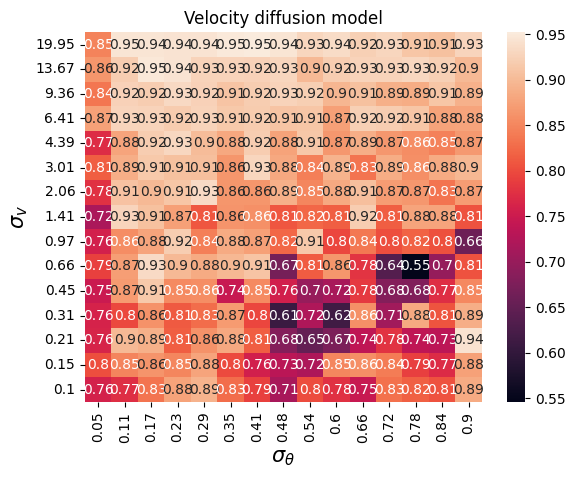

In [10]:
velocityDiffusion_correlations = pd.DataFrame(index=sigma_v_list, columns=sigma_t_list)

for sigma_v in sigma_v_list:
    for sigma_t in sigma_t_list:
        start = time.time()
        interaction_params = {
            "diffusion": {
                "rate": rate * np.ones(N),
                "sigma_v": sigma_v * np.ones(N),
                "sigma_t": sigma_t * np.ones(N),
            }
        }

        sim = StochasticFish_IndependentRates(
            N=N,
            Tmax=Tmax,
            arena_size=arena_size,
            interaction_params=interaction_params,
            vscale=v_scale,
        )
        sim.simulate()

        sim_object, derivedDF = get_predictors_from_sim(
            sim,
            grid_size=grid_size,
            frames_skipped=None,
            leeway=leeway,
            verbose=False,
            grid_sampling_fraction=grid_sampling_fraction,
            window_size_multiplier=window_size_multiplier,
            score_kwargs = score_kwargs
        )

        # save correlation
        velocityDiffusion_correlations.loc[sigma_v, sigma_t] = derivedDF.corr(method="spearman").loc[
            "vicsek", "pairwiseCopying"
        ]
        end = time.time()
        derivation_logger.info(f"[sigma_v={sigma_v},sigma_t={sigma_t}] generated in {end-start:.2f} seconds.")
        print("-"*50)

velocityDiffusion_correlations = velocityDiffusion_correlations.astype(float)
sns.heatmap(velocityDiffusion_correlations, annot=True)
plt.xlabel(r"$\sigma_{\theta}$",fontsize=15)
plt.ylabel(r"$\sigma_v$",fontsize=15)
plt.gca().invert_yaxis()
plt.title("Velocity diffusion model")
plt.show()

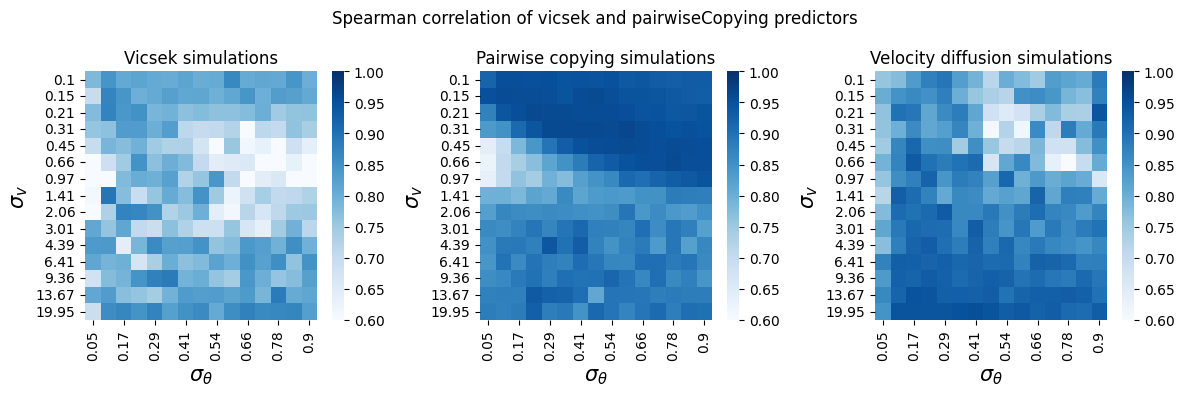

In [15]:
fig, ax = plt.subplots(1,3,figsize=(12,4))

sns.heatmap(vicsek_correlations, annot=False, vmin= 0.6, vmax = 1, ax = ax[0],cmap="Blues")
ax[0].set_xlabel(r"$\sigma_{\theta}$",fontsize=15)
ax[0].set_ylabel(r"$\sigma_v$",fontsize=15)
#ax[0].invert_yaxis()
ax[0].set_title("Vicsek simulations")

sns.heatmap(pairwiseCopying_correlations, annot=False, vmin= 0.6, vmax = 1, ax = ax[1],cmap="Blues")
ax[1].set_xlabel(r"$\sigma_{\theta}$",fontsize=15)
ax[1].set_ylabel(r"$\sigma_v$",fontsize=15)
#ax[1].invert_yaxis()
ax[1].set_title("Pairwise copying simulations")

sns.heatmap(velocityDiffusion_correlations, annot=False, vmin= 0.6, vmax = 1, ax = ax[2],cmap="Blues")
ax[2].set_xlabel(r"$\sigma_{\theta}$",fontsize=15)
ax[2].set_ylabel(r"$\sigma_v$",fontsize=15)
#ax[2].invert_yaxis()
ax[2].set_title("Velocity diffusion simulations")


fig.suptitle("Spearman correlation of vicsek and pairwiseCopying predictors")
fig.tight_layout()
plt.show()